#### The puprpose of this notebook is to calculate modified SAIN LIM nutrition scores on 59K food items

#### Author - Reshma

### Background

The nutrient modelling is done by using the French Food Standard Agency (AFSSA). AFSSA system is based on 2 previously published indicators: the Nutrient Density Score (NDS), based on qualifying nutrients (ie, positive nutrients), and the LIM score, based on disqualifying nutrients (ie, the nutrient to be limited).

In contrast, the nutrient density score developed by the AFSSA, which was named SAIN (score ofnutritional adequacy of individual foods), included a limited number of nutrients. Their selection reflected a balance between the need to include nutrients of importance to public health, nutrients markers of key food categories and/or markers of the presence of other nutrients, and the need for a manageable number of nutrients in a field setting.

#### SAIN Score
The SAIN score was an unweighted arithmetic mean of the percentage adequacy for 5 positive nutrients (plus 1 optional
nutrient). It was calculated for 100 kcal of food.

#### LIM Score
The LIM score was the mean percentage of the maximal recommended values for 3 nutrients, the intakes of which should be limited in a healthy diet. The LIM score was calculated for 100 g of food.

#### SAIN Score Formula
The nutrients included in the SAIN were proteins, fiber, ascorbic acid, calcium, and iron.
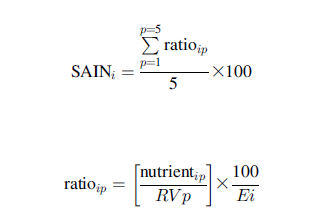

#### LIM Score Formula
The 3 limited nutrients were sodium, added sugars, and saturated fatty acids (SFAs). The LIM was multiplied by 2.5 for soft drinks.
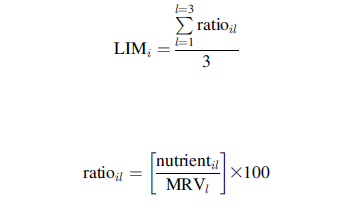

#### Tables to consider while calculations
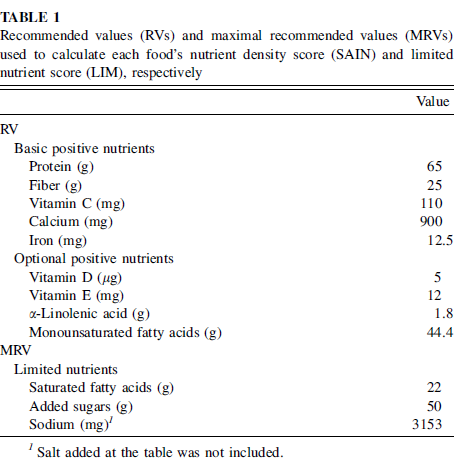

### Add micronutrients to each class
Nutritional constraints included in the ‘‘healthy’’ and ‘‘unhealthy’’ linear programming models.
In the ‘‘healthy’’ models, the nutritional quality of the modeled diets was achieved by a set of 40 constraints on macro- and
micronutrients based on European recommendations (30) and on mean French recommendations for men and women (29). For positive nutrients, minimal constraints were set at the level of the Recommended Dietary Allowances. Maximal constraints were included when needed, based on known safety levels of intakes for some nutrients. Constraints on nutrients whose intakes should be limited in a healthy diet (ie, total lipids, SFAs, total sugars, added sugars, sodium, and cholesterol) were also included to ensure that the modeled ‘‘healthy’’ diets will not exceed the maximal limits recommended for these nutrients. In contrast, in the ‘‘unhealthy’’ models, the nutritional constraints were introduced to ensure that the modeled diets had a low content of essential nutrients and a high content of total lipids, SFAs, total sugars, added sugars, sodium, and cholesterol. Unbalanced modeled diets were obtained by inverting the sign of the constraints in the unhealthy compared with the healthy models, and, for fiber, essential fatty acids, and micronutrients by setting the maximum at 77% of the Recommended Dietary Allowance (ie, approximately the level of the Estimated Average Requirements). In both healthy and unhealthy models,the realism and social acceptability of the modeled diets wereachieved by the same set of constraints on food and food group’s weights (in g) to ensure that the inclusion of any one food and food group could not exceed the 99th percentile limit of the corresponding consumer intake distribution. The effect of selecting foods according to their SAIN,LIM profiles on the possibility to fulfill the nutrient constraints introduced in the healthy and unhealthy models was tested by designing models that differed by the list of foods allowed to be included in the modeled diets. Depending on the model, the food access was restricted to one SAIN,LIM class only or to one of all the possible combinations of the 4 classes, leading to a total of 15 models (4 single models 1 11 combination models) for each set of nutritional constraints, ie, 15 healthy models and 15 unhealthy models. Each
model was named by the type of SAIN,LIM class allowed for the food variables. Unfeasible models were first identified. Then, for each feasible model, 2 objective functions were run—energy minimization and maximization—to assess the minimal energy
needed to fulfill the constraints and the maximal energy achievable while fulfilling them, respectively. These theoretical energy bounds were compared with the mean observed energy intake in the general population (ie, 2000 kcal, or 8.3 MJ/d). In addition, the energy contributed by each SAIN,LIM class in each feasible combination model was assessed.

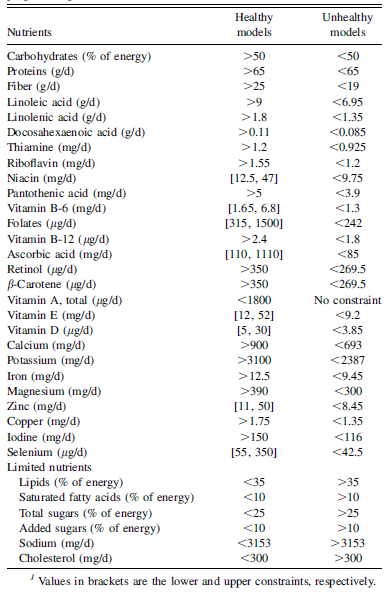

In [1]:
#max, min range
thiamine         = [1.2, 0.925] 
riboflavin       = [1.55, 1.2]
pantothenic_acid = [0.5, 3.9]
retinol          = [0.35, 269.5]
beta_carotene    = [0.35, 269.5]
vit_b12          = [2.4, 1.8]
calcium          = [900, 693]
potassium        = [3100, 2387]
iron             = [12.5, 9.45]
mgnesium         = [390, 300]
copper           = [1.75, 1.35]
cholesterol      = [300, 300]
vit_a            = [1800] #mcg
vit_a            = [5000] #IU - FDA reference

#middle, max, min range
niacin           = [12.5, 47, 9.75] 
vit_b6           = [1.65, 6.8, 1.3]
folates          = [315, 1500, 242]
asc_acid         = [110, 1110, 85]
vit_e            = [12, 52, 9.2]
vit_d            = [5, 30, 3.85]
zinc             = [11, 50, 8.45]
selenium         = [55, 350, 42.5]

In [2]:
#import libraries
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#missing value computation
def cal_missing_val(df):
    data_dict = {}
    for col in df.columns:
        data_dict[col] = (df[col].isnull().sum()/df.shape[0])*100
    return pd.DataFrame.from_dict(data_dict, orient='index', columns=['MissingValueInPercentage'])

In [4]:
rv_dict={'Protein': 65, 'Fiber': 25, 'Vitamin C': 110, 'Calcium': 900, 'Iron': 12.5, 'Vitamin D': 5, 'Vitamin E': 12, 
        'Alpha linolenic acid': 1.8, 'Monounsaturated fatty acids': 44.4, 'Saturated fatty acids':22,'Sugars':50, 'Sodium':3153, 
        'Thiamine': 1.2, 'Riboflavin':1.55, 'Pantothenic acid': 0.5, 'Retinol':0.35, 'Beta Carotene': 0.35, 'Vitamin B12': 2.4,
        'Calcium': 900, 'Potassium': 3100, 'Iron': 12.5, 'Magnesium': 390, 'Copper': 1.75, 'Cholesterol': 300, 'Niacin':12.5, 
        'Vitamin B6': 1.65, 'Folates': 315, 'Zinc': 11, 'Selenium': 55, 'Vitamin A': 5000, 'Carbohydrates': 50}

### Reading food items from datasets

In [5]:
path     = 'C:/Users/SSK/Documents/UC - MScA/Courses/Capstone/Datasets/Nutrition/'
fileName = 'Nutrition Data Consolidated (James)_type_EWG.csv' #latest file

In [6]:
data      = pd.read_csv(path+fileName)

In [1]:
drop_cols=['Sub_food_category', 'Main_food_category', 'PRAL score', 'Serving Weight 1 (g)','Serving Description 1 (g)','Serving Weight 2 (g)',
           'Serving Description 2 (g)','Serving Weight 3 (g)','Serving Description 3 (g)','Serving Weight 4 (g)','Serving Description 4 (g)',
           'Serving Weight 5 (g)', 'Serving Description 5 (g)','Serving Weight 6 (g)','Serving Description 6 (g)','Serving Weight 7 (g)',
           'Serving Description 7 (g)','Serving Weight 8 (g)','Serving Description 8 (g)','nf_ingredient_statement','nf_servings_per_container',
           'nf_serving_size_qty','nf_serving_size_unit','usda_field', 'organic','pasteurized','artificial','x_free','reduced_x','low_x']

### Convert carbohydrates from gram to % energy

In [2]:
data['Carbohydrates percent energy']      = data[['Carbohydrate (g)', 'calories']].apply(lambda x : (x['Carbohydrate (g)']*100)/x['calories'], axis=1)

### Compute SAIN Score

In [3]:
def compute_sain(row, rv_dict):
    cal        = row['calories']
    ro_protein = (row['Protein (g)']/rv_dict['Protein'])*(100/cal)
    ro_fiber   = (row['Fiber (g)']/rv_dict['Fiber'])*(100/cal)
    ro_vitc    = (row['Vitamin C (mg)']/rv_dict['Vitamin C'])*(100/cal)
    ro_calcm   = (row['Calcium (mg)']/rv_dict['Calcium'])*(100/cal)
    ro_iron    = (row['Iron, Fe (mg)']/rv_dict['Iron'])*(100/cal)
    ro_mn_fa   = (row['Fatty acids, total monounsaturated (mg)']/rv_dict['Monounsaturated fatty acids'])*(100/cal)
    ro_vitd    = (row['Vitamin D (mcg)']/rv_dict['Vitamin D'])*(100/cal)
    ro_vite    = (row['Vitamin E (Alpha-Tocopherol) (mg)']/rv_dict['Vitamin E'])*(100/cal)
    ro_thiam   = (row['Thiamin (B1) (mg)']/rv_dict['Thiamine'])*(100/cal)
    ro_ribo    = (row['Riboflavin (B2) (mg)']/rv_dict['Riboflavin'])*(100/cal)
    ro_niac    = (row['Niacin (B3) (mg)']/rv_dict['Niacin'])*(100/cal)
    ro_panto   = (row['Pantothenic acid (B5) (mg)']/rv_dict['Pantothenic acid'])*(100/cal)
    ro_vitb6   = (row['Vitamin B6 (mg)']/rv_dict['Vitamin B6'])*(100/cal)
    ro_fola    = (row['Folate (B9) (mcg)']/rv_dict['Folates'])*(100/cal)
    ro_reti    = (row['Retinol (mcg)']/rv_dict['Retinol'])*(100/cal)
    ro_bcar    = (row['Carotene, beta (mcg)']/rv_dict['Beta Carotene'])*(100/cal)
    ro_pota    = (row['Potassium, K (mg)']/rv_dict['Potassium'])*(100/cal)
    ro_magn    = (row['Magnesium (mg)']/rv_dict['Magnesium'])*(100/cal)
    ro_vitb12  = (row['Vitamin B-12 (mcg)']/rv_dict['Vitamin B12'])*(100/cal)
    ro_copr    = (row['Copper, Cu (mg)']/rv_dict['Copper'])*(100/cal)
    ro_zinc    = (row['Zinc, Zn (mg)']/rv_dict['Zinc'])*(100/cal)
    ro_sele    = (row['Selenium, Se (mcg)']/rv_dict['Selenium'])*(100/cal)
    ro_carb    = (row['Carbohydrates percent energy']/rv_dict['Carbohydrates'])*(100/cal)
    ro_vita    = (row['Vitamin A, IU (IU)']/rv_dict['Vitamin A'])*(100)

    ro_arr     = np.array([ro_protein, ro_fiber, ro_vitc, ro_calcm, ro_iron, ro_mn_fa, ro_vitd, ro_vite, ro_thiam, 
                           ro_ribo, ro_niac, ro_panto, ro_vitb6, ro_fola, ro_reti, ro_bcar, ro_pota, 
                            ro_magn, ro_vitb12, ro_copr, ro_zinc, ro_sele, ro_carb, ro_vita])
    ro_arr[ro_arr==np.inf] = np.nan
    ro_mean = np.nanmean(ro_arr)
    if pd.notnull(ro_mean):
        sain_mean    = ro_mean*100
        return (sain_mean)
    else:
        return(0)


sain_cols = ['Protein (g)','Fiber (g)', 'Vitamin C (mg)','Calcium (mg)', 'Iron, Fe (mg)', 'calories', 'Fatty acids, total monounsaturated (mg)', 'Vitamin D (mcg)', 'Vitamin E (Alpha-Tocopherol) (mg)',
            'Thiamin (B1) (mg)','Riboflavin (B2) (mg)','Niacin (B3) (mg)','Pantothenic acid (B5) (mg)','Vitamin B6 (mg)','Folate (B9) (mcg)','Retinol (mcg)', 'Carotene, beta (mcg)','Potassium, K (mg)','Magnesium (mg)',
            'Copper, Cu (mg)','Zinc, Zn (mg)', 'Selenium, Se (mcg)', 'Vitamin B-12 (mcg)', 'Carbohydrates percent energy','Vitamin A, IU (IU)']

data['SAIN score']            = data[sain_cols].apply(lambda x : compute_sain(x, rv_dict), axis=1)
data['SAIN log score']        = np.log(data['SAIN score'])
data['SAIN log score'].replace([np.inf, -np.inf], 0, inplace=True)

data['SAIN log score'] = data['SAIN log score'].apply(lambda x: 0 if x<0 else x)

### Compute LIM score

In [4]:
def compute_lim(row, rv_dict):
    aisle       = row['aisle']
    ro_sugar    = (row['Sugars (g)']/rv_dict['Sugars'])*(100)
    ro_sodium   = (row['Sodium (mg)']/rv_dict['Sodium'])*(100)
    ro_satf     = (row['Saturated Fats (g)']/rv_dict['Saturated fatty acids'])*(100)
    ro_chole    = (row['Cholesterol (mg)']/rv_dict['Cholesterol'])*(100)
    ro_arr      = np.array([ro_sugar, ro_sodium, ro_satf, ro_chole])
    ro_arr[ro_arr==np.inf] = np.nan
    ro_mean = np.nanmean(ro_arr)
    if pd.notnull(ro_mean):
        if aisle == 'soft drinks':
            ro_mean = ro_mean*2.5
        lim_mean    = ro_mean*100
        return (lim_mean)
    else:
        return(0)
    
lim_cols = ['Sugars (g)', 'Sodium (mg)', 'Saturated Fats (g)', 'aisle', 'Cholesterol (mg)']

data['LIM score']     = data[lim_cols].apply(lambda x : compute_lim(x, rv_dict), axis=1)
data['LIM log score'] = np.log(data['LIM score'])
data['LIM log score'].replace([np.inf, -np.inf], 0, inplace=True)

data['LIM log score'] = data['LIM log score'].apply(lambda x: 0 if x<0 else x)

In [11]:
data['SAIN score'].describe()

count    5.892400e+04
mean     3.611159e+03
std      7.869037e+04
min      0.000000e+00
25%      5.037897e+00
50%      3.971796e+01
75%      2.825979e+02
max      1.702778e+07
Name: SAIN score, dtype: float64

In [12]:
data['SAIN log score'].describe()

count    58924.000000
mean         3.858259
std          2.625639
min          0.000000
25%          1.616989
50%          3.681803
75%          5.644025
max         16.650357
Name: SAIN log score, dtype: float64

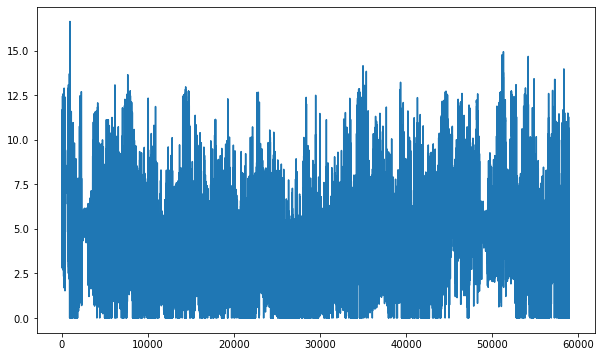

In [13]:
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
plt.plot(data['SAIN log score'])
plt.show()

In [14]:
data['LIM score'].describe()

count     58924.000000
mean       1804.324559
std        5431.572154
min           0.000000
25%         463.461873
50%        1023.869463
75%        2024.708369
max      524895.001394
Name: LIM score, dtype: float64

In [15]:
data['LIM log score'].describe()

count    58924.000000
mean         6.530454
std          1.903150
min          0.000000
25%          6.138724
50%          6.931344
75%          7.613181
max         13.170954
Name: LIM log score, dtype: float64

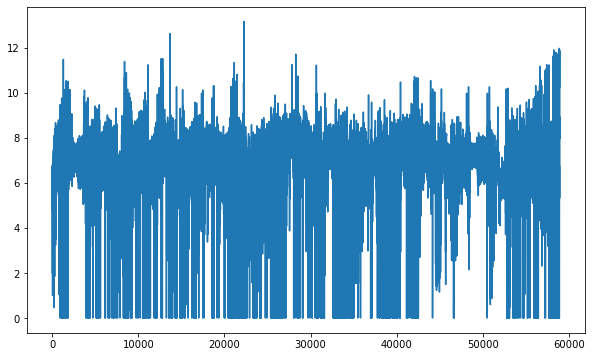

In [16]:
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
plt.plot(data['LIM log score'])
plt.show()

## Divide foods into classes

#### Threshold values were defined for each score

On the basis of a reference daily energy intake of 2000 kcal, the optimum value for the SAIN was 100% for 2000 kcal, which was
equivalent to 5% for 100 kcal food. A SAIN value 5 indicated, therefore, a good nutrient density. Unlike the SAIN, the LIM was
calculated for 100 g. Thus, the reference value used to derive the threshold value for the LIM score was based on food intake rather than on energy intake. Because the mean daily food intake (including solid foods only) observed in the French population
was ’1330 g/d (18), the maximal value for the LIM score was 100% for 1330 g, which was equivalent to 7.5% for 100 g food.
A LIM value ,7.5 indicated, therefore, a low content of limited nutrients.

##### Reference
* class 1, SAIN >= 5 and LIM < 7.5
* class 2, SAIN < 5 and LIM <  7.5
* class 3, SAIN >= 5 and LIM >= 7.5 
* class 4, SAIN < 5 and LIM >= 7.5

##### We came up with
* class 1, SAIN >= 2 and LIM < 6.4
* class 2, SAIN < 2 and LIM <  6.4
* class 3, SAIN >= 2 and LIM >= 6.4
* class 4, SAIN < 2 and LIM >= 6.4

In [17]:
def create_food_classes(score, thresholds):
    sain = score[0]#['SAIN log score']
    lim  = score[1]#['LIM log score']
    
    if sain >= thresholds[0] and lim < thresholds[1]:
        return 'class 1'
    elif sain < thresholds[0] and lim < thresholds[1]:
        return 'class 2'
    elif sain >= thresholds[0] and lim >= thresholds[1]:
        return 'class 3'
    elif sain < thresholds[0] and lim >= thresholds[1]:
        return 'class 4'
    else:
        return 'no class'

In [33]:
# data

In [18]:
data['Food Class'] = data[['SAIN log score','LIM log score']].apply(lambda x : create_food_classes(x.values, [5, 7.5]), axis=1)

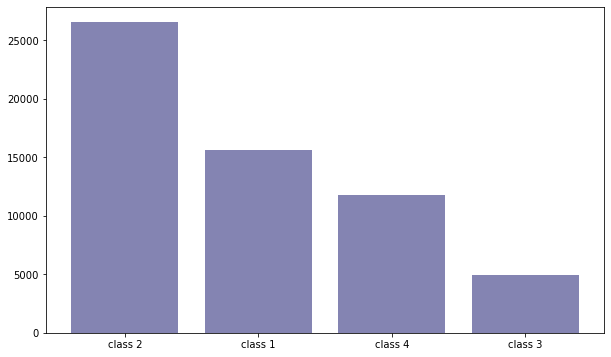

In [19]:
class_df = pd.DataFrame(data['Food Class'].value_counts()).reset_index()
class_df.columns=['Class', 'Count']
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
plt.bar(class_df['Class'],class_df['Count'], color = (0.2,0.2,0.5,0.6))
plt.show()

In [20]:
data['Food Class corrected'] = data[['SAIN log score','LIM log score']].apply(lambda x : create_food_classes(x.values,[3,6]), axis=1)

### Distribution of food classes

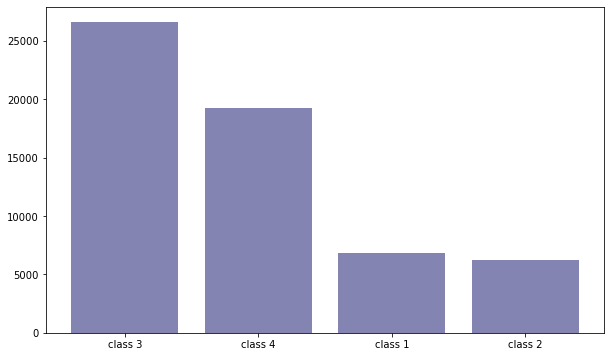

In [21]:
class_df = pd.DataFrame(data['Food Class corrected'].value_counts()).reset_index()
class_df.columns=['Class', 'Count']
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
plt.bar(class_df['Class'],class_df['Count'], color = (0.2,0.2,0.5,0.6))
plt.show()

### Distribution of Aisles for Class 1

Text(0.5, 1.0, 'Class 1 Aisle breakdown')

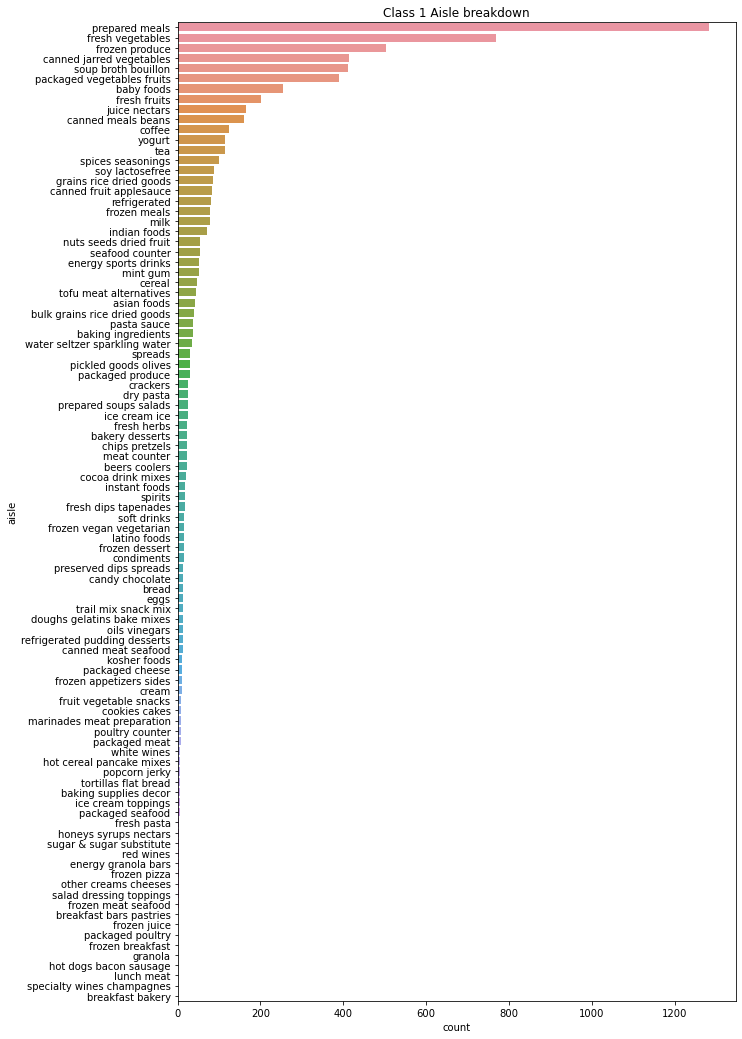

In [22]:
import seaborn as sns
class1 = data[data['Food Class corrected'] == 'class 1'][['name', 'aisle']]

class1_aisle = pd.DataFrame(class1['aisle'].value_counts()).reset_index()
class1_aisle.columns=['aisle', 'count']
fig = plt.figure() 
fig.set_size_inches(10, 18)
sns.barplot(y='aisle', x='count', data=class1_aisle, orient="h").set_title('Class 1 Aisle breakdown')

### Distribution of Aisles for Class 2

Text(0.5, 1.0, 'Class 2 Aisle breakdown')

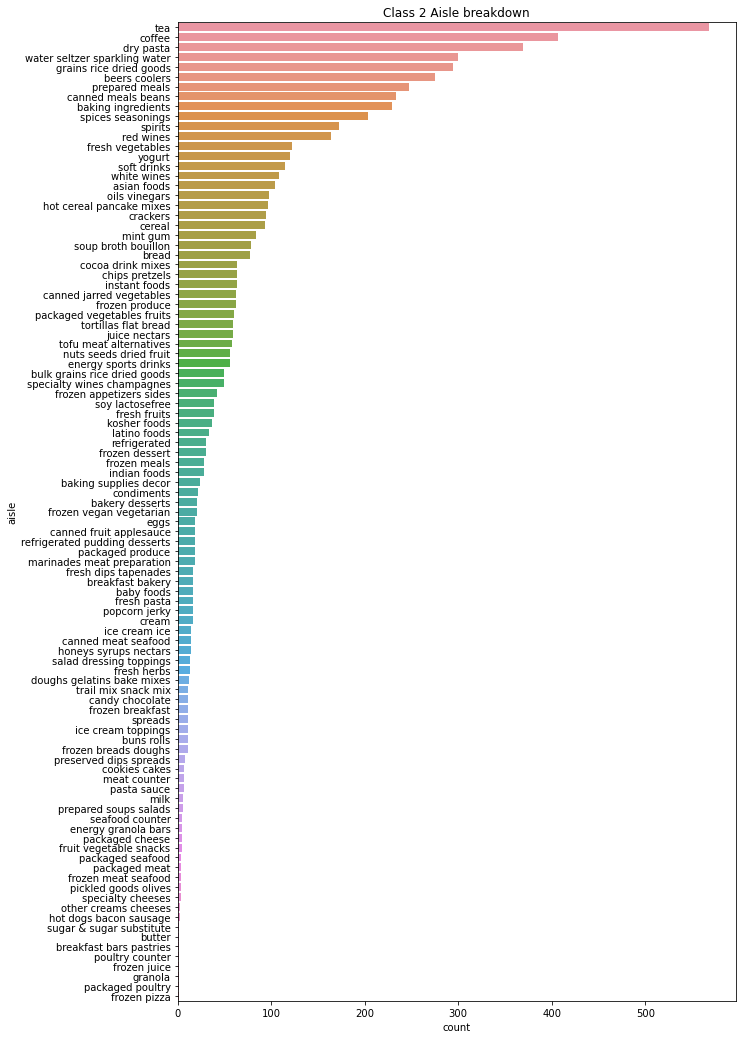

In [23]:
class2 = data[data['Food Class corrected'] == 'class 2'][['name', 'aisle']]
class2_aisle = pd.DataFrame(class2['aisle'].value_counts()).reset_index()
class2_aisle.columns=['aisle', 'count']
fig = plt.figure() 
fig.set_size_inches(10, 18)
sns.barplot(y='aisle', x='count', data=class2_aisle, orient="h").set_title('Class 2 Aisle breakdown')

### Distribution of Aisles for Class 3

Text(0.5, 1.0, 'Class 3 Aisle breakdown')

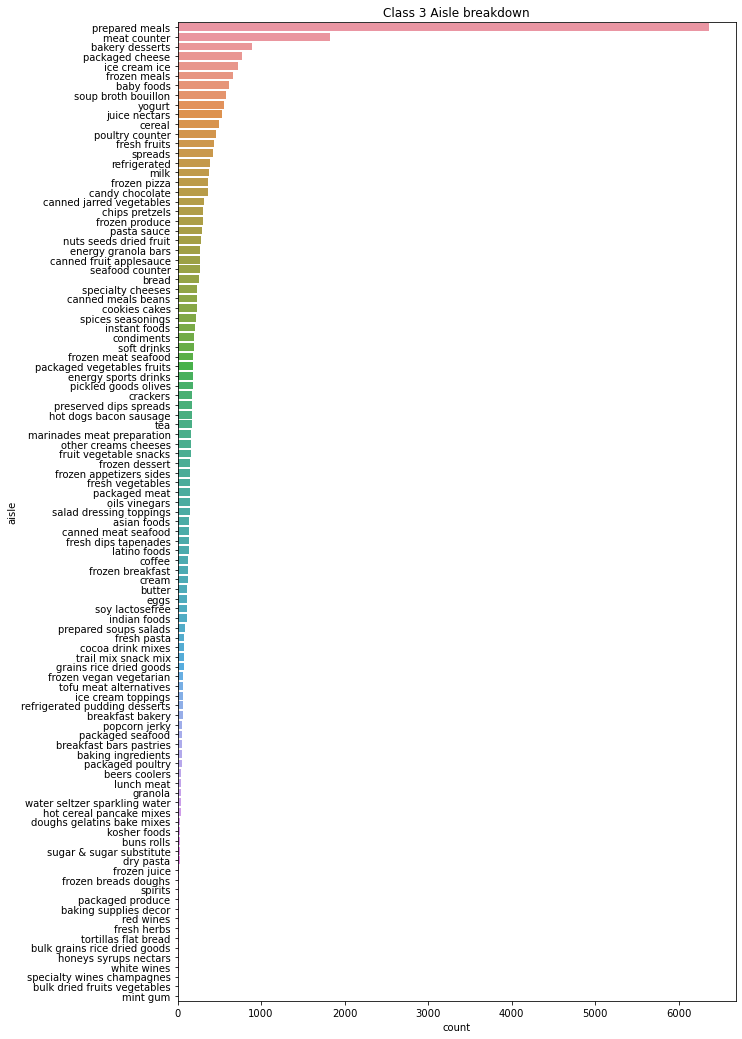

In [24]:
class3 = data[data['Food Class corrected'] == 'class 3'][['name', 'aisle']]
class3_aisle = pd.DataFrame(class3['aisle'].value_counts()).reset_index()
class3_aisle.columns=['aisle', 'count']
fig = plt.figure() 
fig.set_size_inches(10, 18)
sns.barplot(y='aisle', x='count', data=class3_aisle, orient="h").set_title('Class 3 Aisle breakdown')

### Distribution of Aisles for Class 4

Text(0.5, 1.0, 'Class 4 Aisle breakdown')

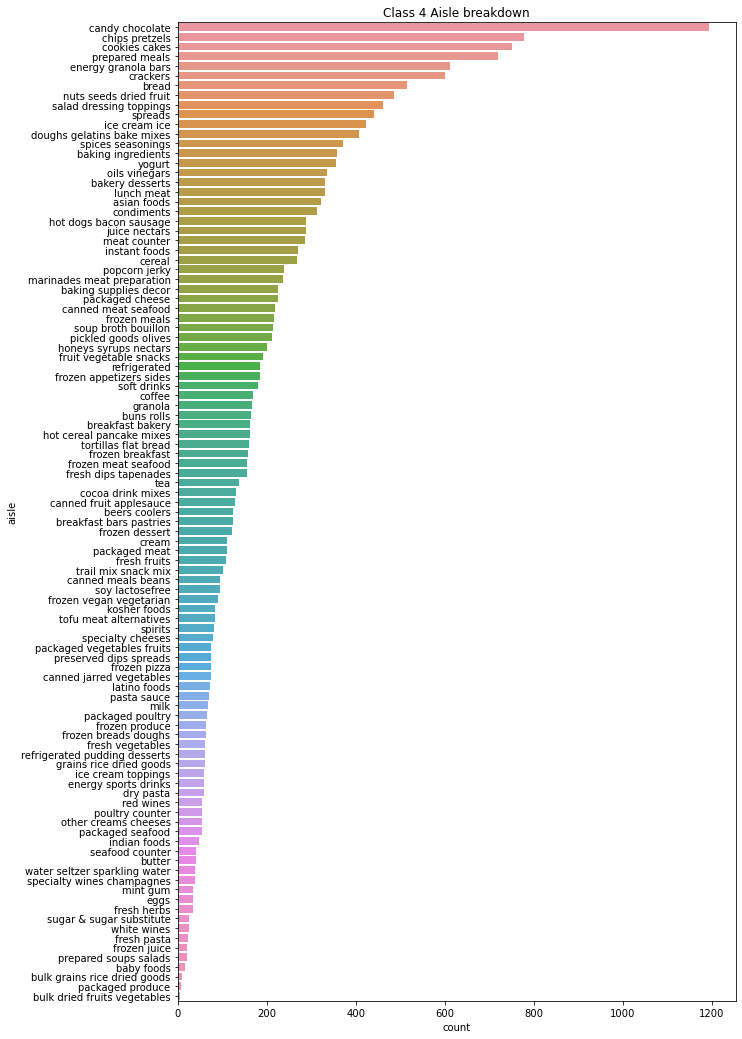

In [25]:
class4 = data[data['Food Class corrected'] == 'class 4'][['name', 'aisle']]
class4_aisle = pd.DataFrame(class4['aisle'].value_counts()).reset_index()
class4_aisle.columns=['aisle', 'count']
fig = plt.figure() 
fig.set_size_inches(10, 18)
sns.barplot(y='aisle', x='count', data=class4_aisle, orient="h").set_title('Class 4 Aisle breakdown')

### Food class distribution of each aisle 

In [27]:
def plot_barplot(df, name, col_name, x_name):
    df = df[df.aisle == name]
    score_count = df[col_name].value_counts()
    plt.figure(figsize=(10,5))
    sns.barplot(score_count.index, score_count.values, alpha=0.8)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(x_name, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title(name)
    plt.show()

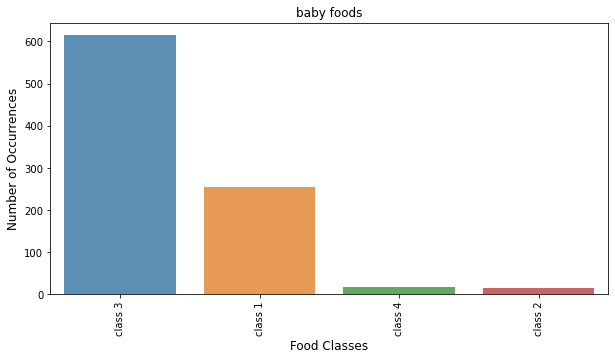

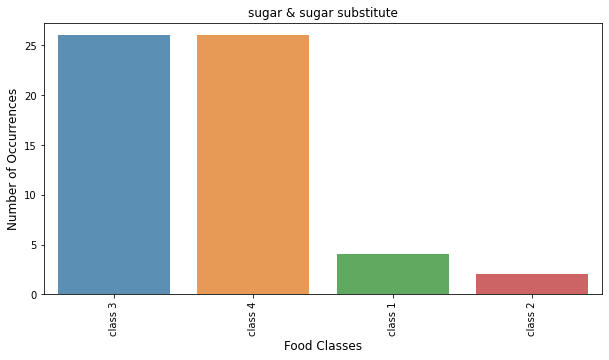

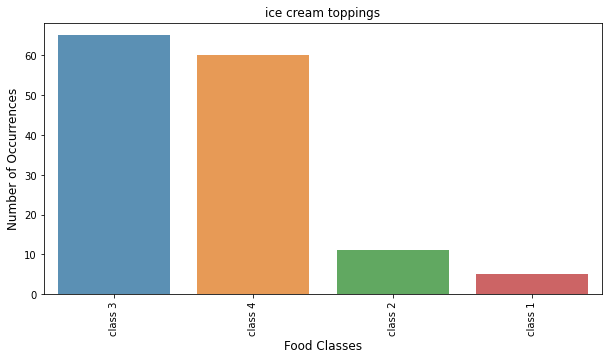

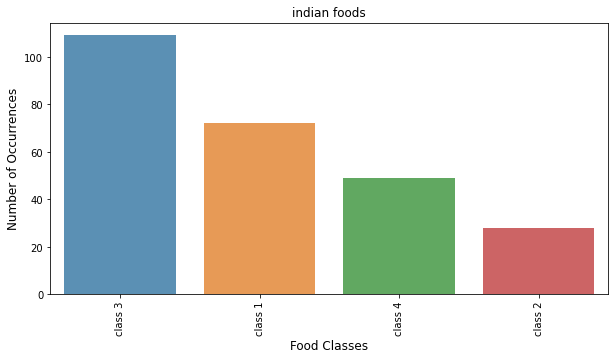

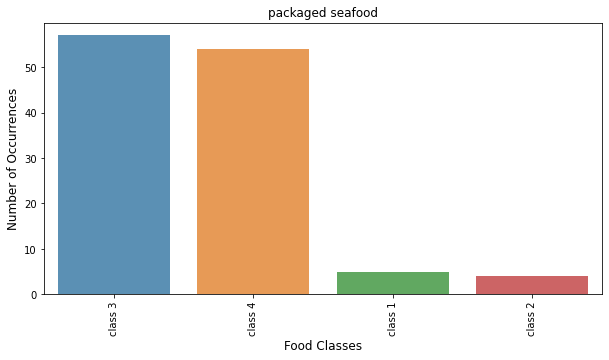

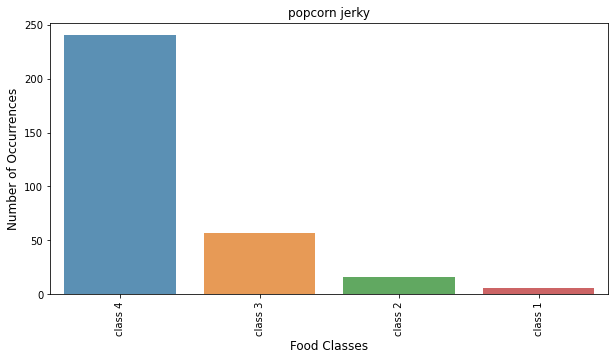

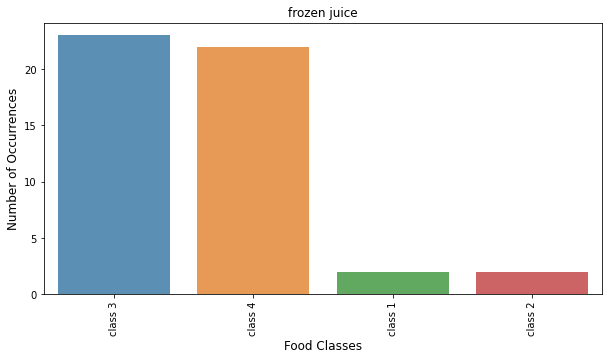

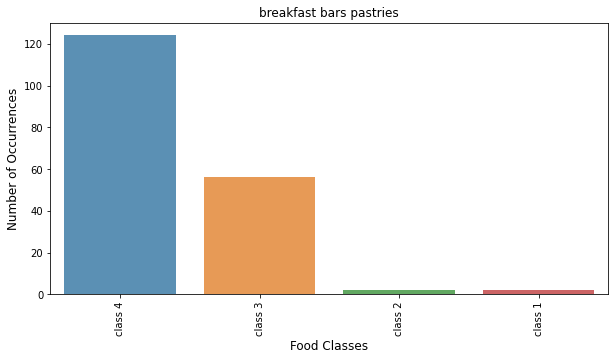

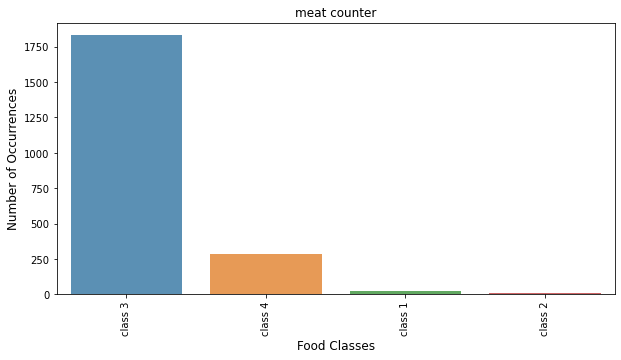

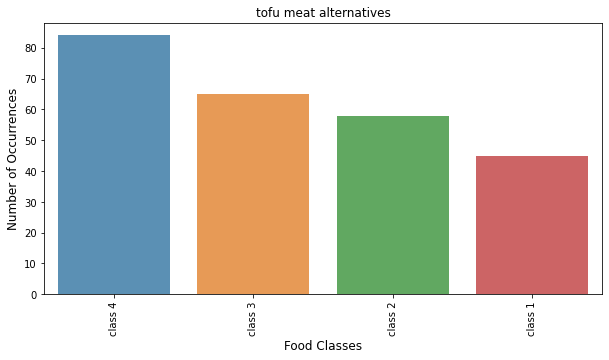

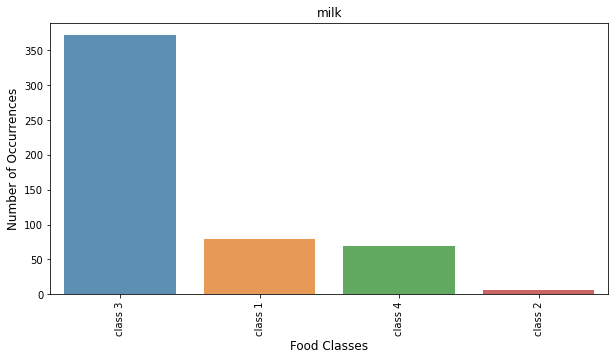

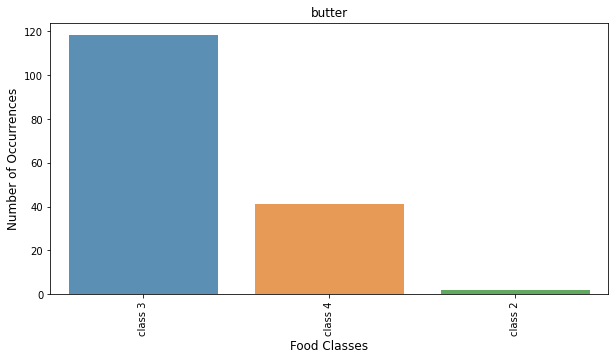

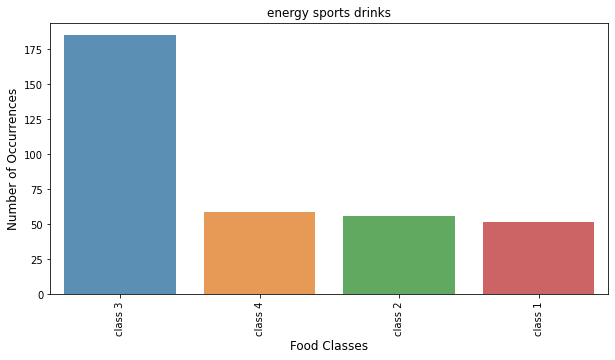

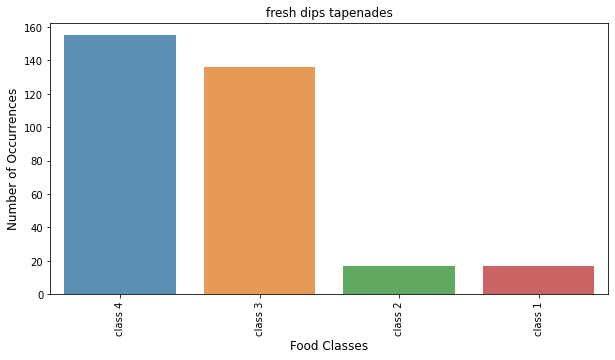

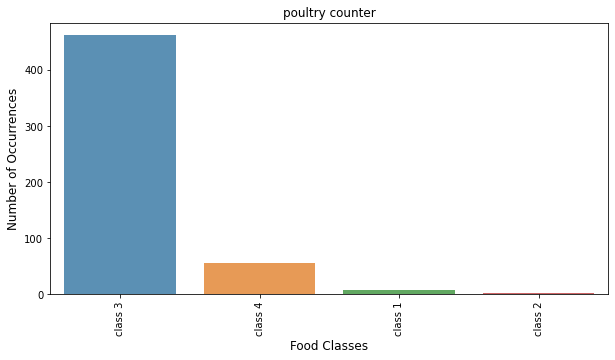

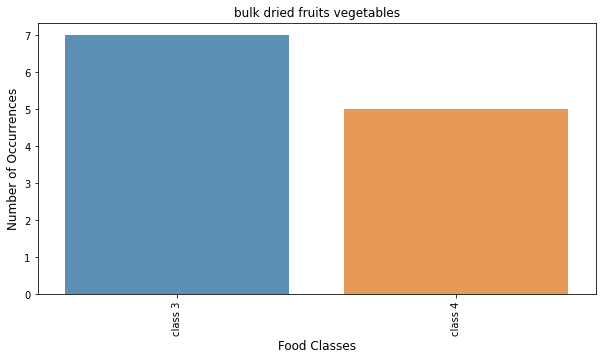

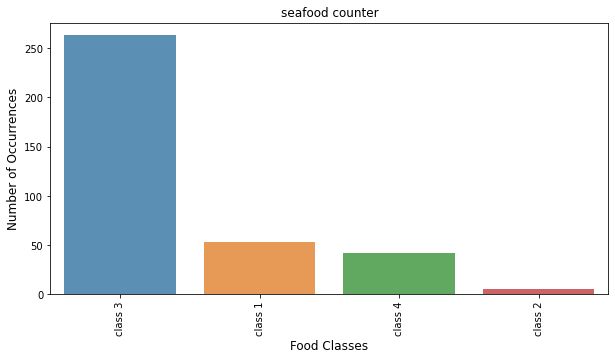

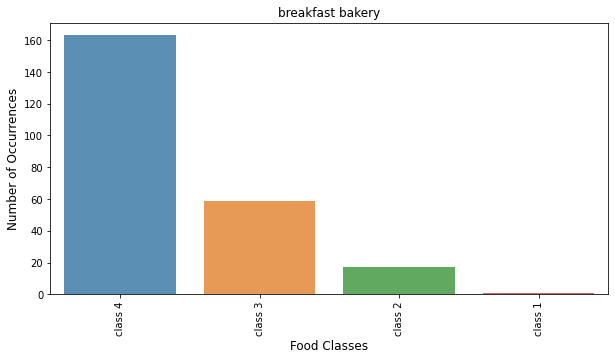

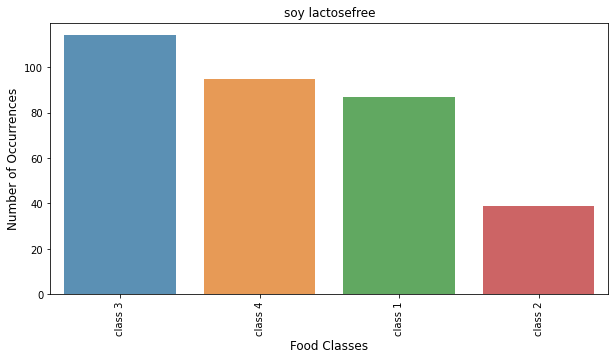

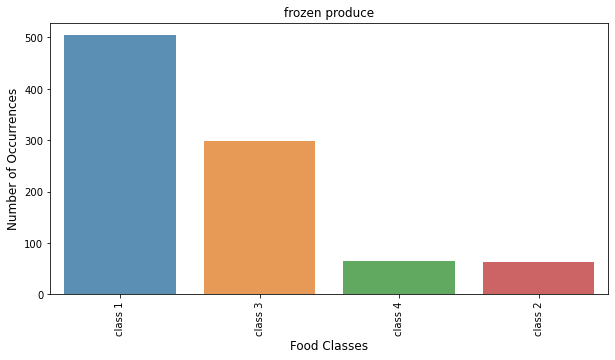

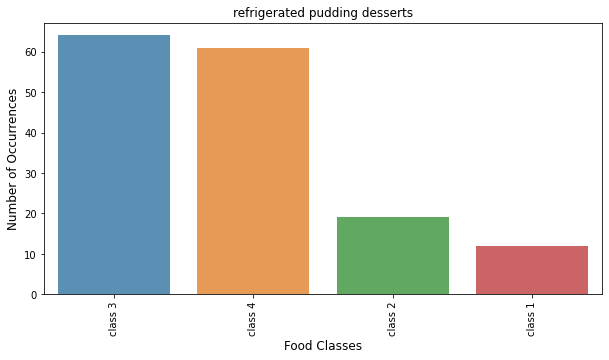

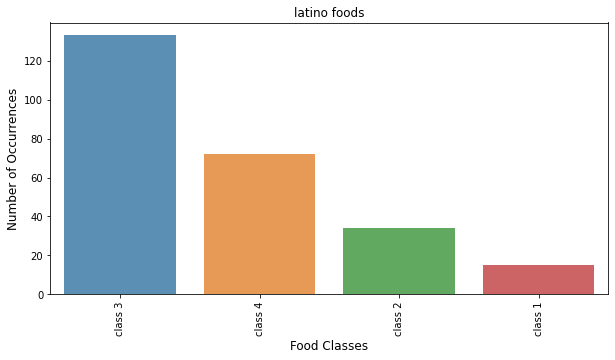

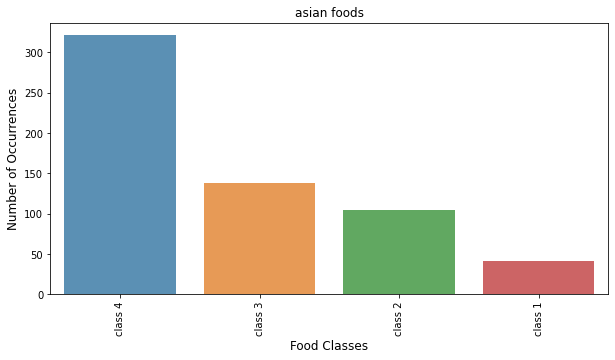

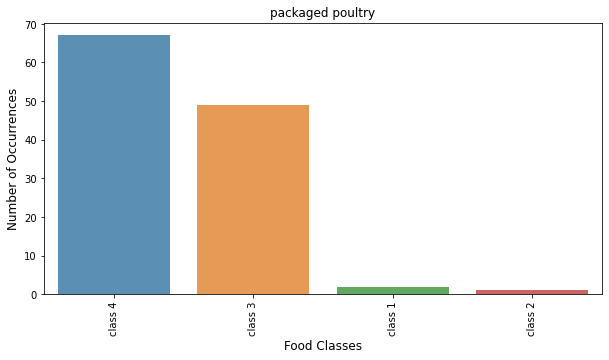

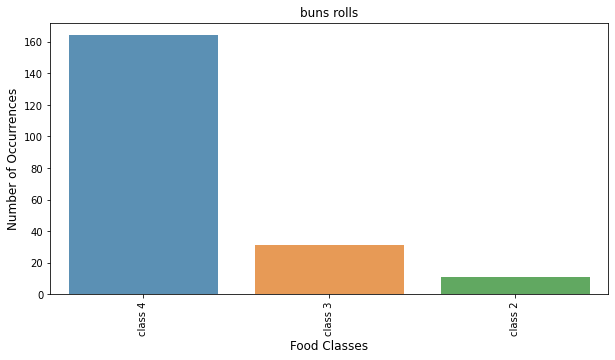

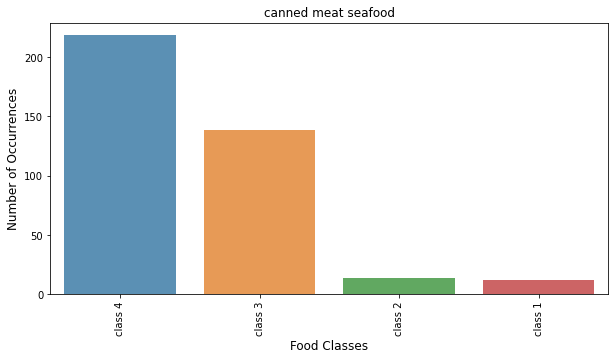

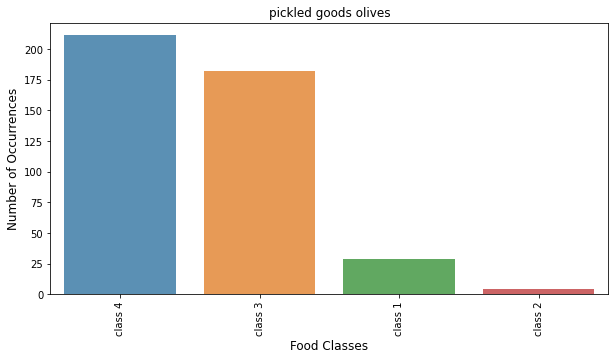

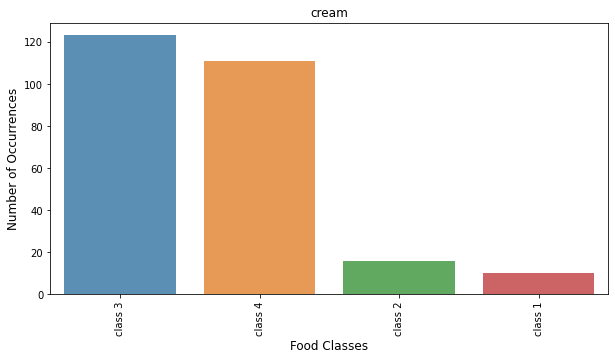

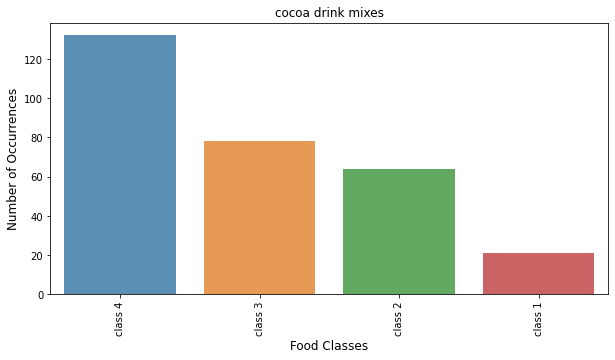

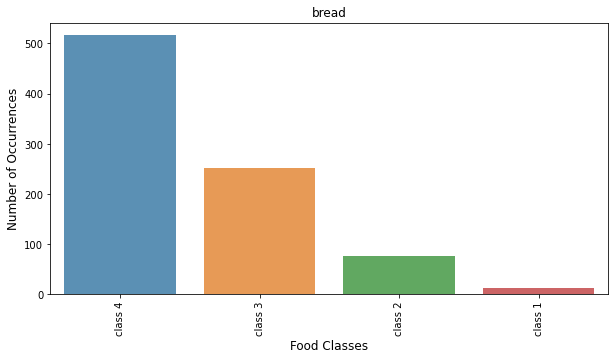

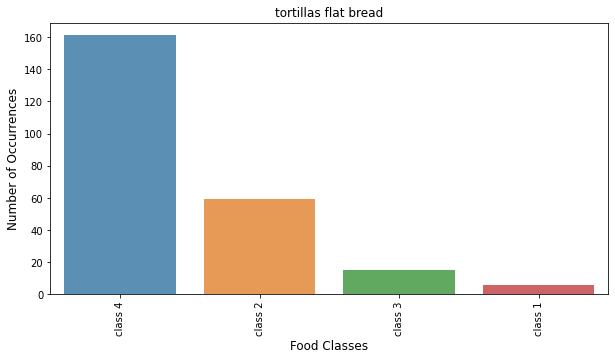

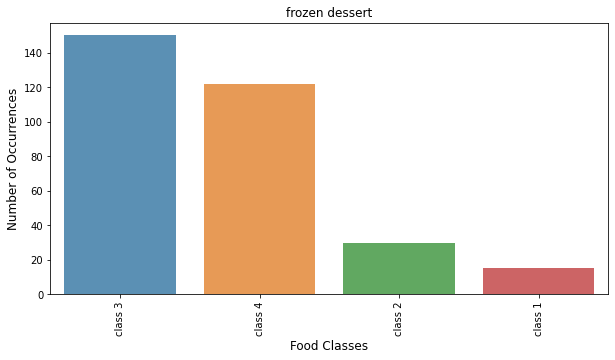

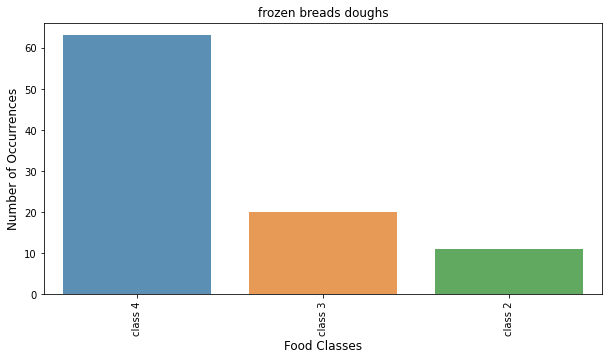

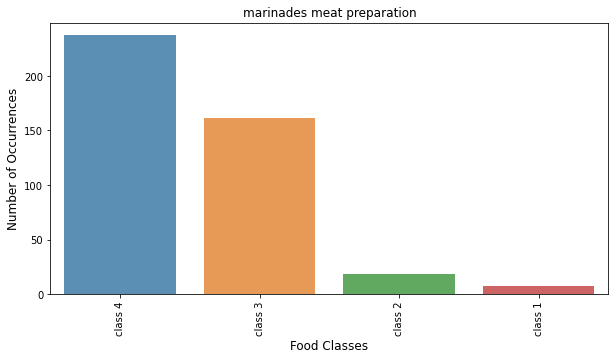

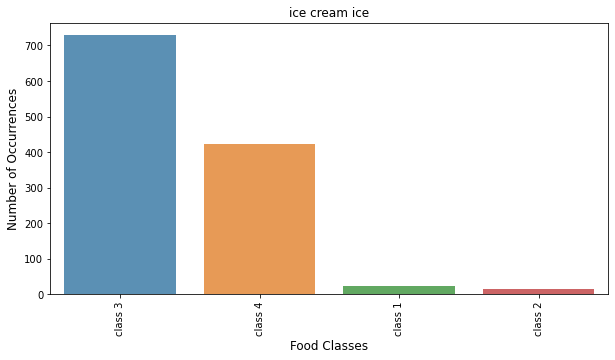

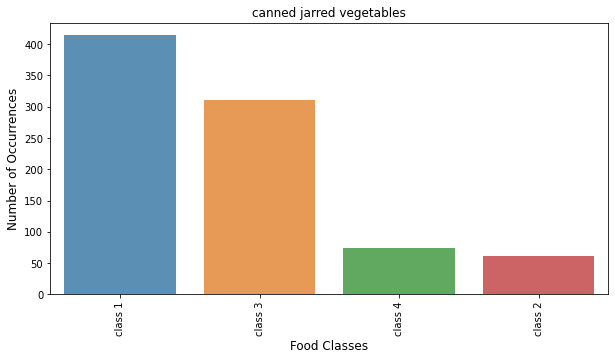

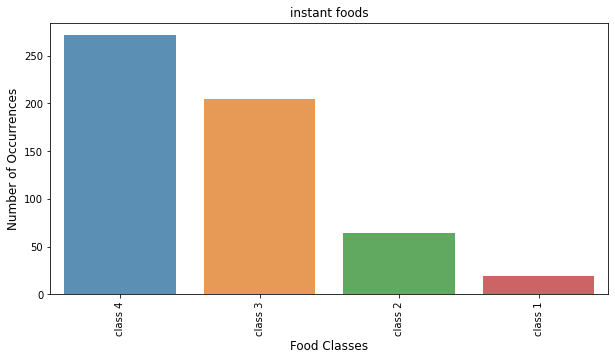

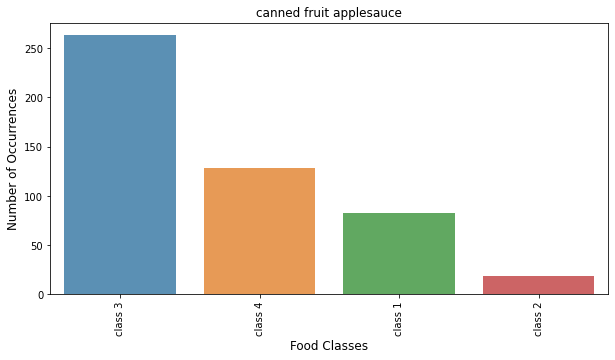

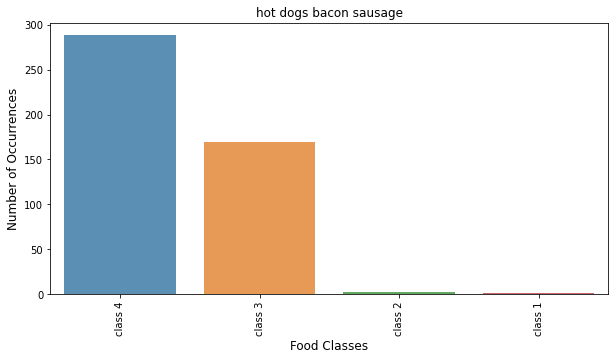

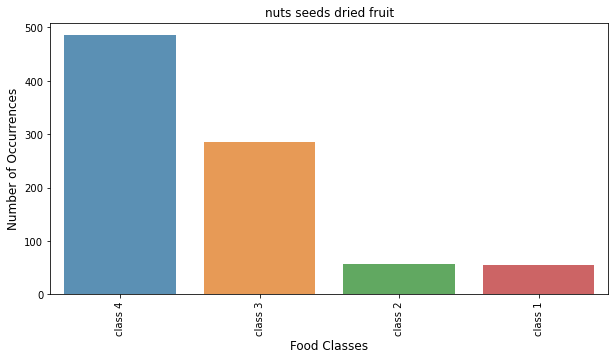

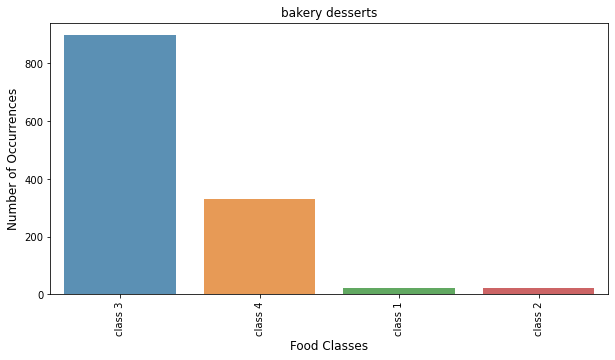

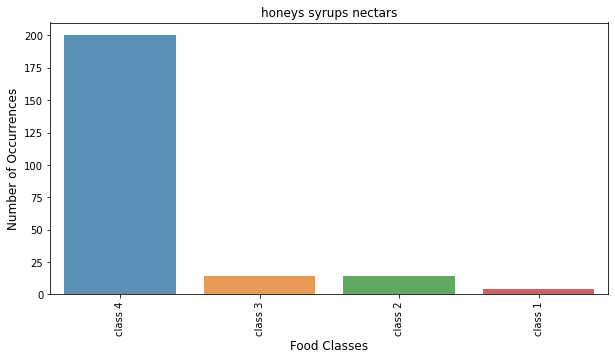

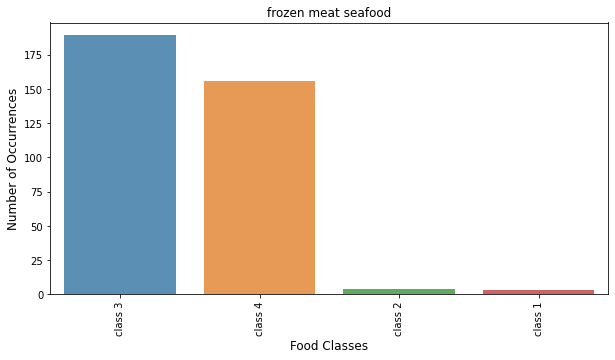

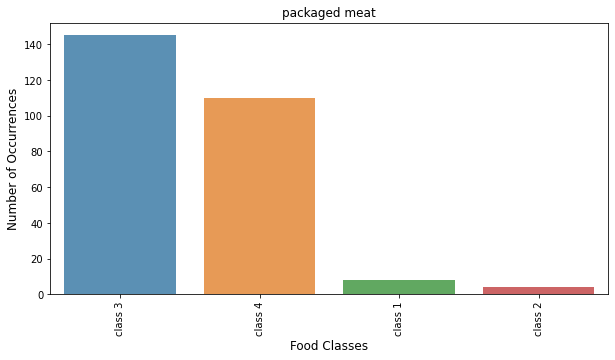

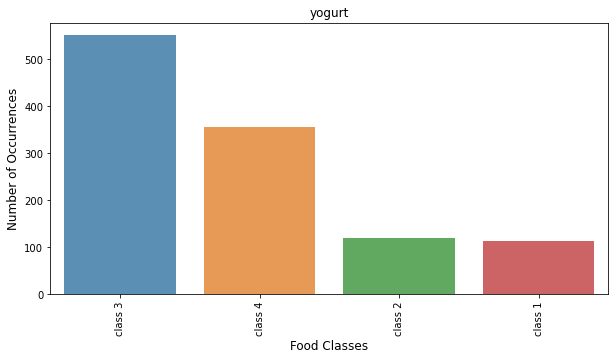

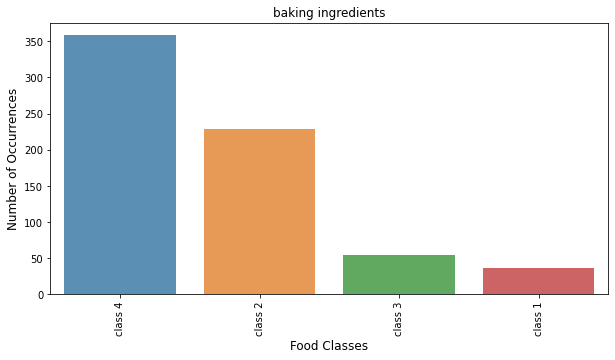

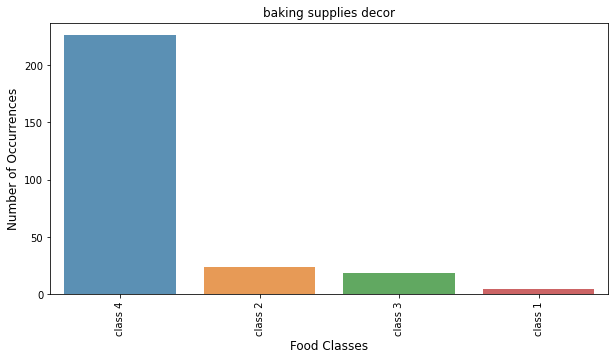

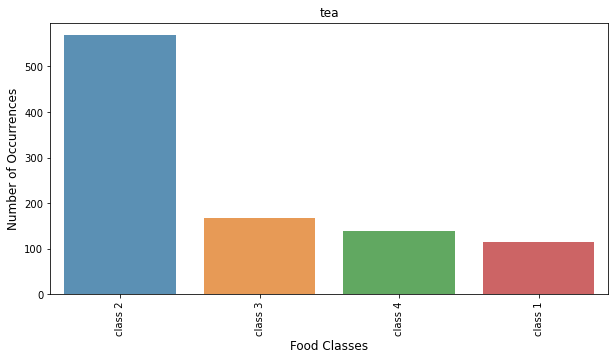

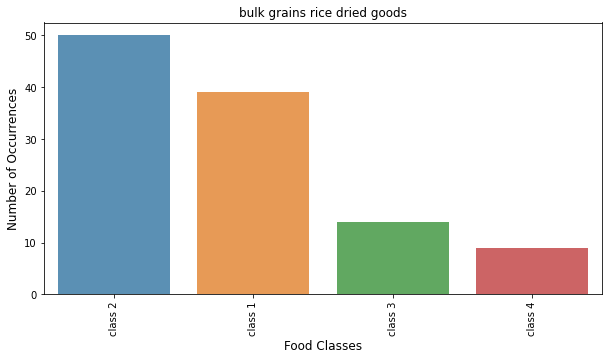

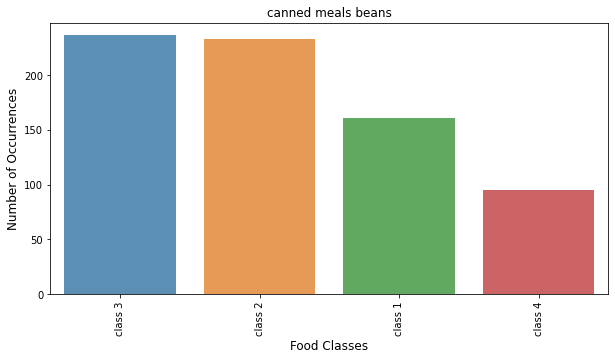

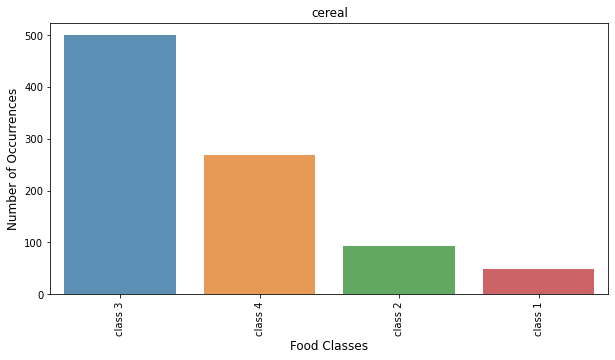

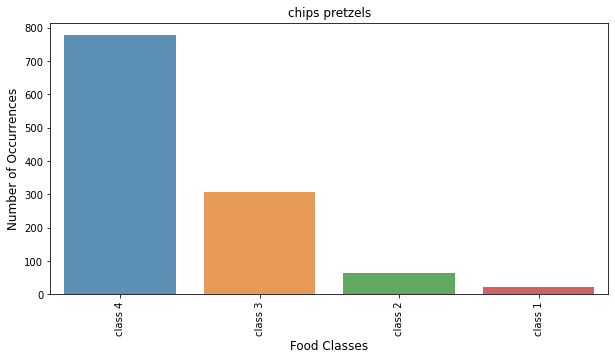

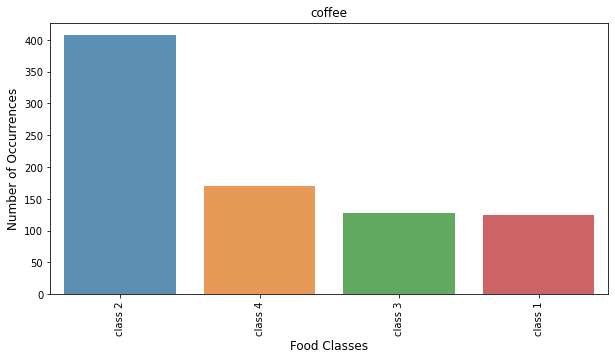

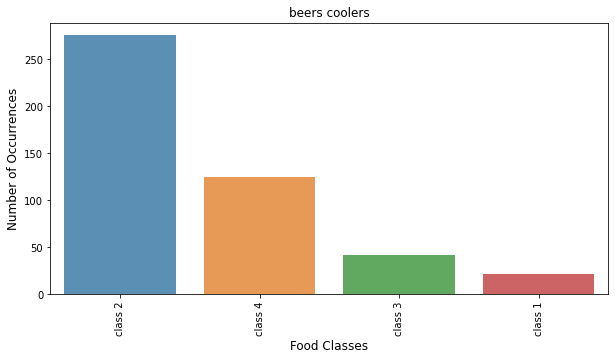

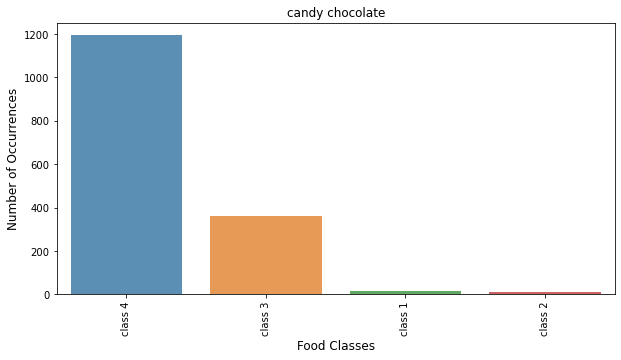

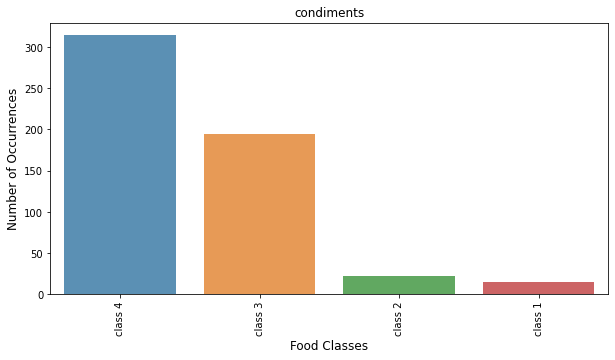

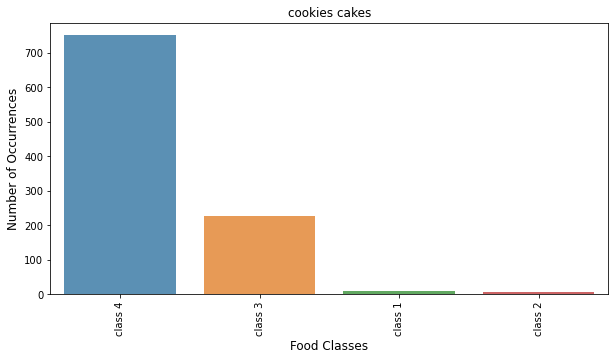

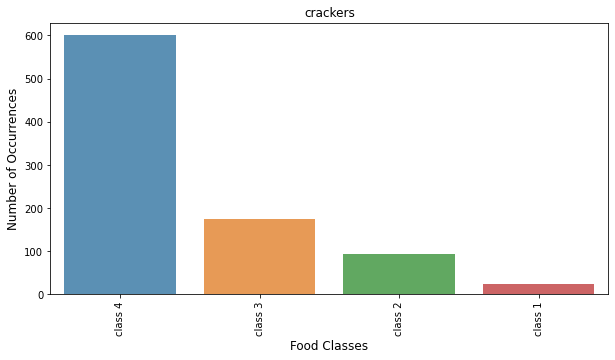

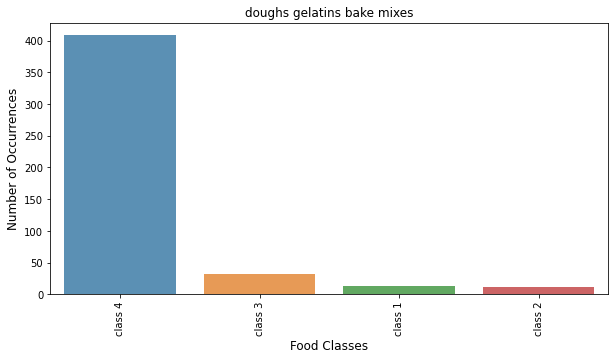

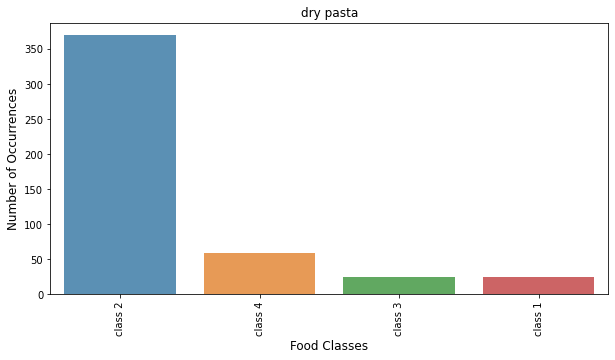

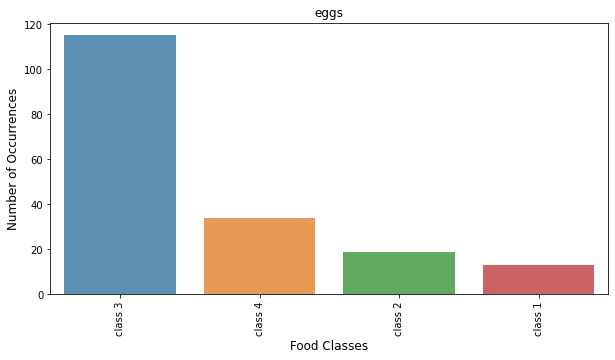

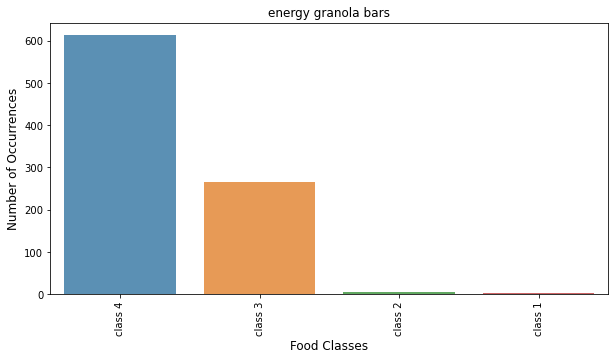

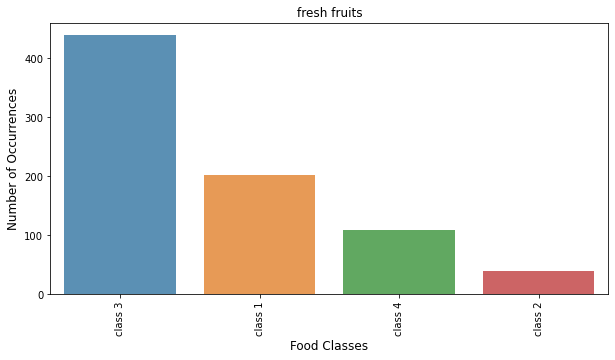

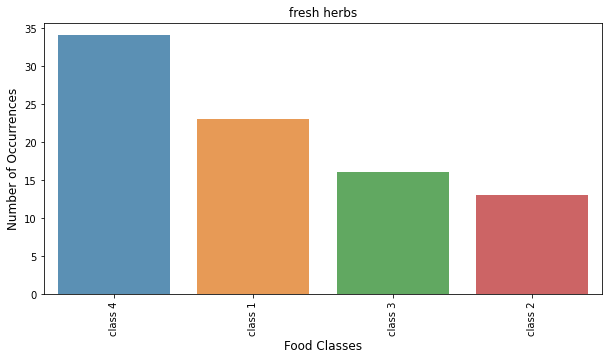

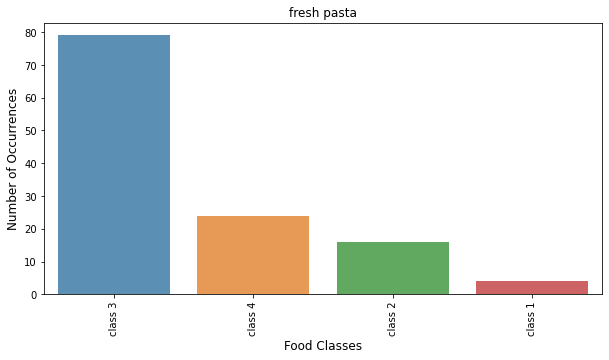

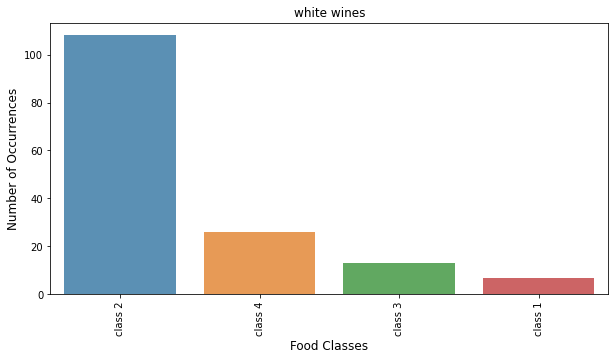

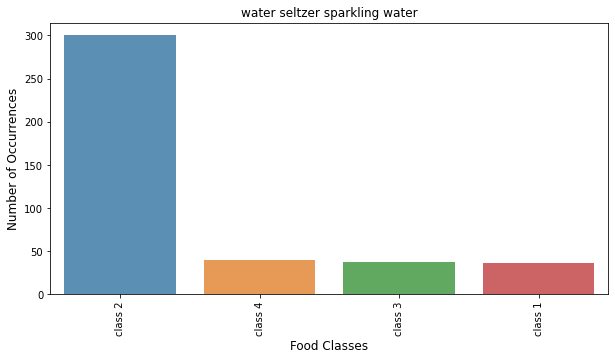

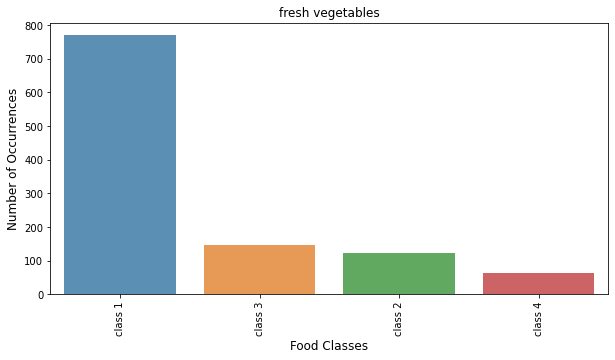

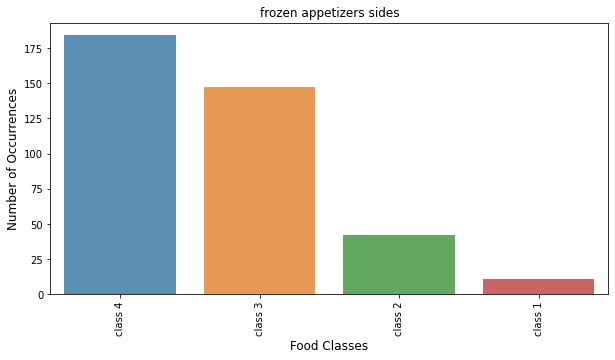

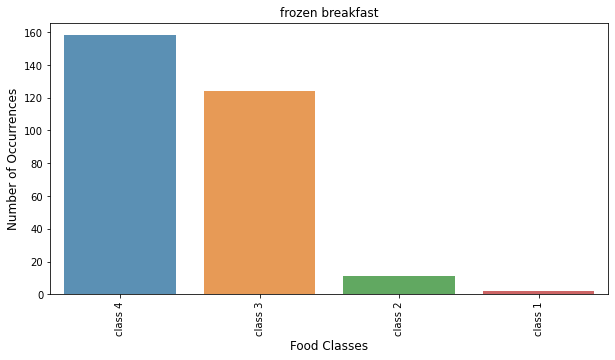

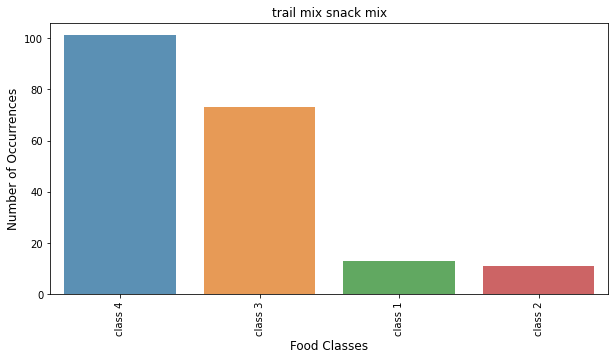

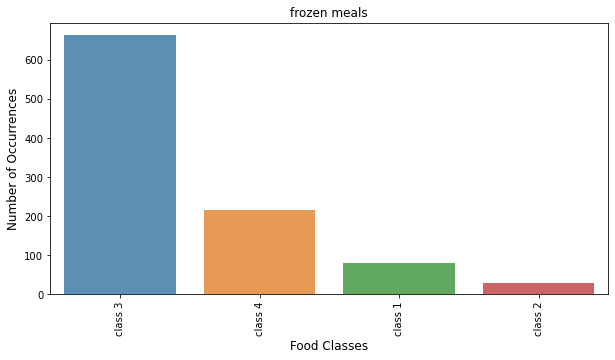

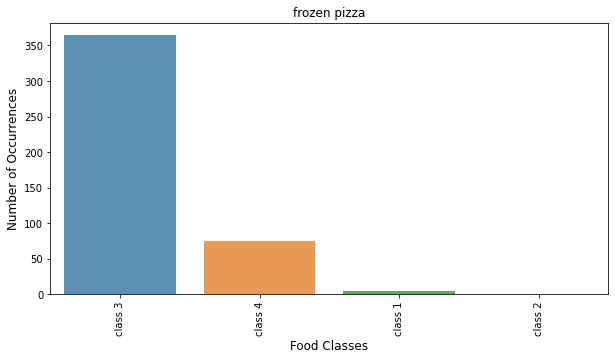

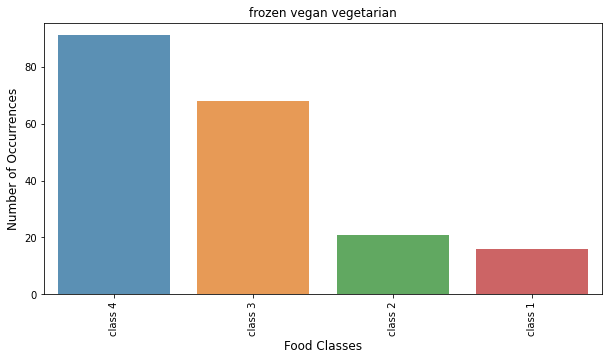

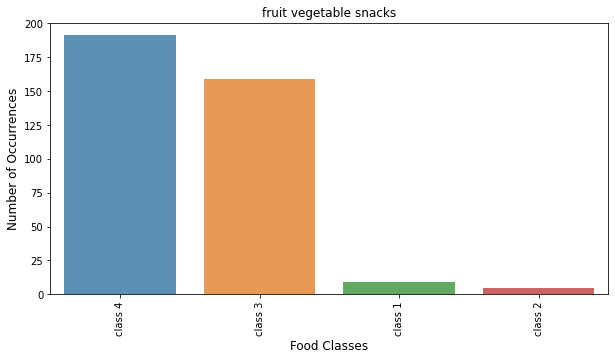

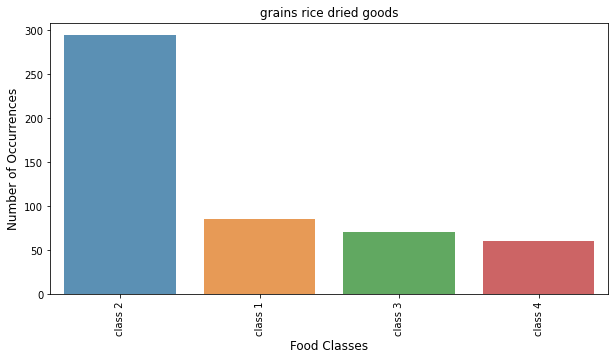

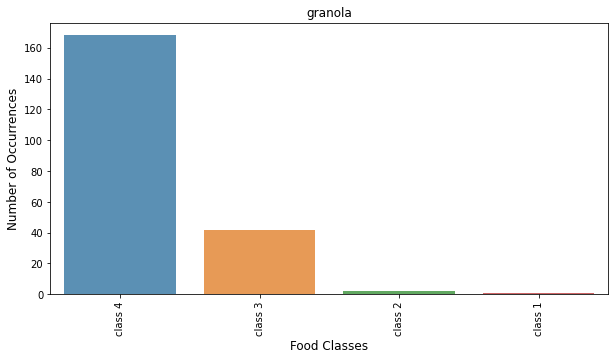

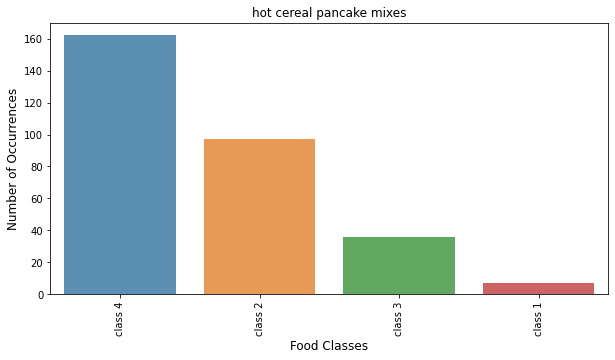

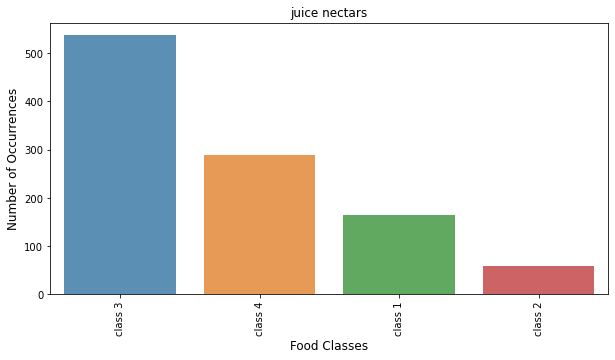

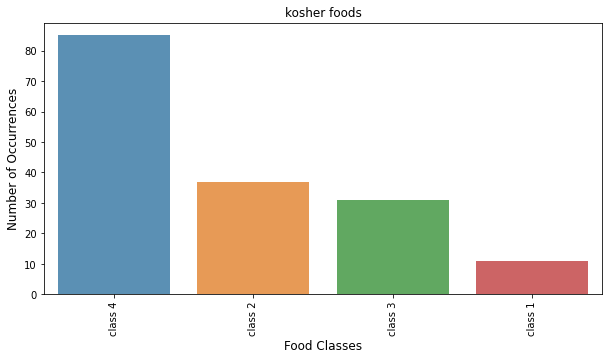

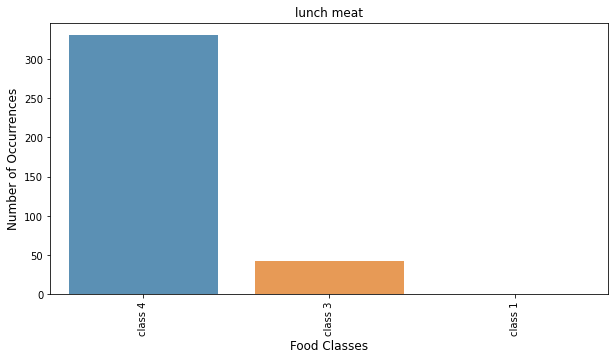

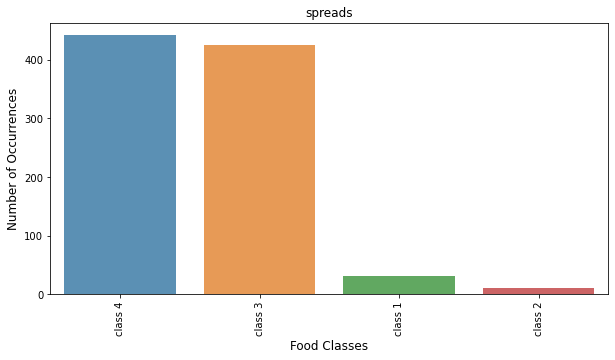

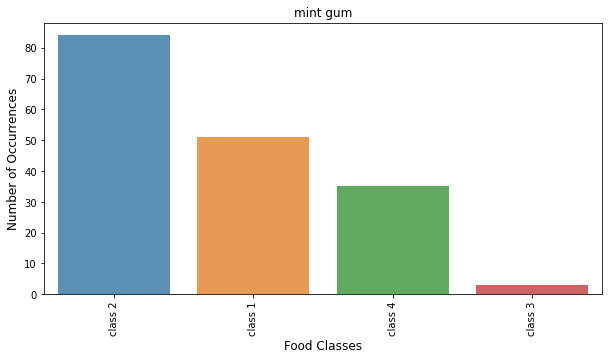

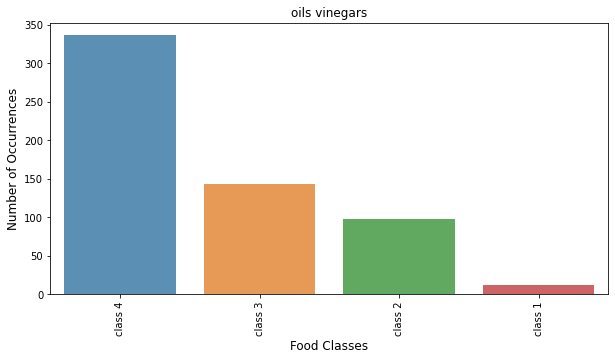

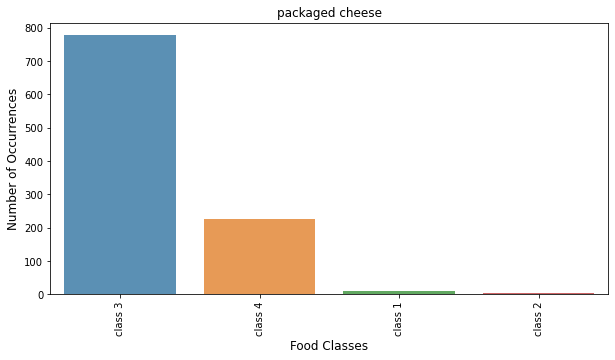

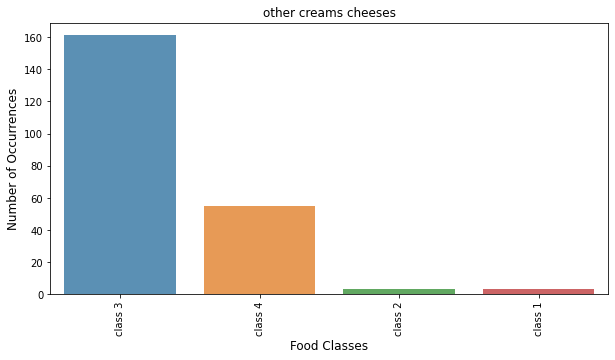

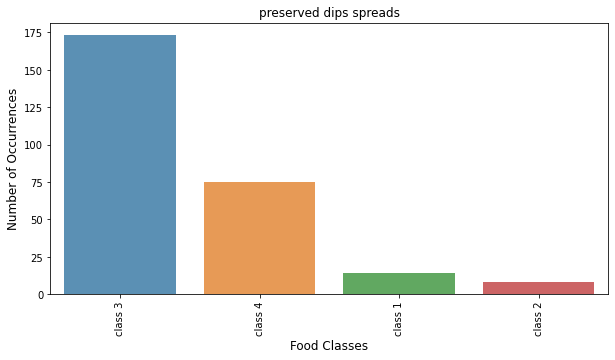

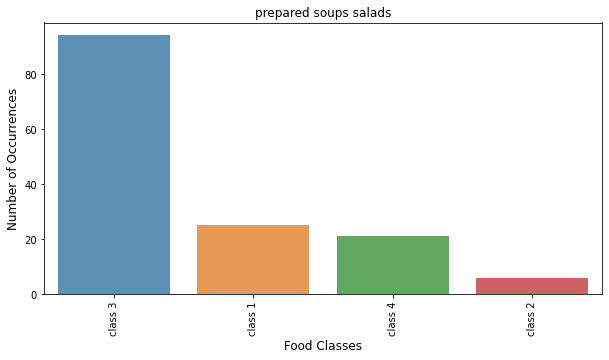

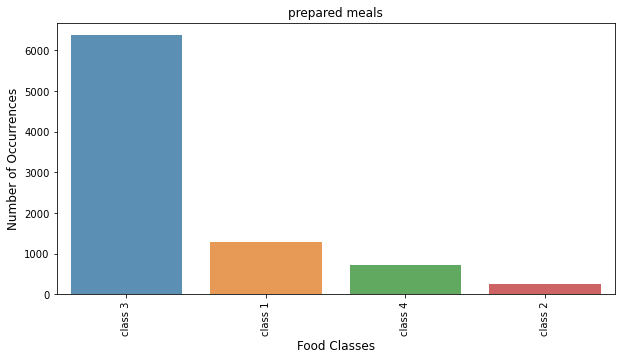

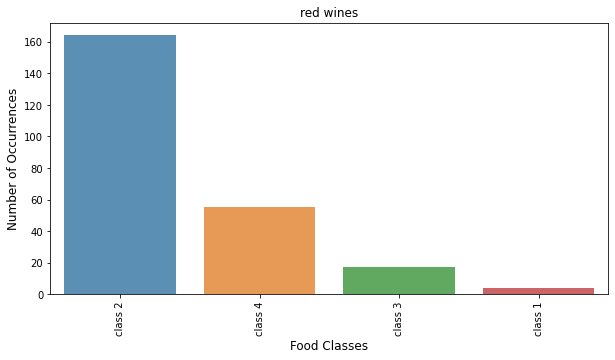

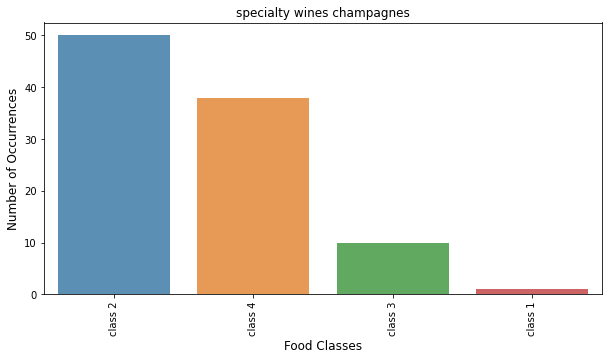

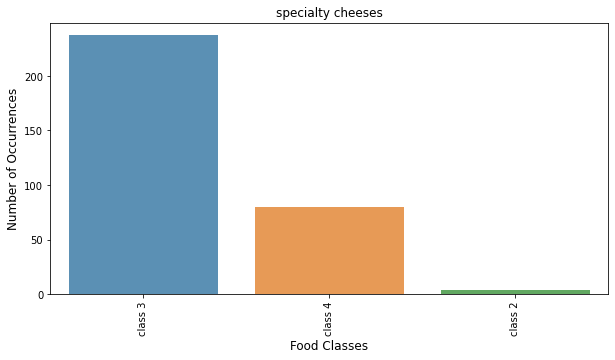

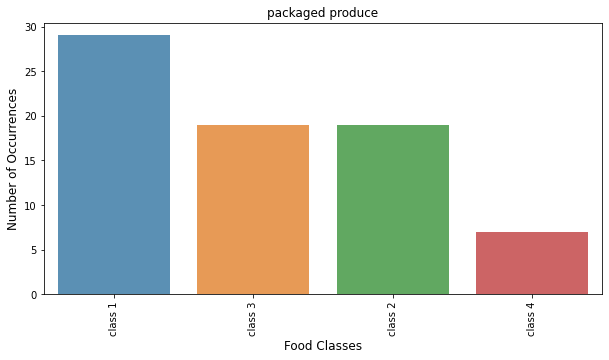

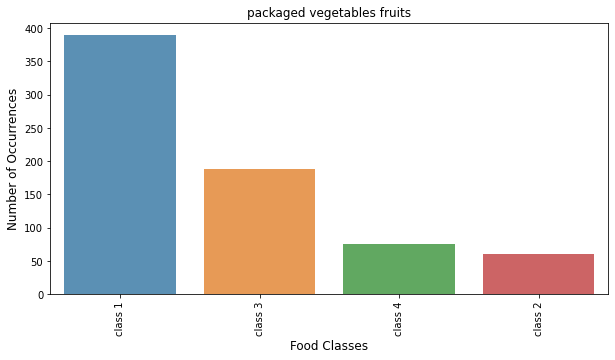

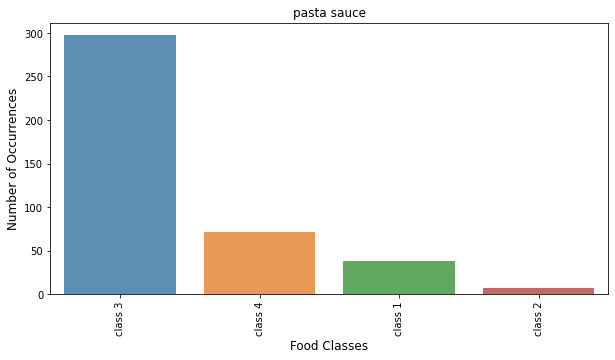

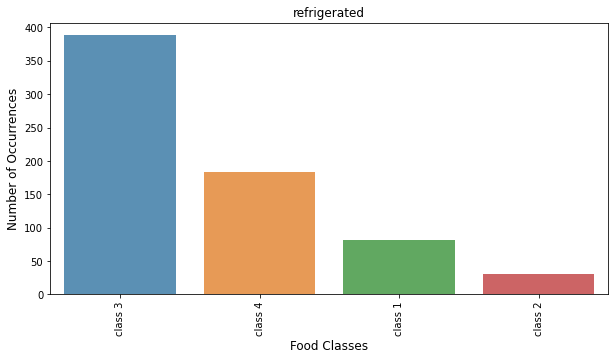

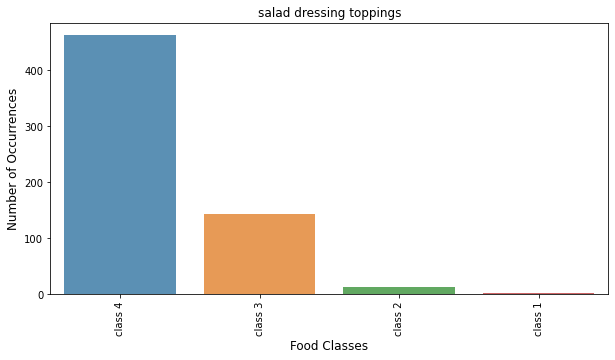

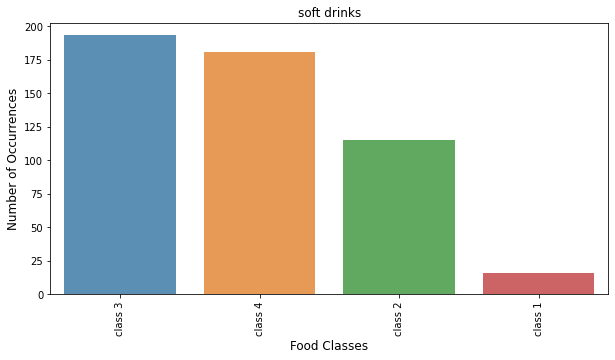

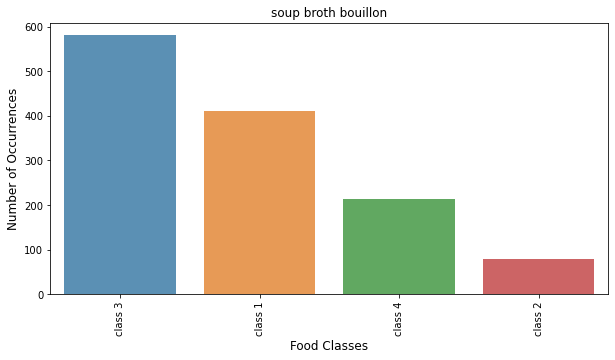

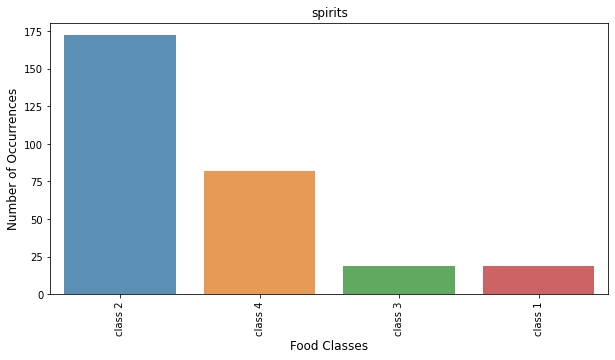

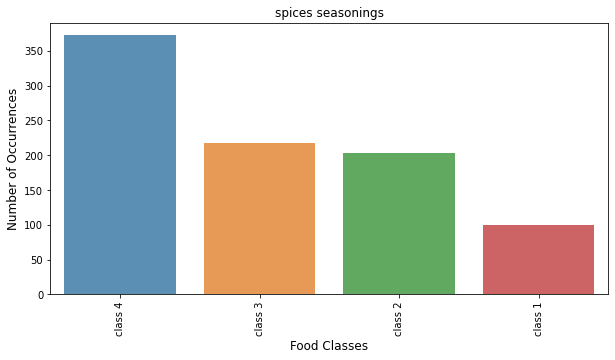

In [28]:
for aisle_name in data['aisle'].unique():
    plot_barplot(data, aisle_name, 'Food Class corrected', 'Food Classes')

### Make a 10 point system for SAIN LIM score

In [29]:
def get_food_points(val, points_df):
    '''This function returns raw 10 points of each nutrient type for perticular food item'''
    for row in points_df.iterrows():
        row_val = row[1].values
        low_bd  = row_val[1]
        up_bd   = row_val[2]
        if pd.isnull(val):
            return(0)
        elif val >= low_bd and val <= up_bd:
            return (int(row_val[0]))

In [30]:
quant_arr_sain        = [0., 0.167, 0.334,  0.501,  0.668, 0.835, 1] 
sain_quant       = data['SAIN log score'].quantile(quant_arr_sain).values
sain             = pd.DataFrame(columns = ['Points', 'sain_lower_bd', 'sain_up_bd'])
sain['Points']         = np.array([0, 1, 2, 3, 4, 5]) # higher sain, higher points [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sain['sain_lower_bd']  = np.array(list(sain_quant[0:6]))
sain['sain_up_bd']     = np.array(list(sain_quant[1:7]))

In [31]:
data['SAIN points'] = data['SAIN log score'].apply(lambda x: get_food_points(x, sain))

### SAIN score distribution of each aisle 

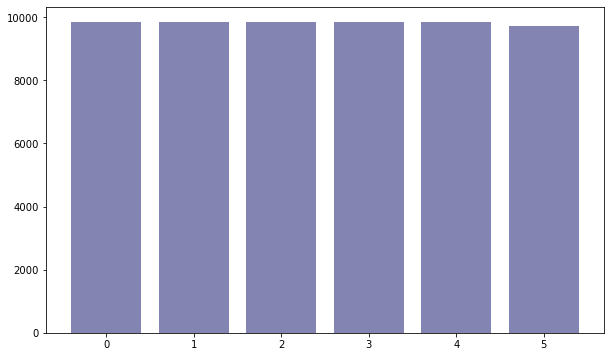

In [27]:
sain_df = pd.DataFrame(data['SAIN points'].value_counts()).reset_index()
sain_df.columns=['SAIN point scale', 'Count']
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
plt.bar(sain_df['SAIN point scale'],sain_df['Count'], color = (0.2,0.2,0.5,0.6))
plt.show()

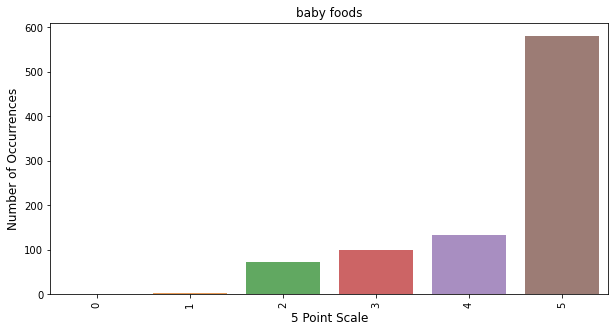

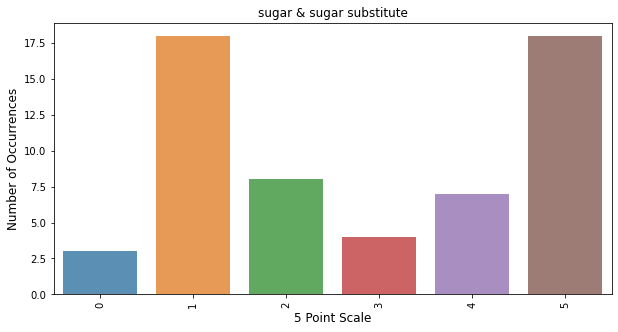

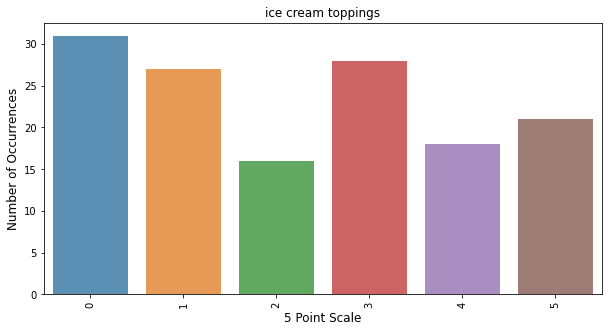

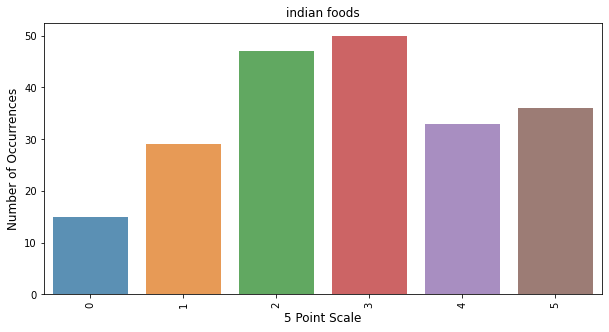

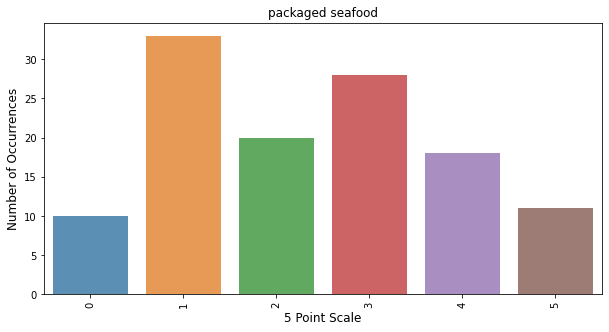

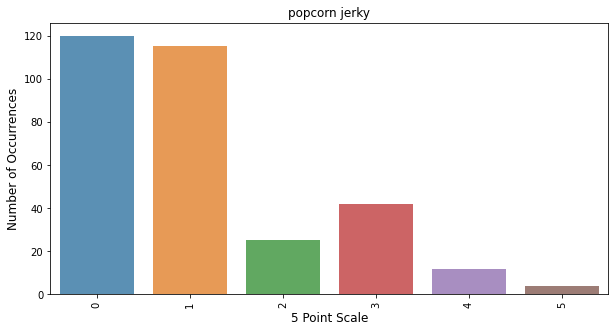

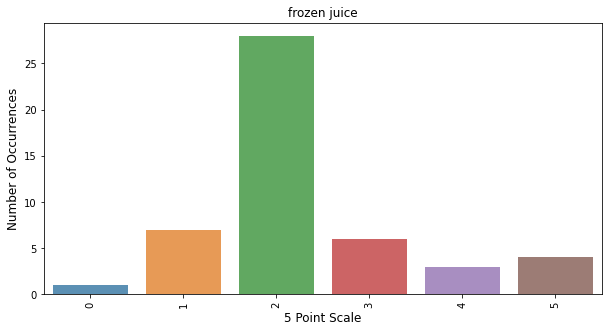

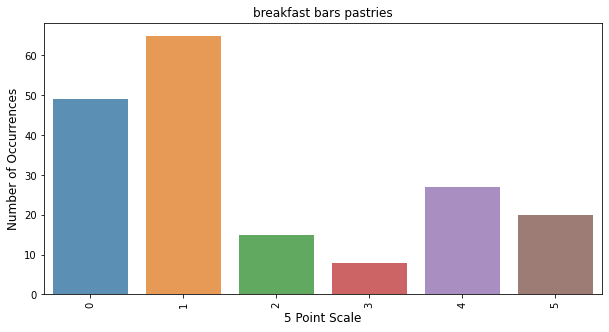

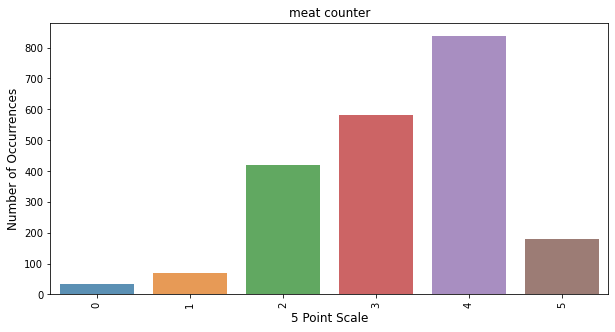

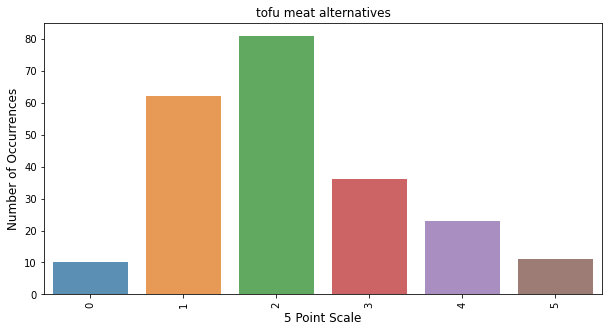

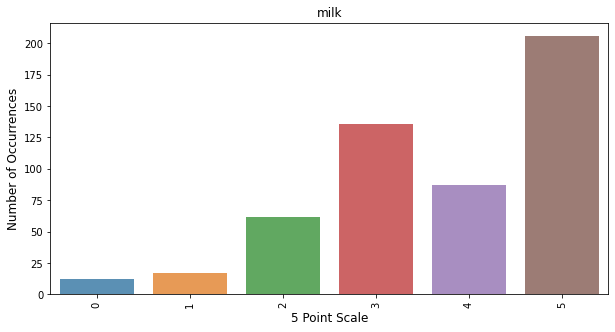

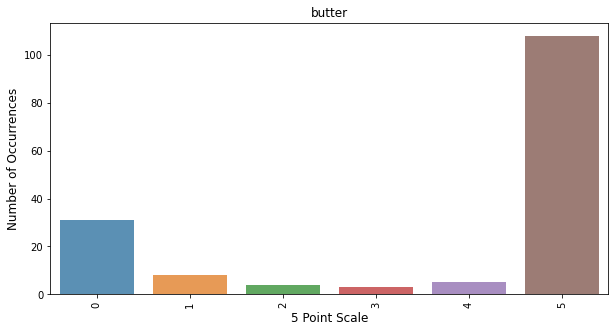

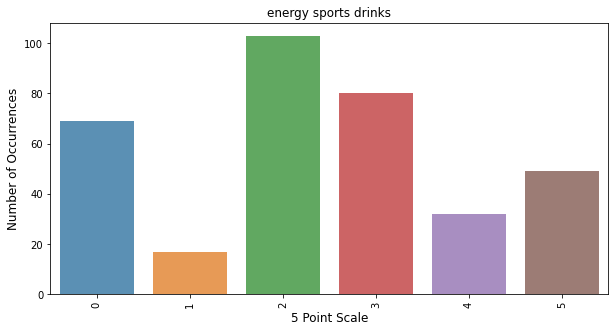

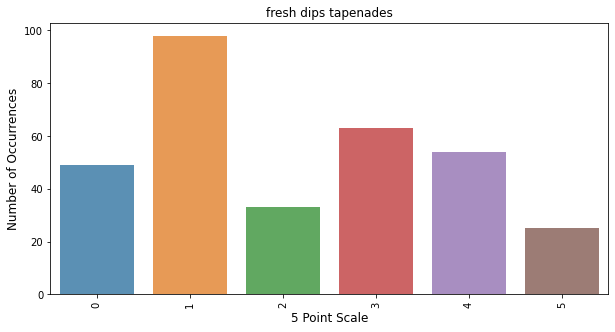

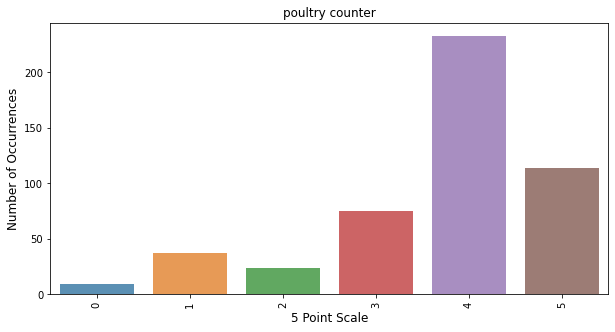

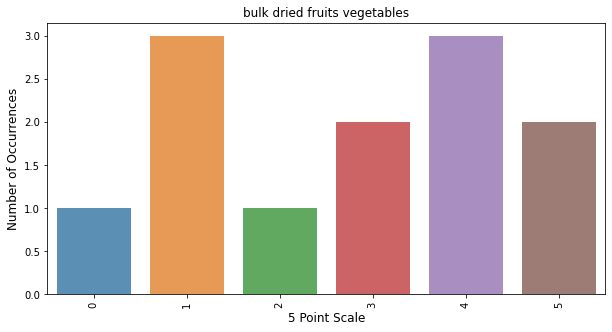

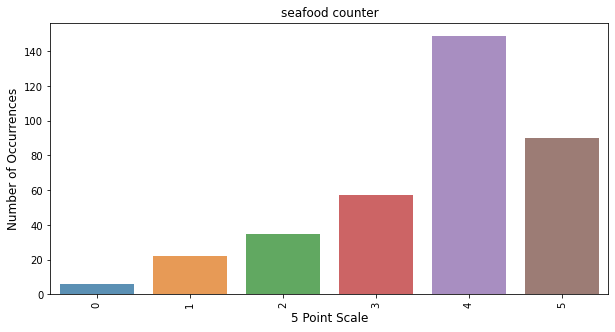

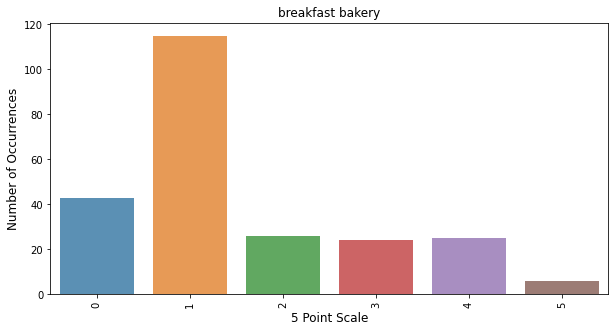

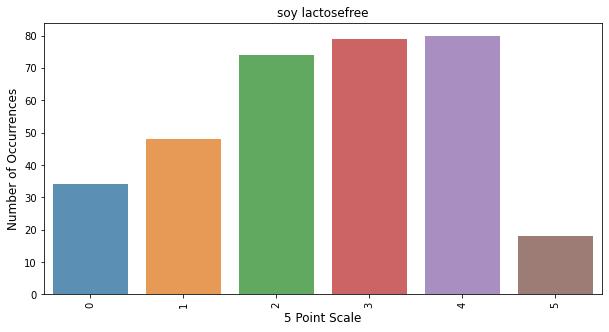

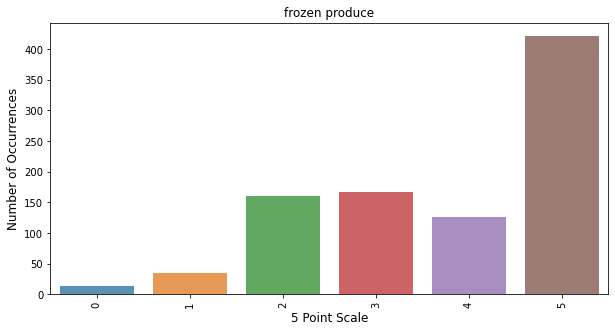

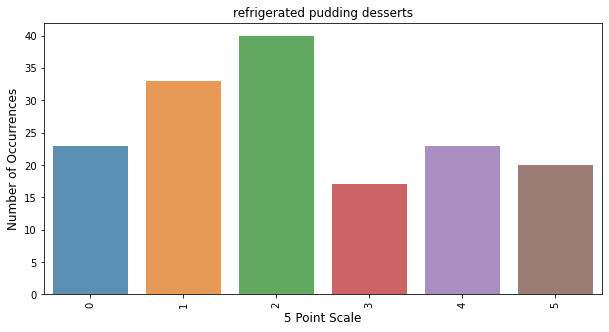

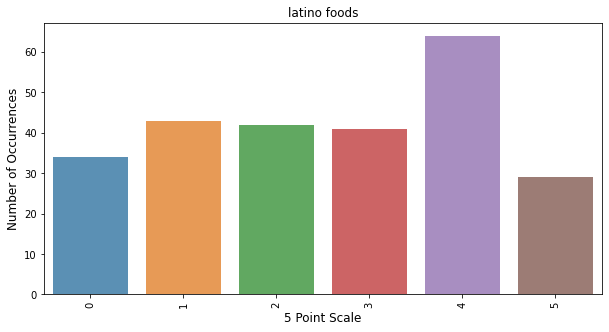

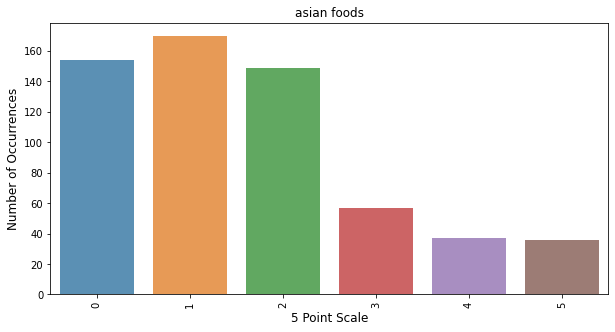

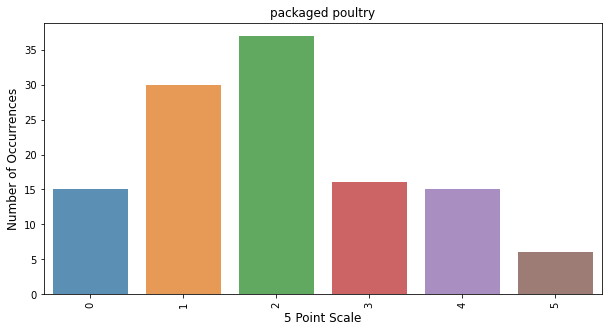

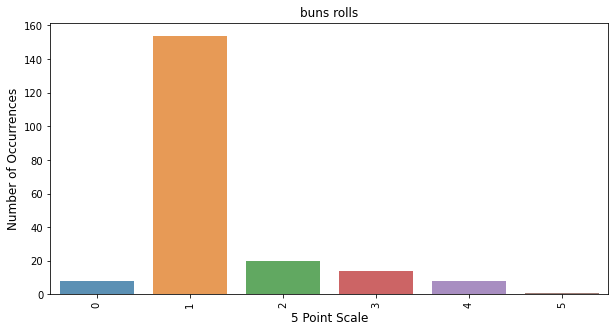

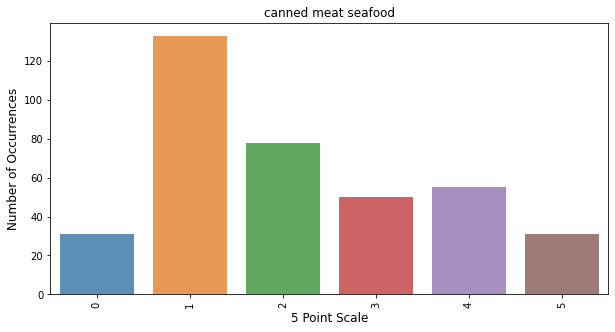

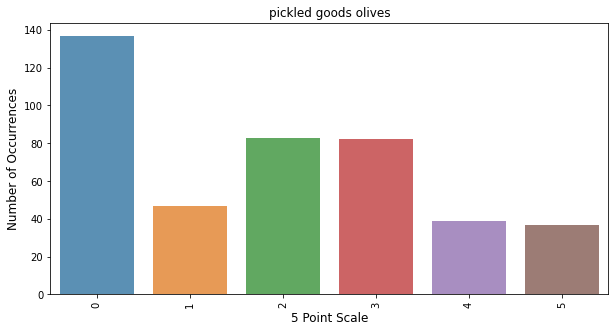

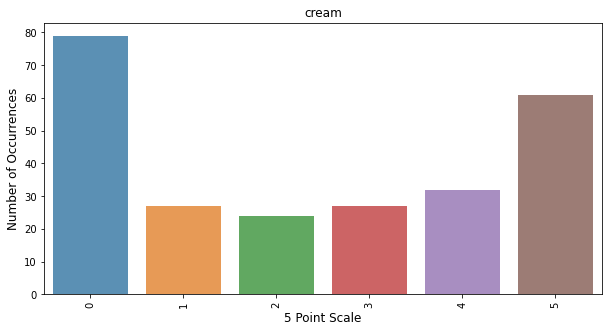

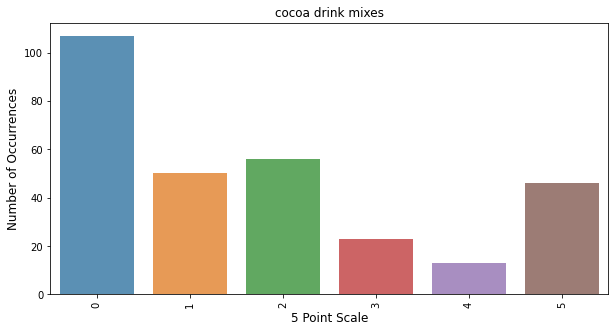

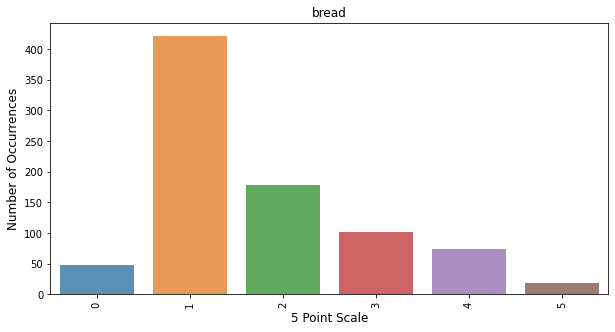

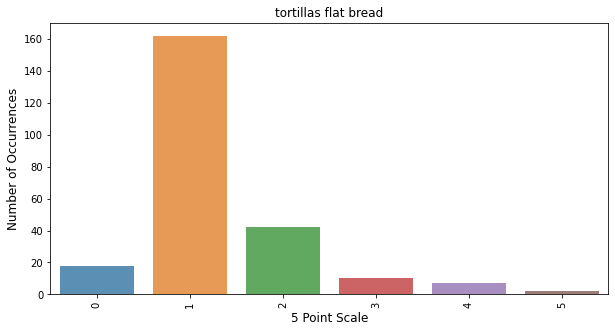

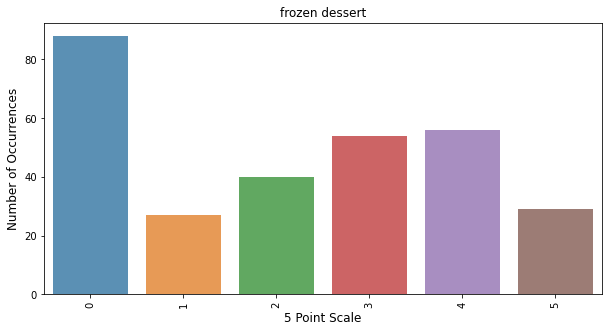

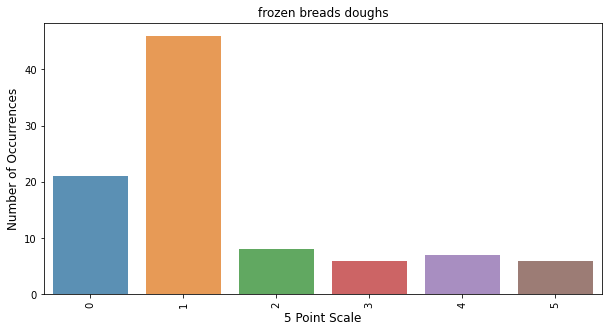

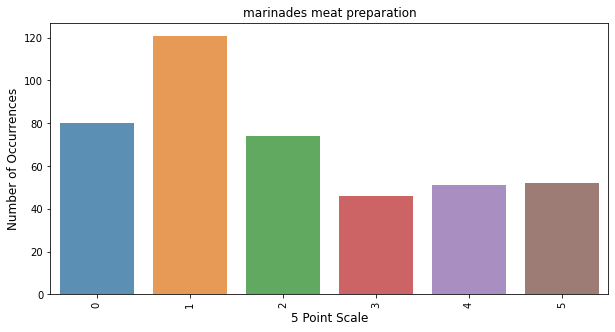

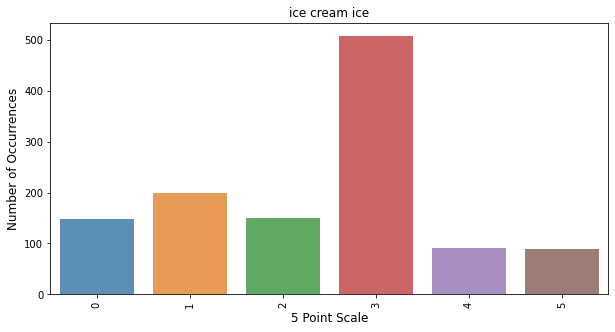

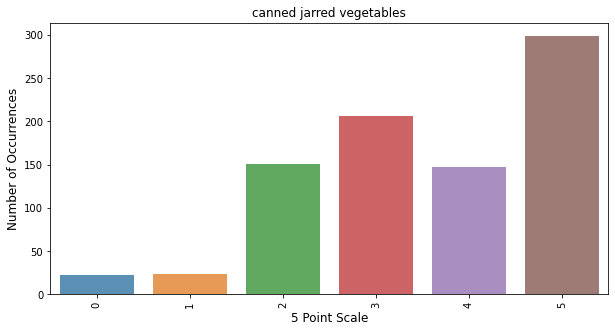

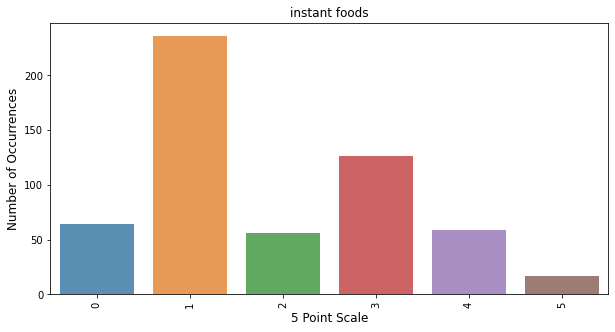

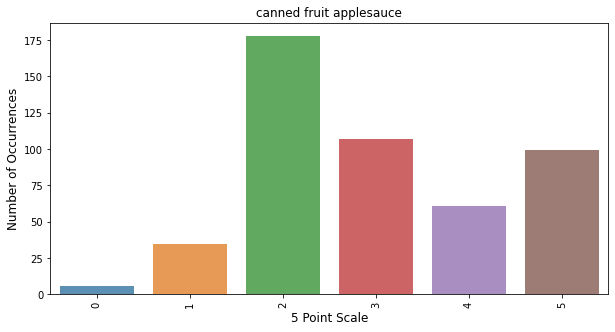

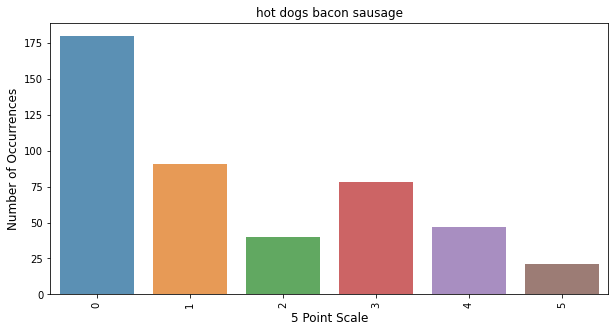

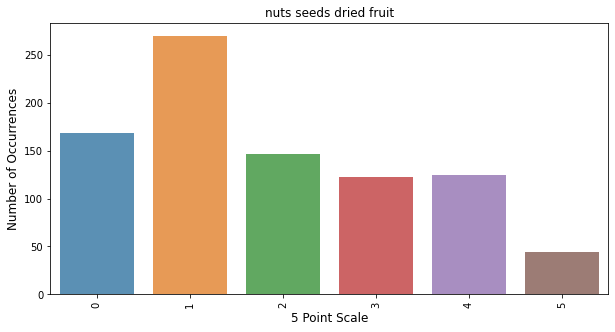

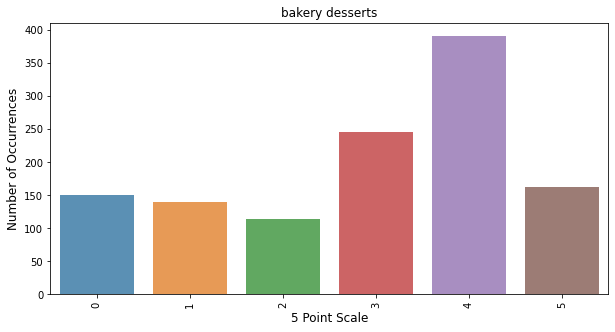

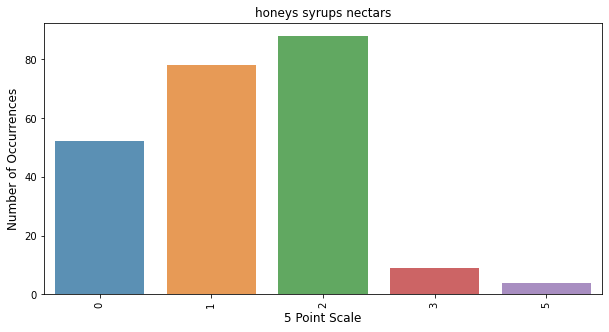

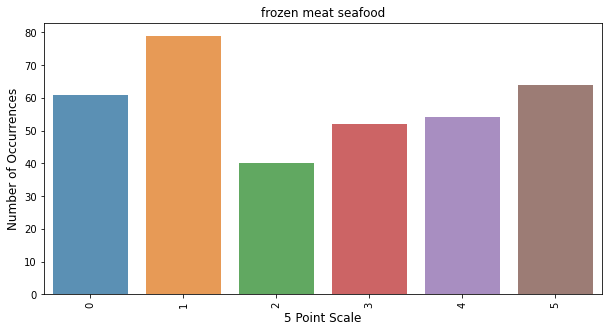

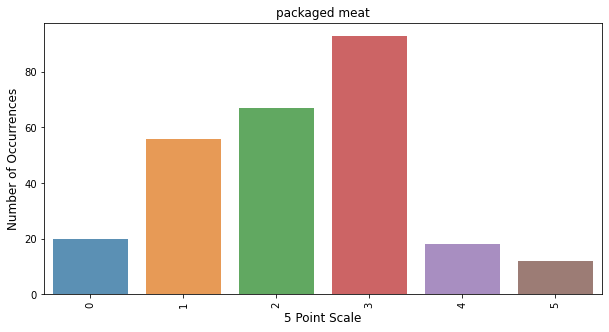

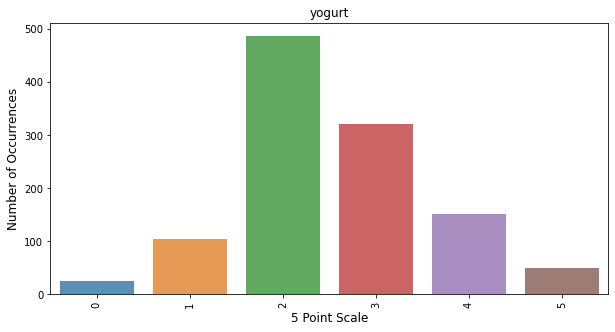

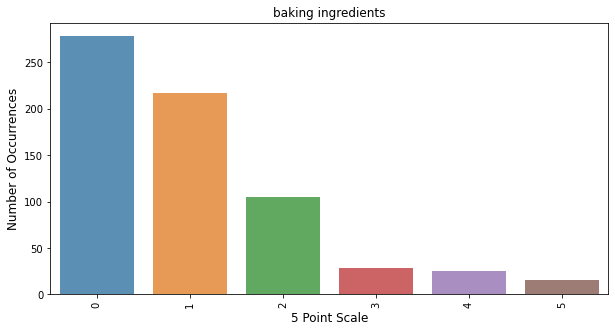

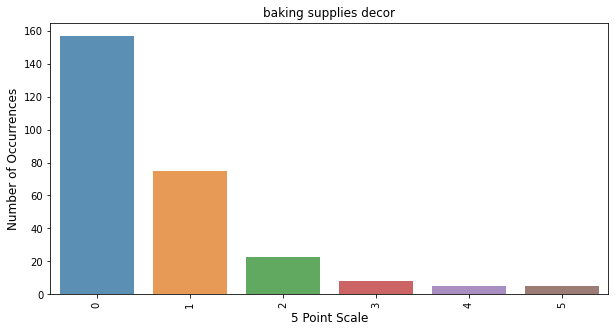

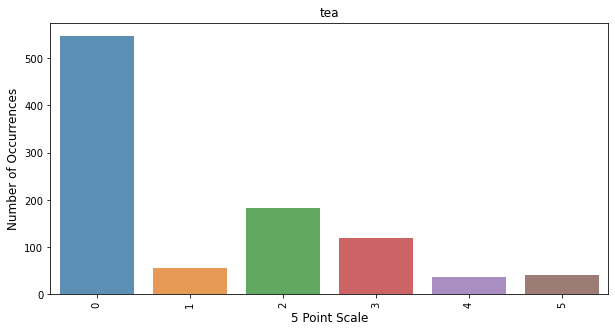

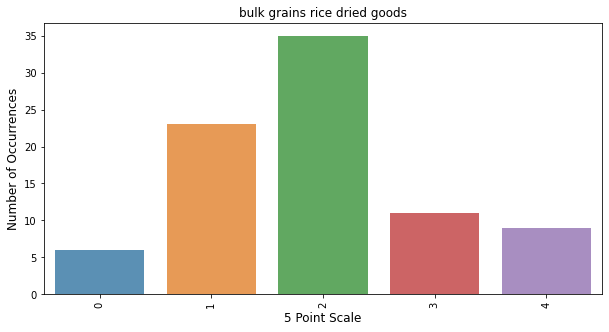

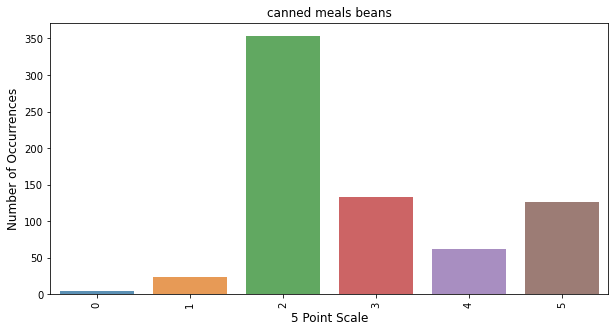

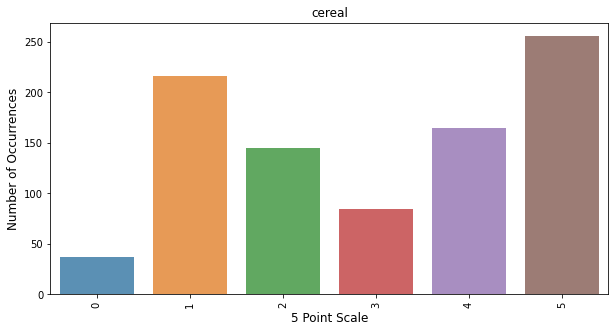

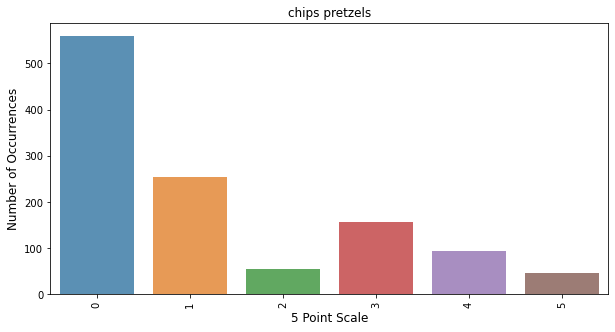

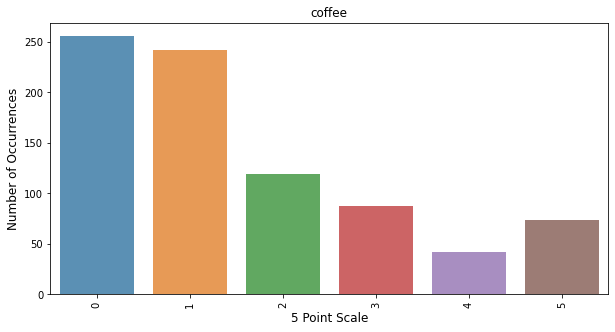

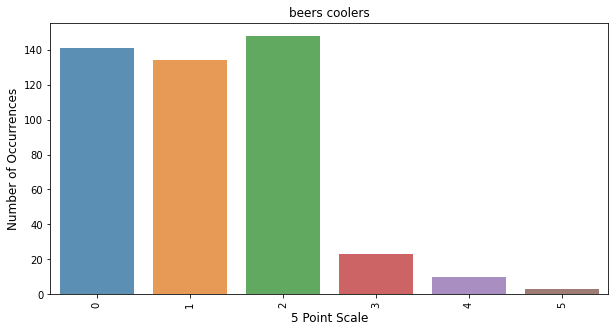

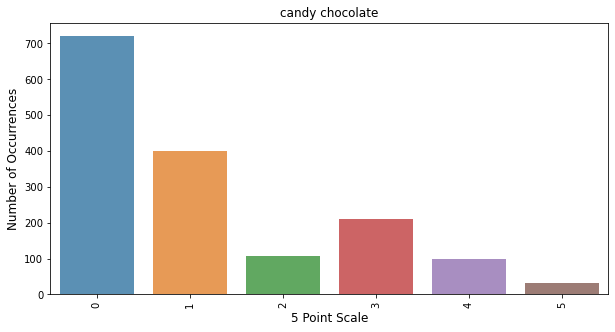

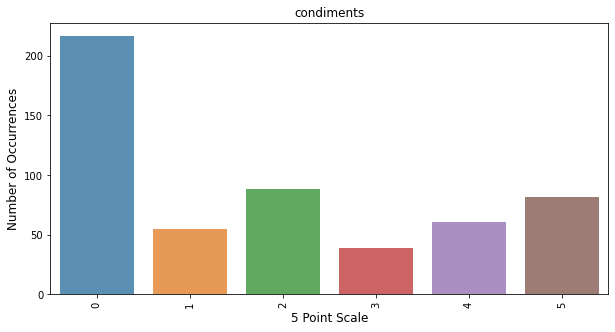

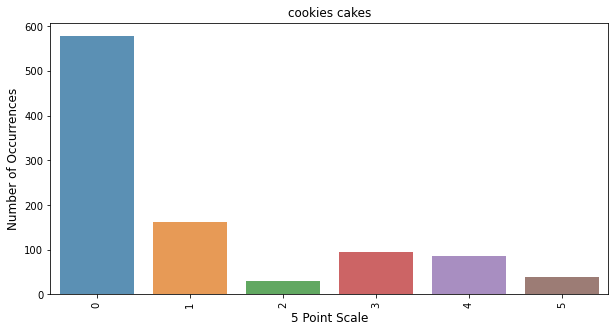

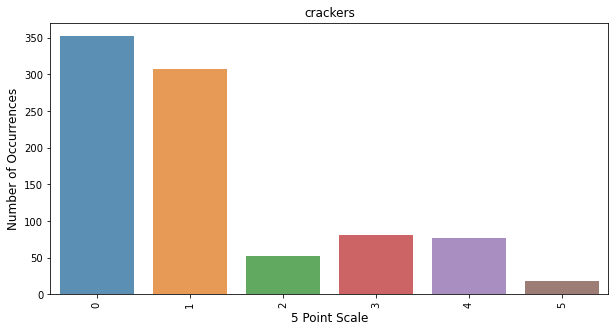

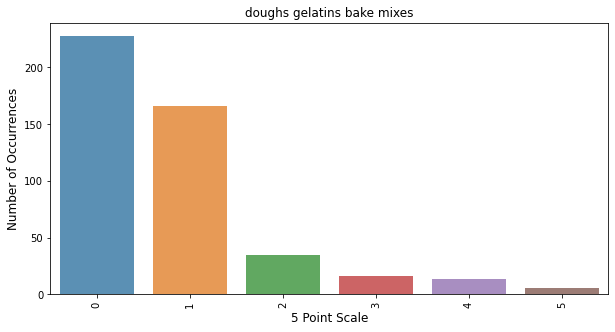

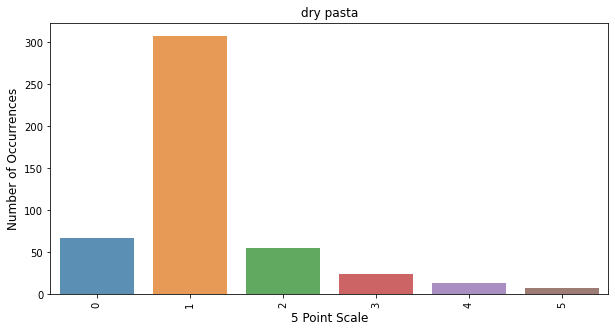

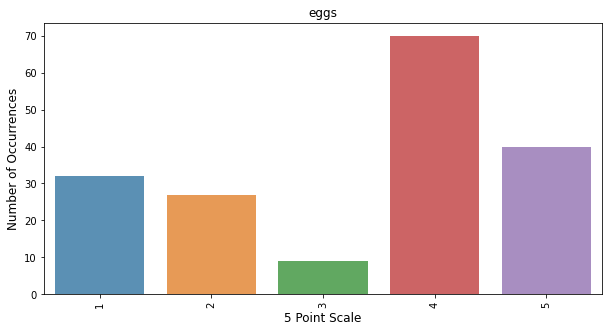

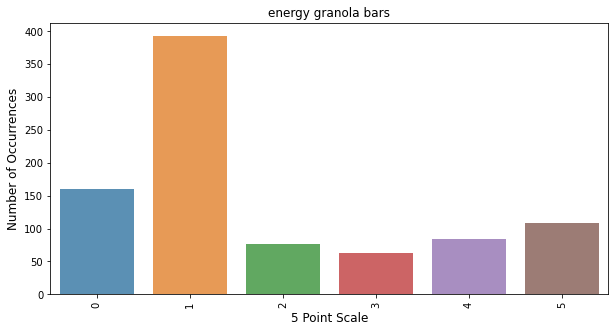

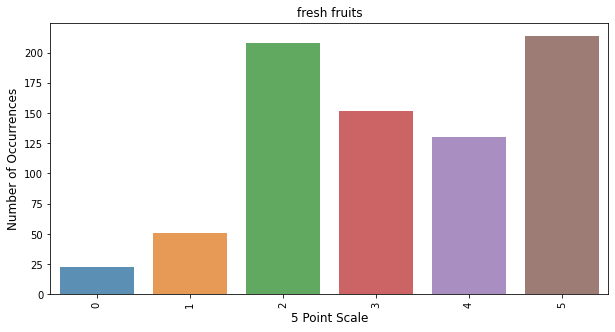

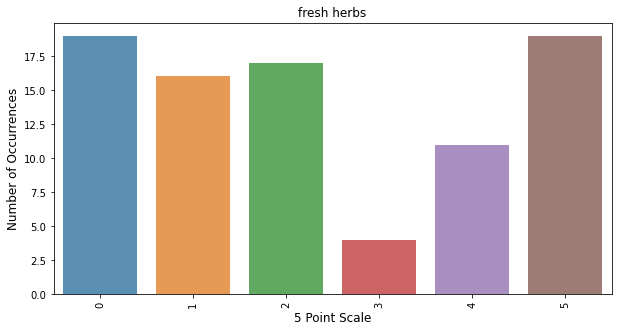

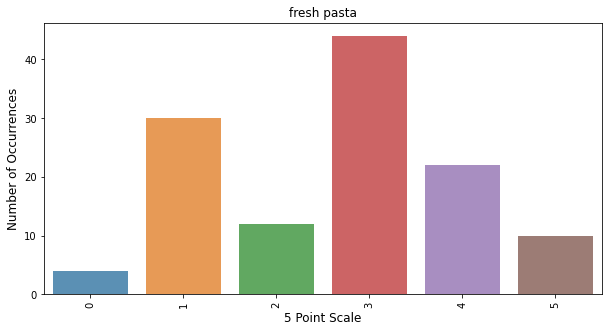

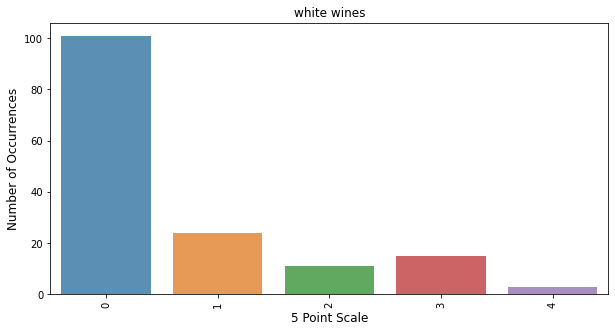

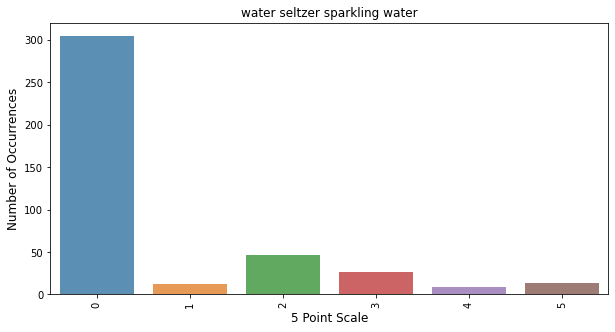

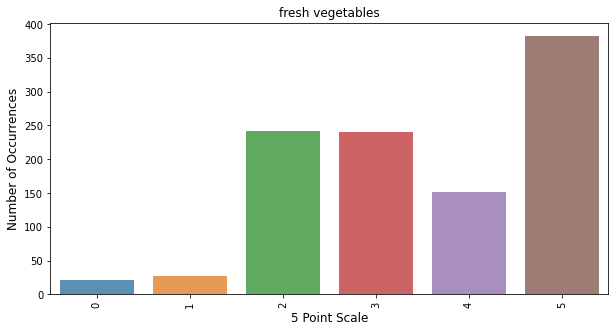

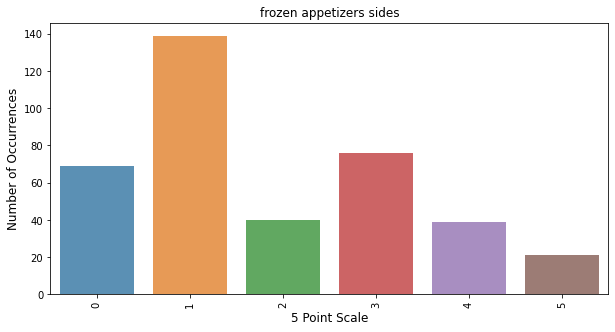

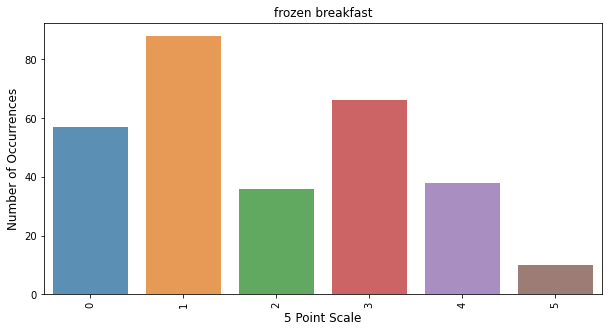

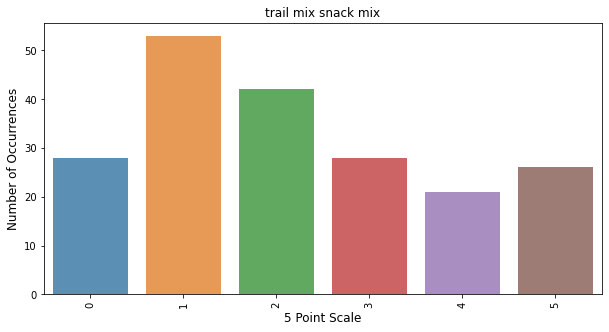

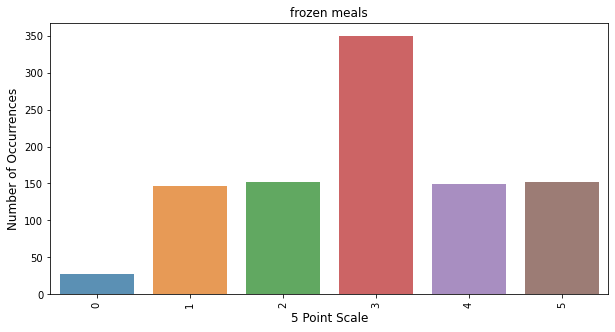

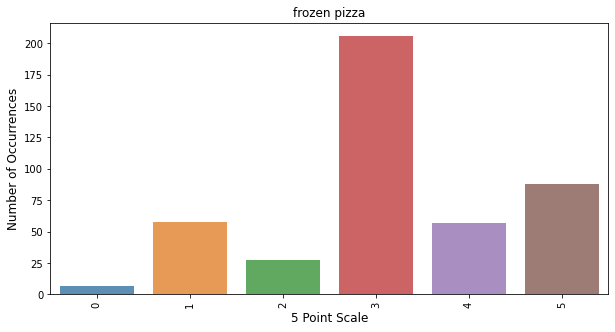

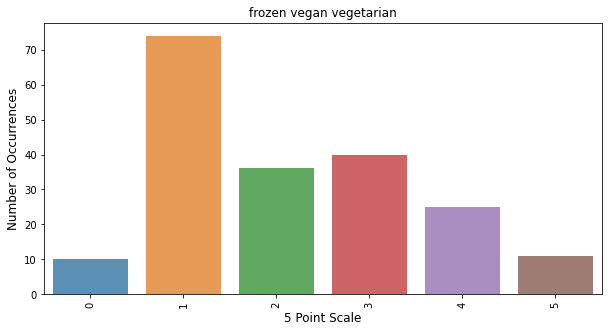

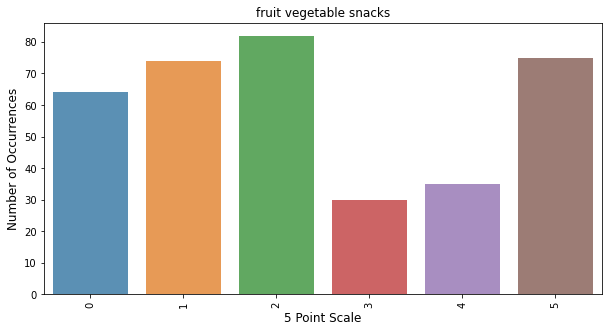

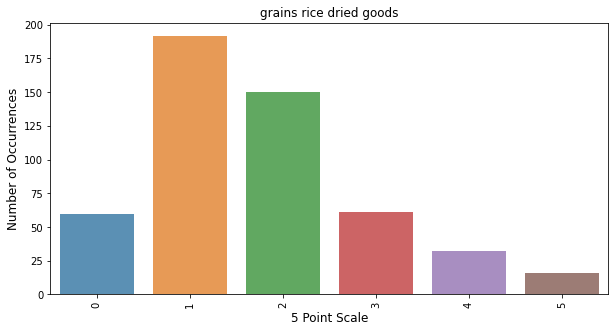

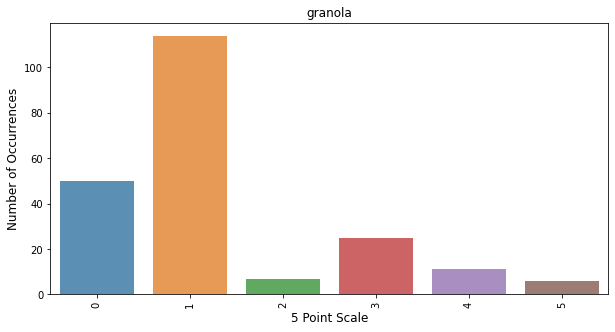

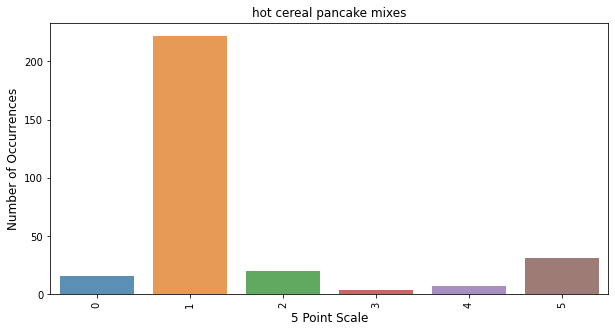

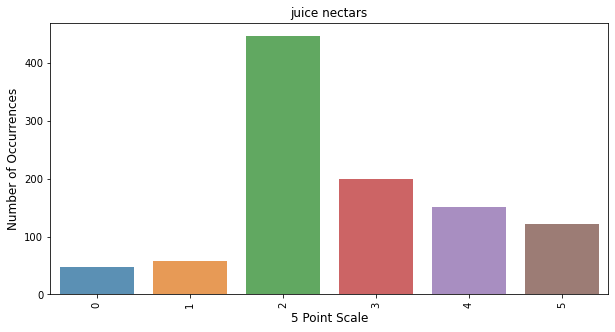

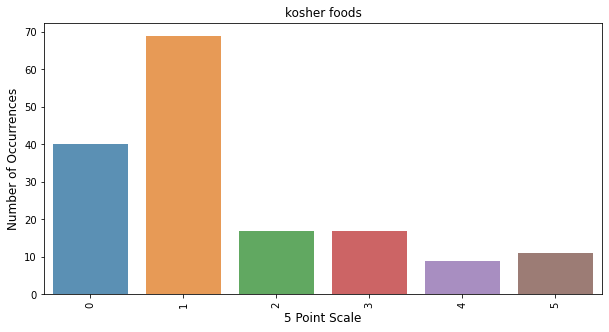

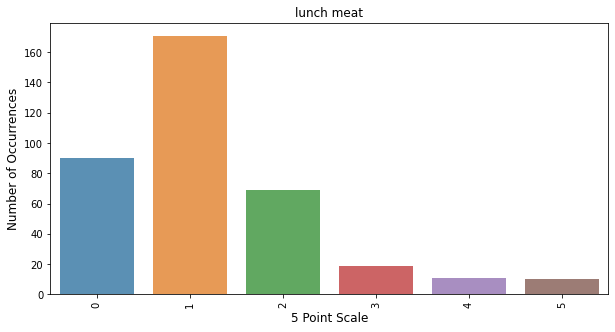

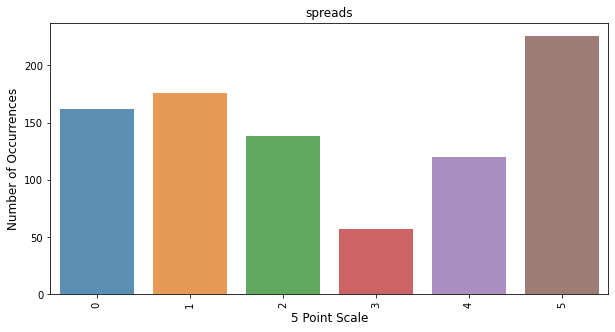

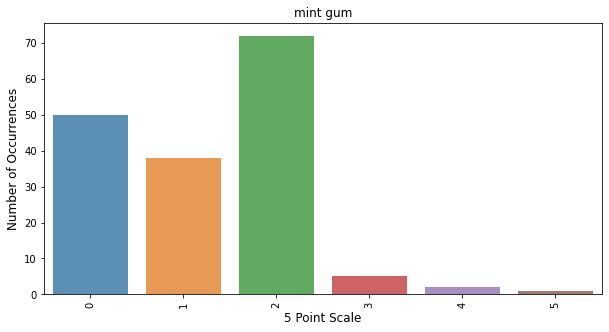

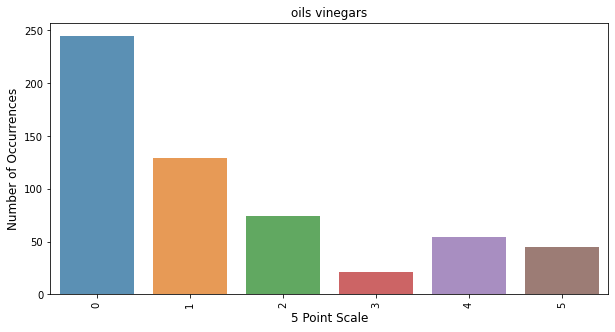

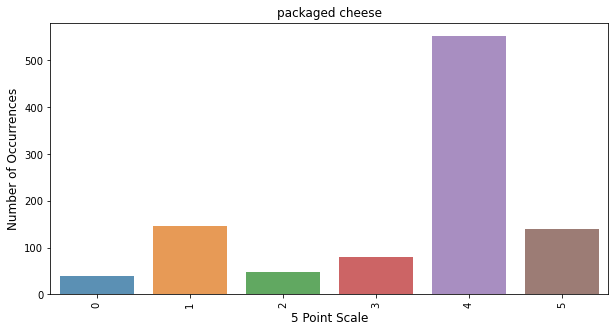

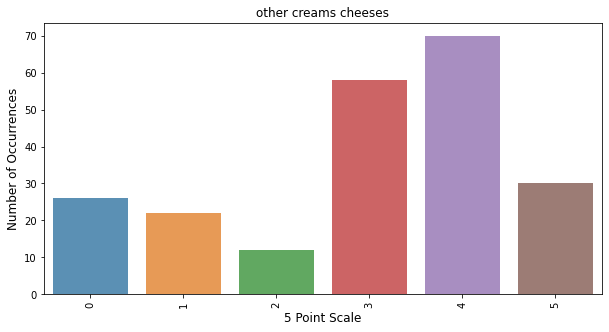

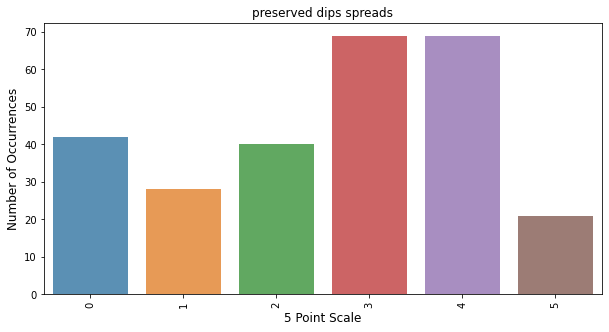

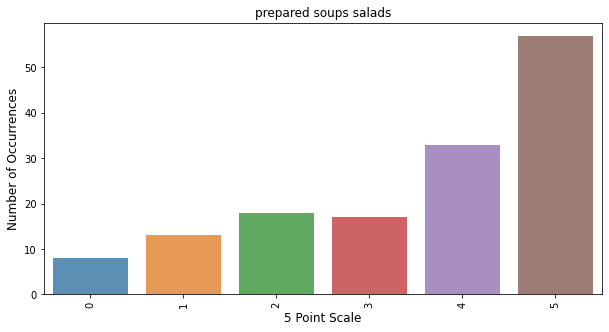

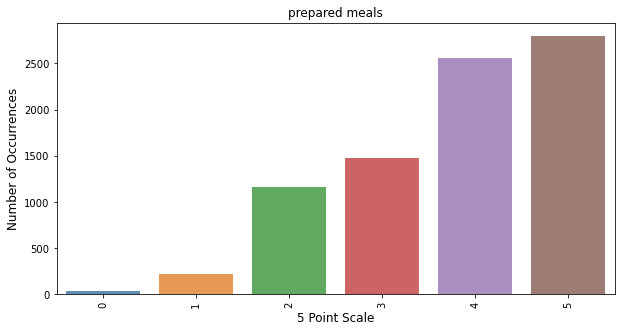

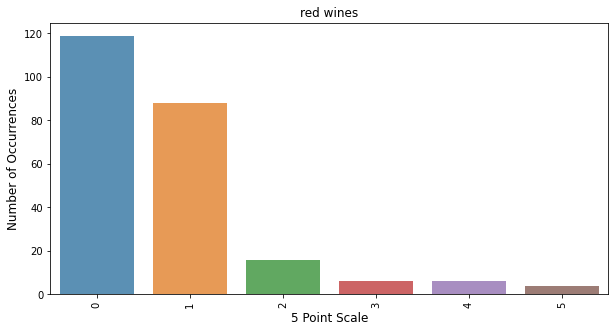

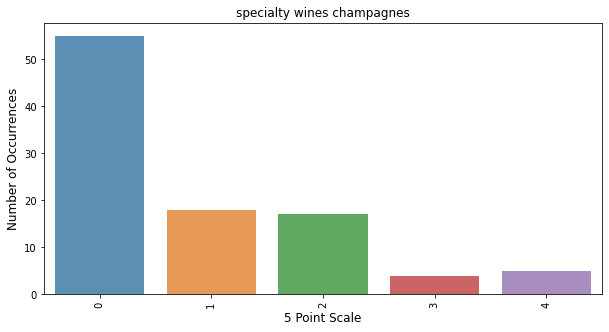

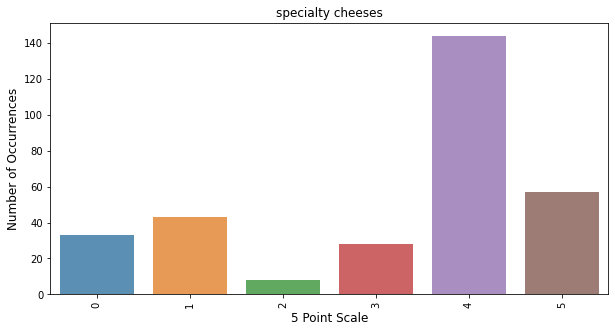

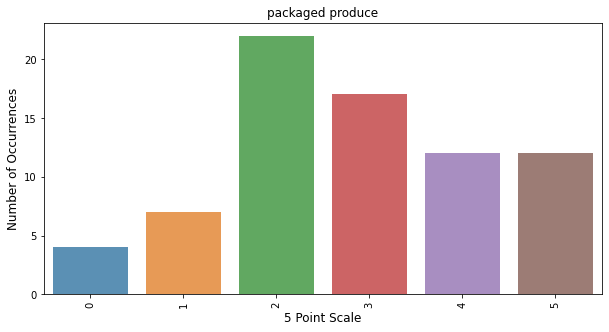

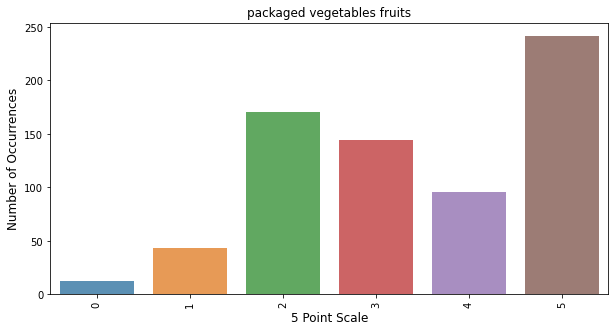

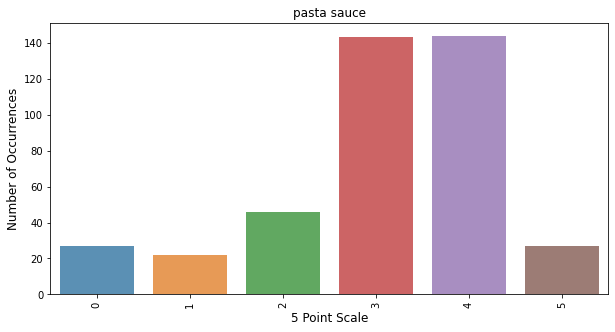

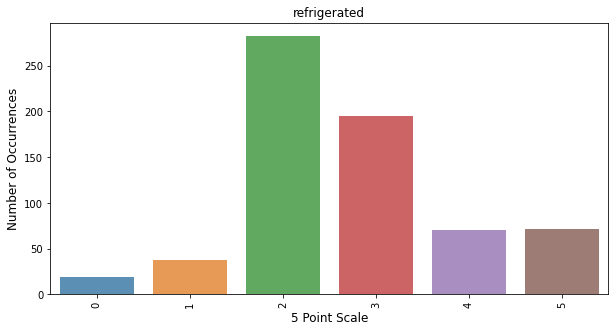

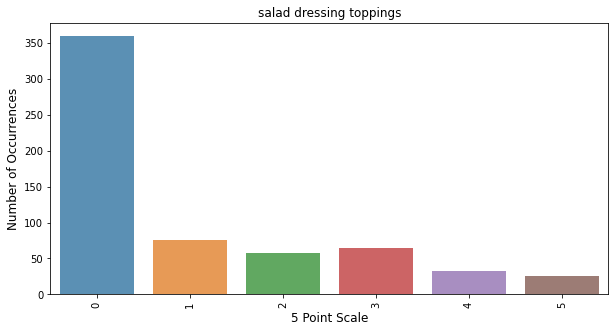

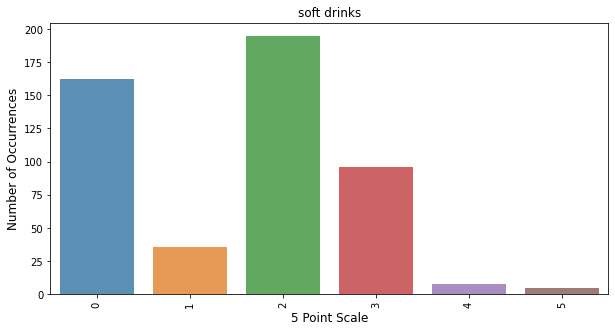

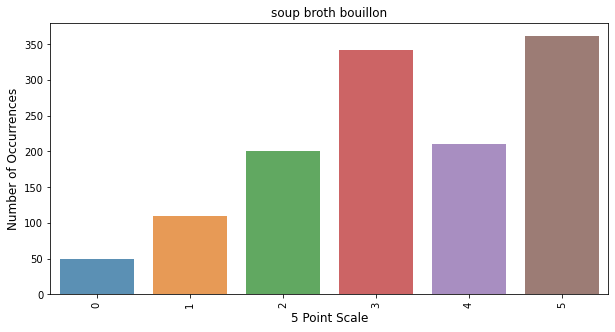

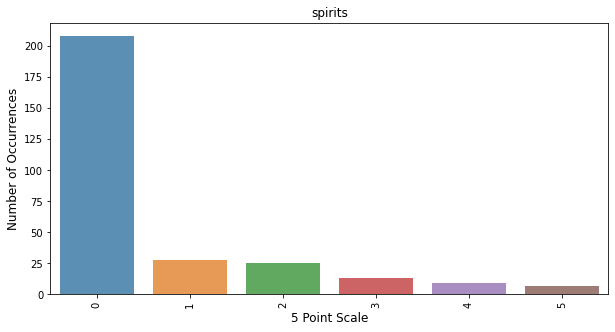

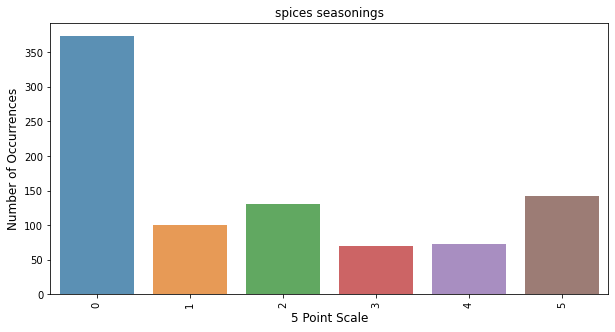

In [73]:
for aisle_name in data['aisle'].unique():
    plot_barplot(data, aisle_name, 'SAIN points', '5 Point Scale')

### LIM score distribution of each aisle 

In [34]:
quant_arr_lim  = [0., 0.167, 0.334,  0.501,  0.668, 0.835, 1]#[0., 0.276, 0.368, 0.552, 0.736, 0.92 , 1] # make it same
lim_quant = data['LIM log score'].quantile(quant_arr_lim).values
lim       = pd.DataFrame(columns = ['Points', 'lim_lower_bd', 'lim_up_bd'])
lim['Points']         = np.array([5, 4, 3, 2, 1, 0]) # lower lim, higher points [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
lim['lim_lower_bd']   = np.array(list(lim_quant[0:6]))
lim['lim_up_bd']      = np.array(list(lim_quant[1:7]))

In [35]:
data['LIM points'] = data['LIM log score'].apply(lambda x: get_food_points(x, lim))

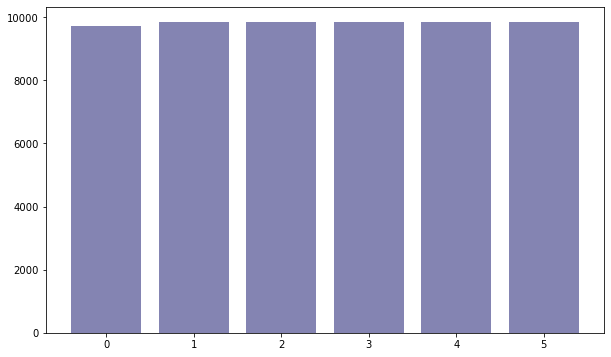

In [30]:
lim_df = pd.DataFrame(data['LIM points'].value_counts()).reset_index()
lim_df.columns=['LIM point scale', 'Count']
plt.figure(num=None, figsize=(10, 6), facecolor='w', edgecolor='k')
plt.bar(lim_df['LIM point scale'],lim_df['Count'], color = (0.2,0.2,0.5,0.6))
plt.show()

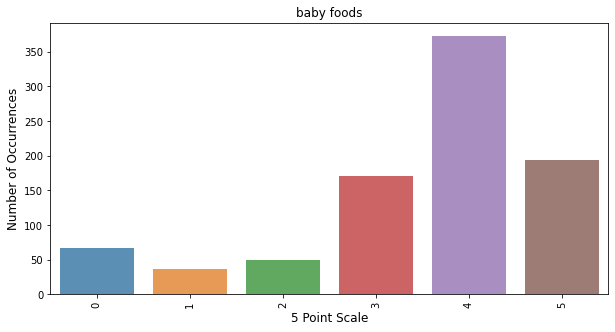

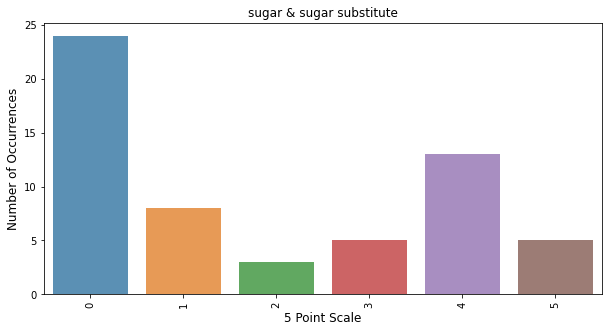

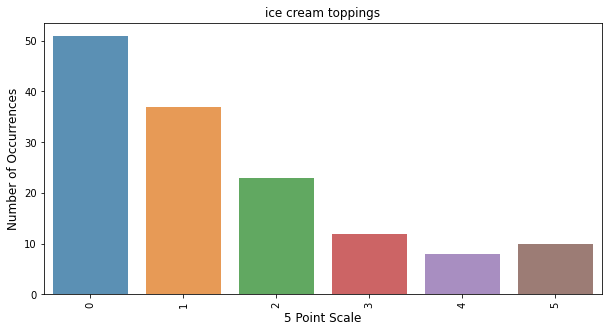

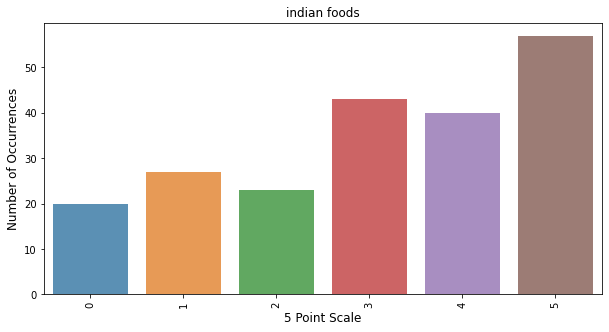

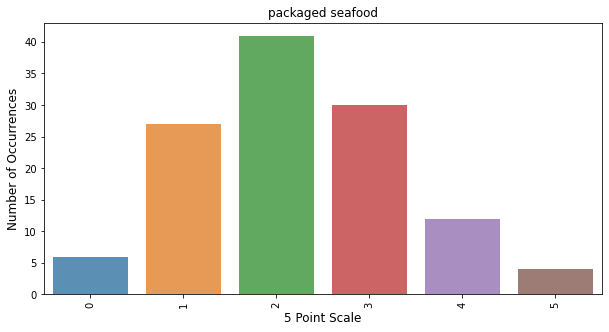

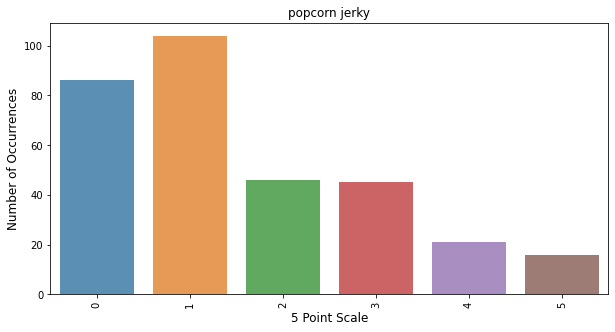

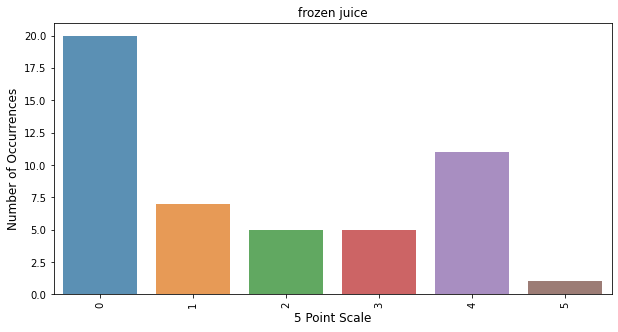

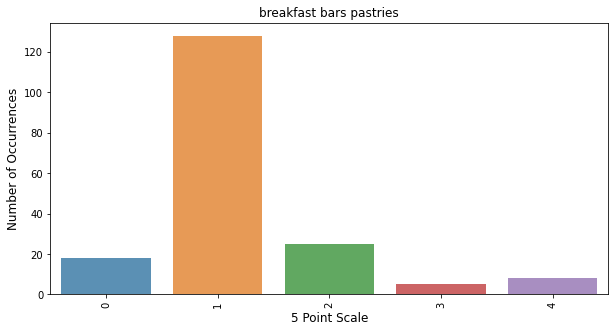

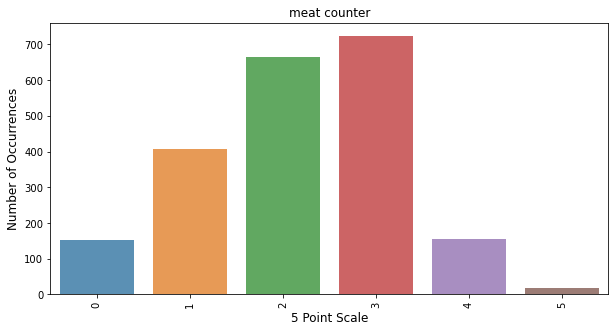

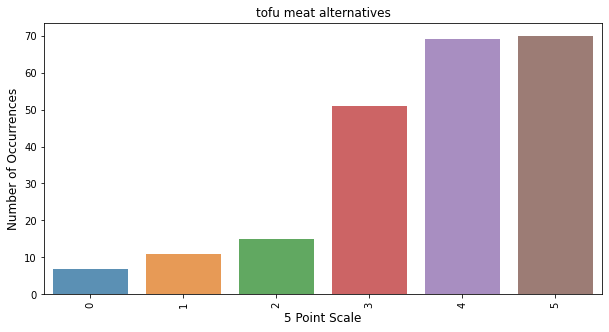

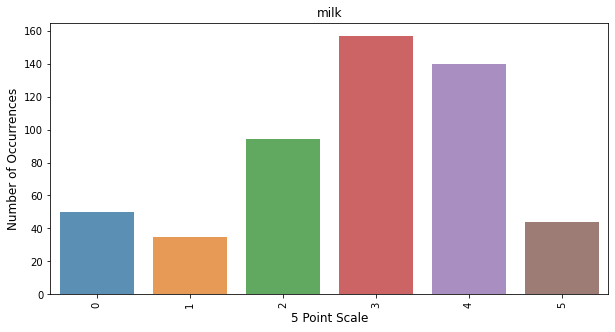

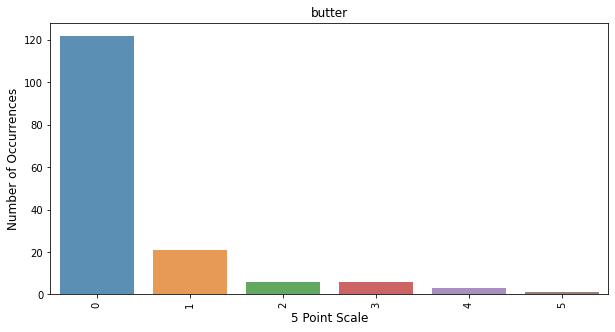

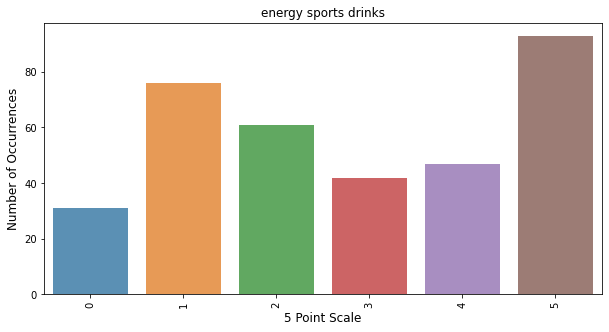

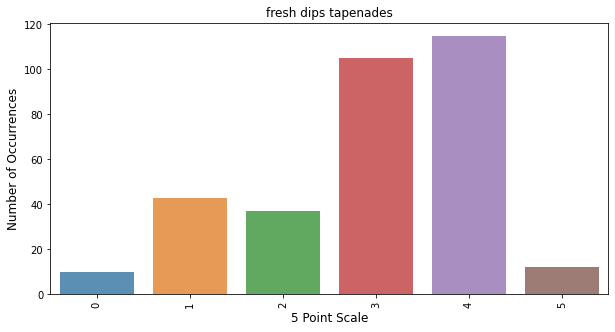

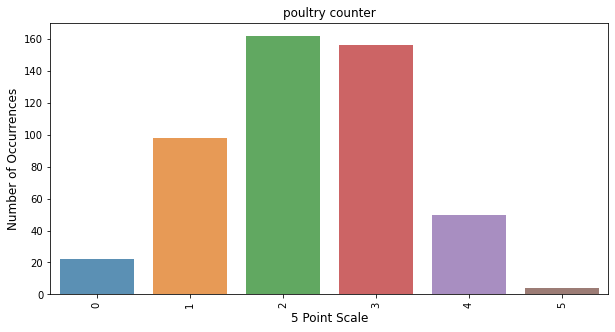

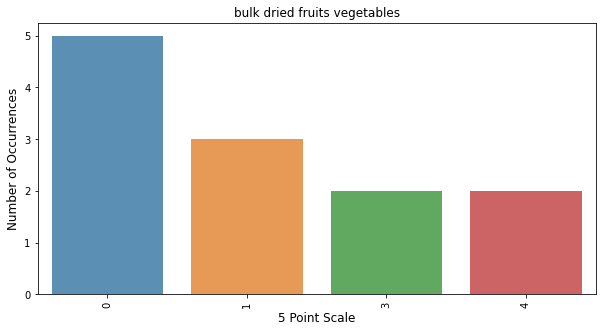

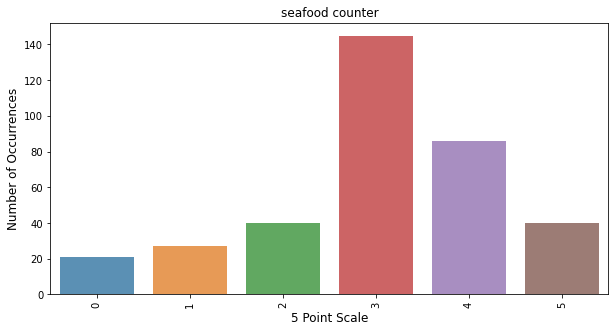

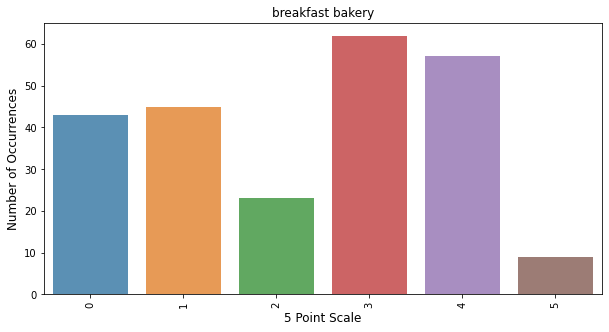

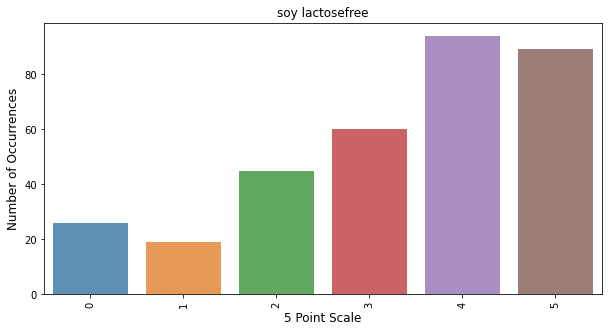

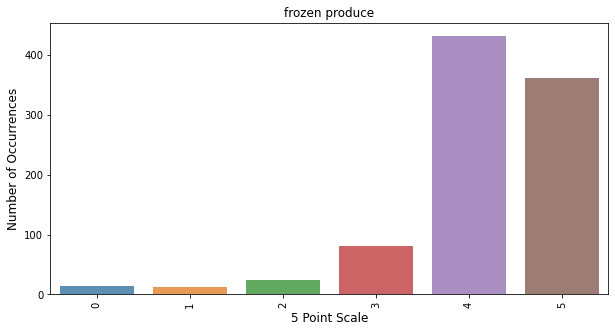

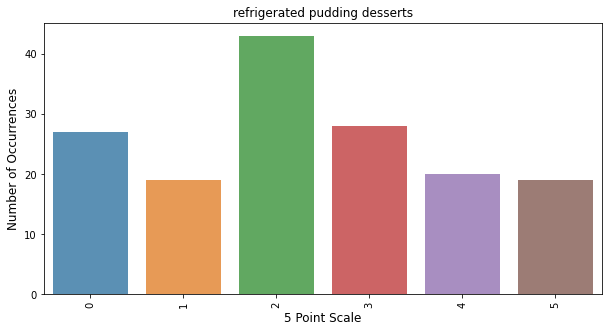

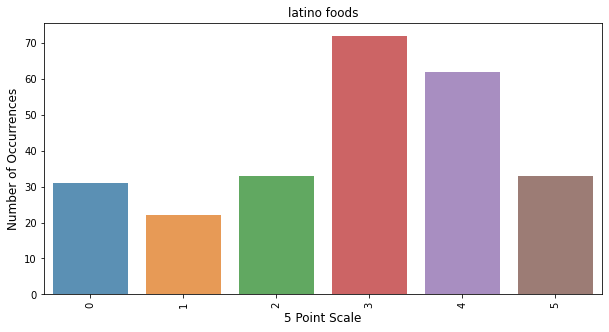

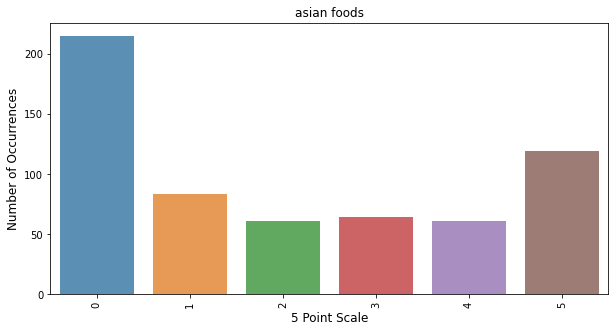

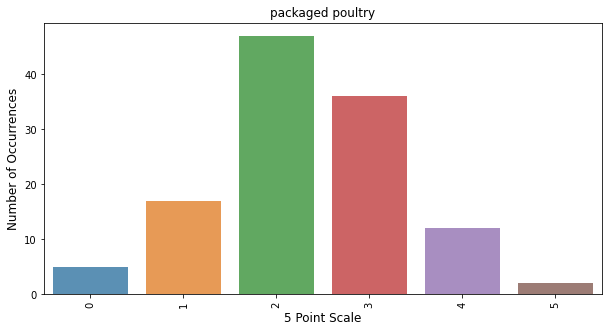

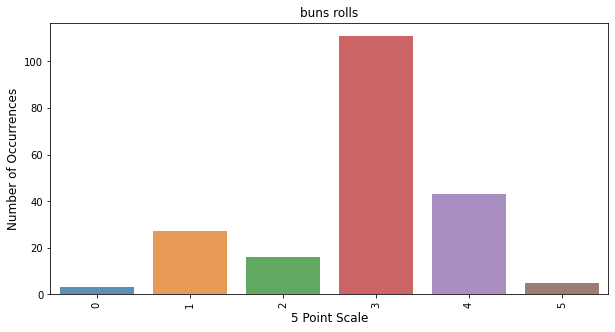

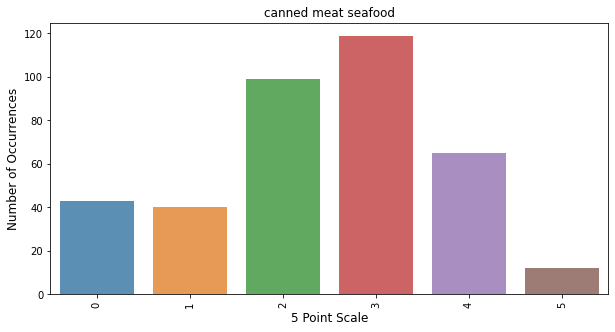

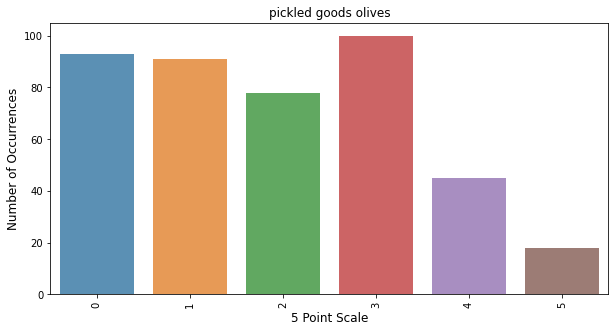

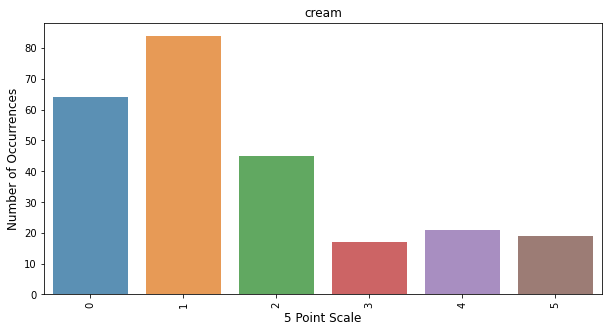

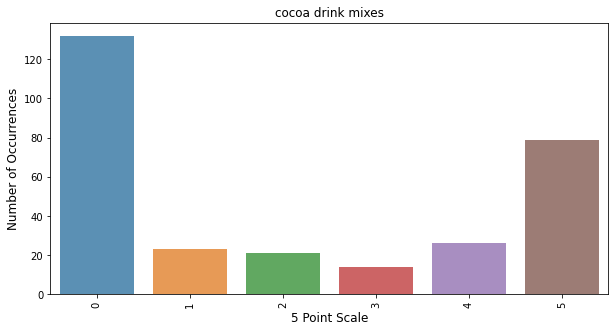

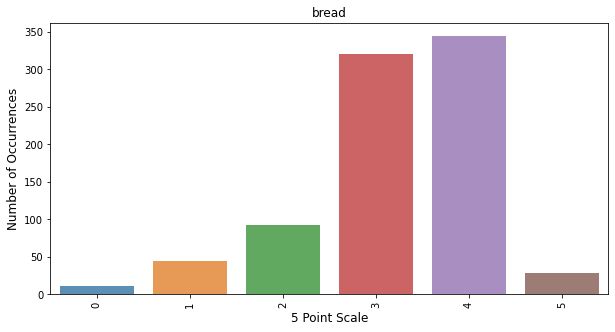

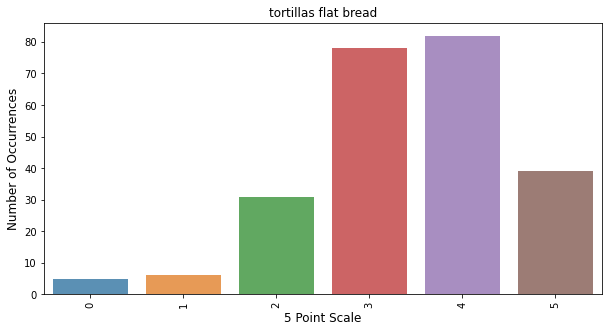

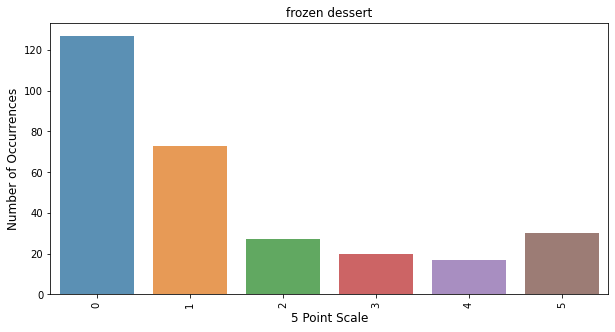

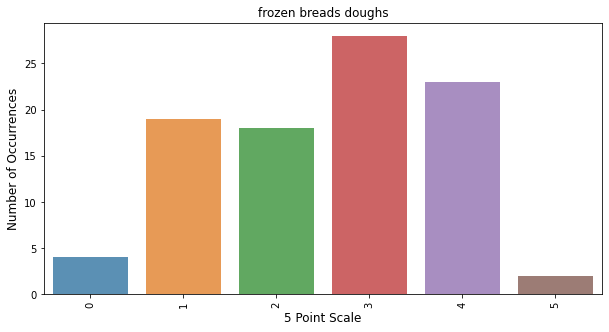

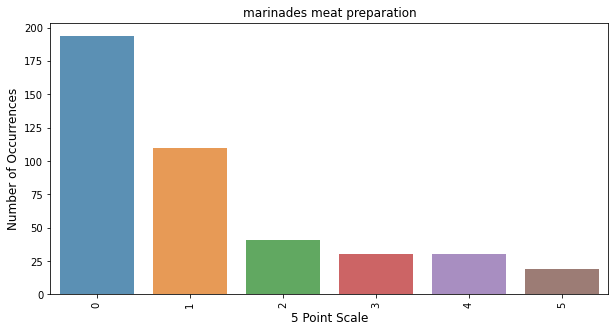

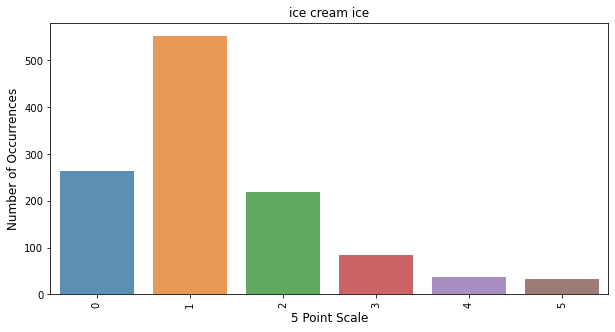

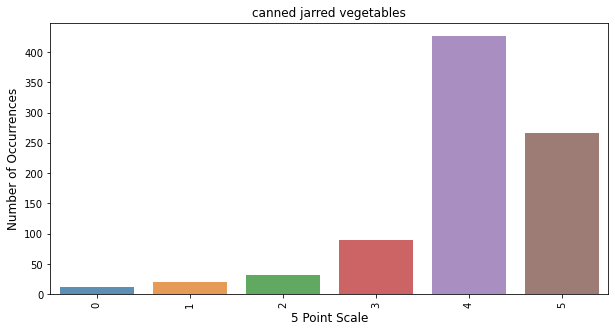

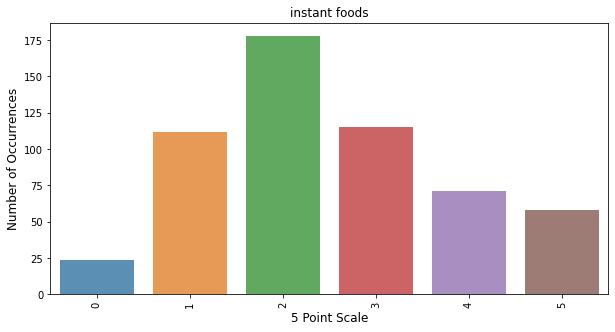

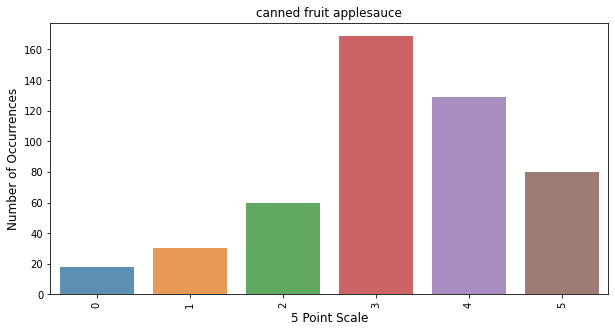

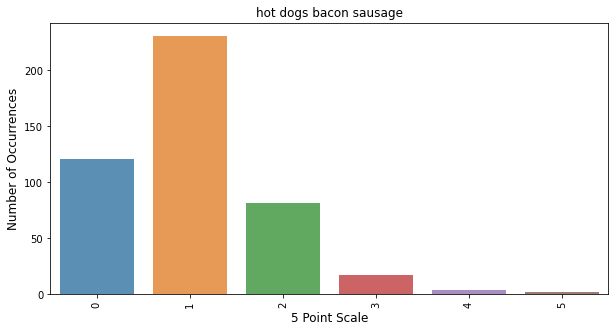

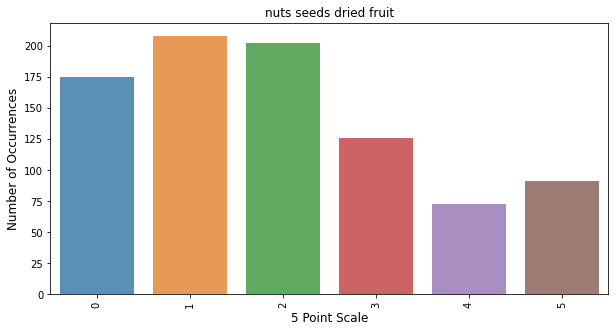

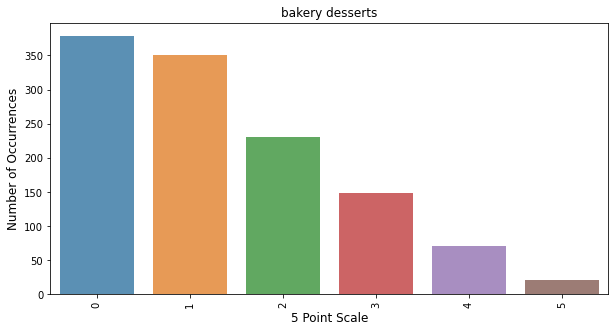

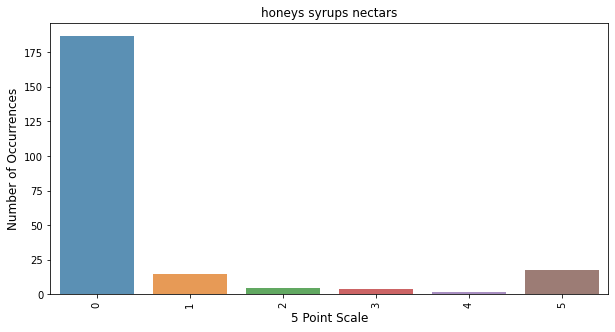

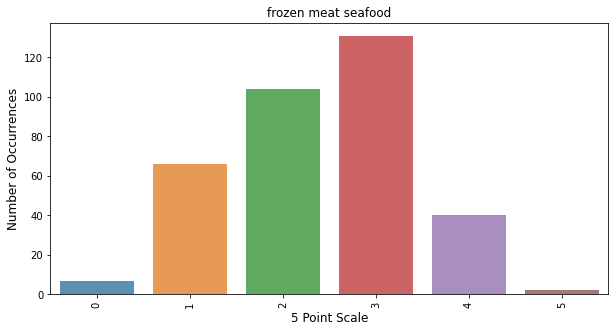

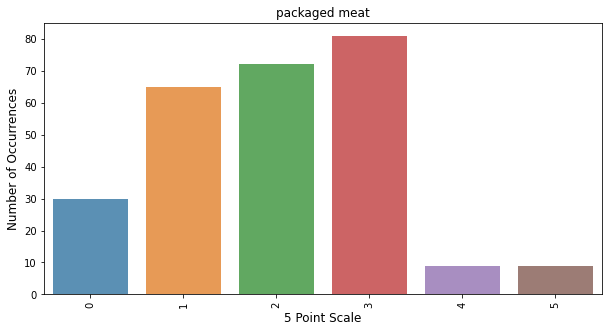

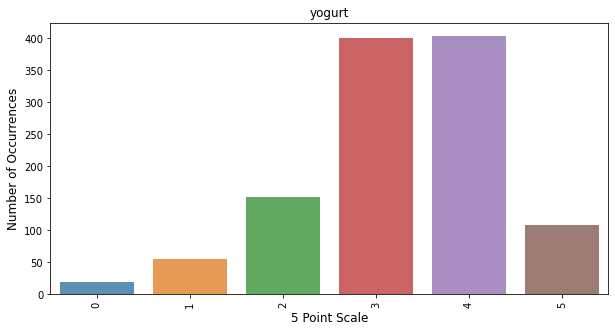

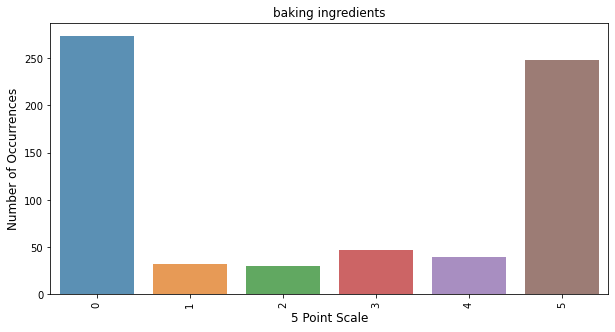

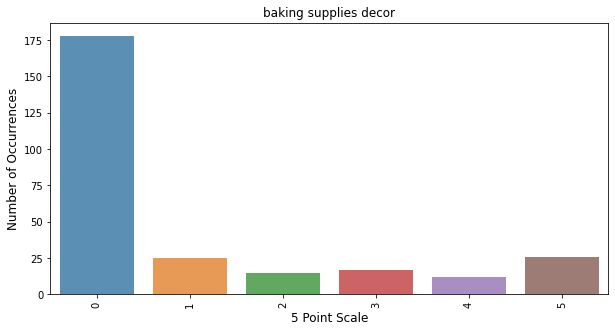

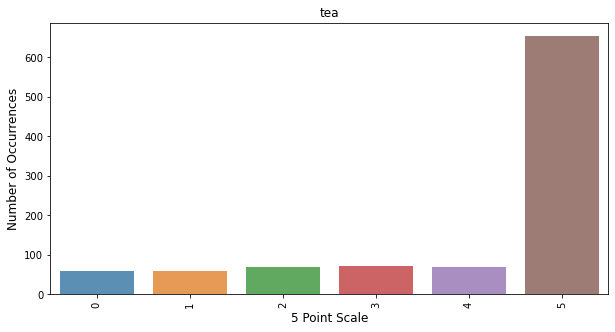

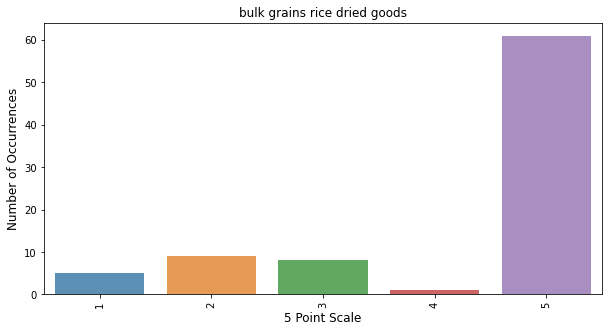

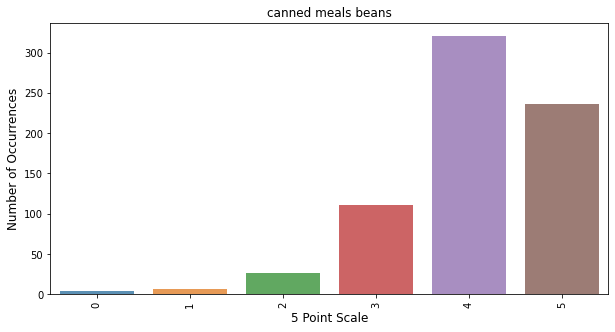

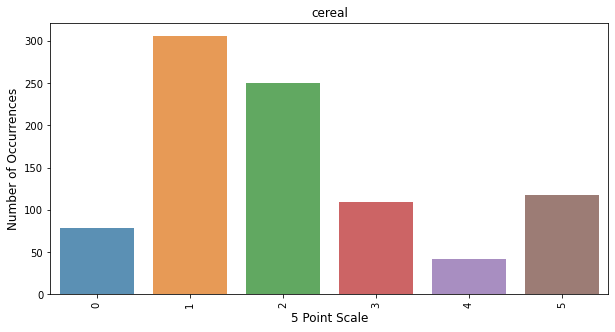

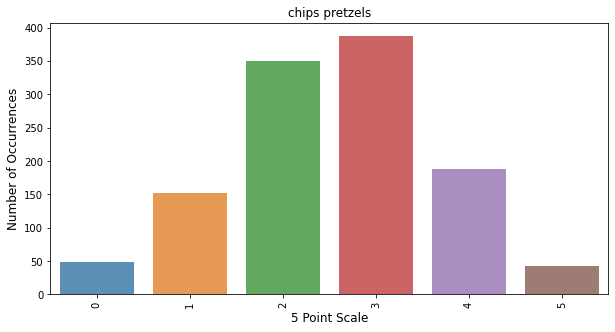

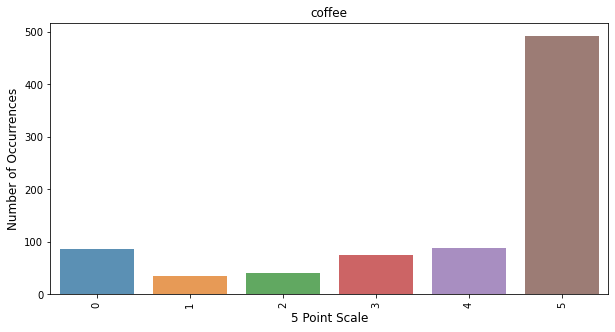

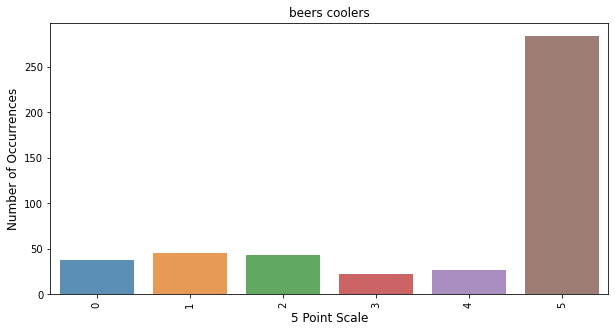

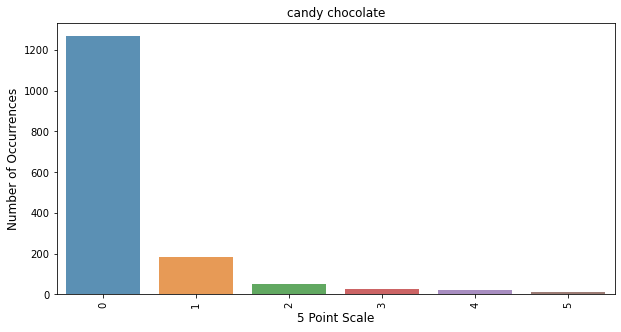

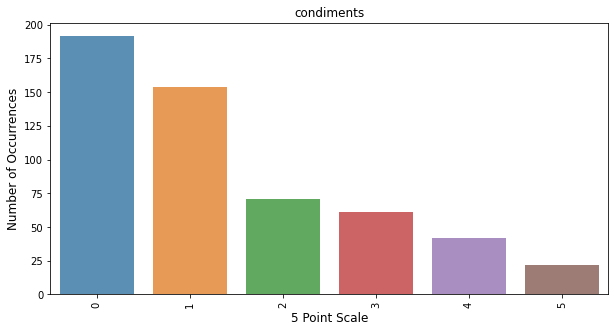

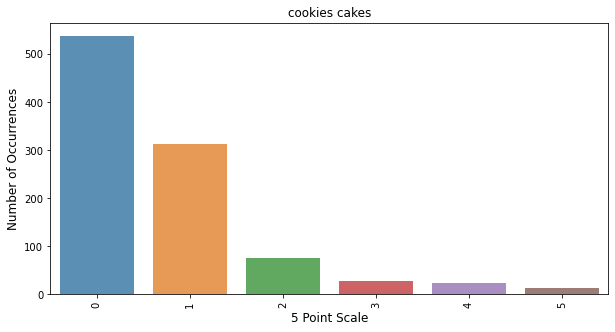

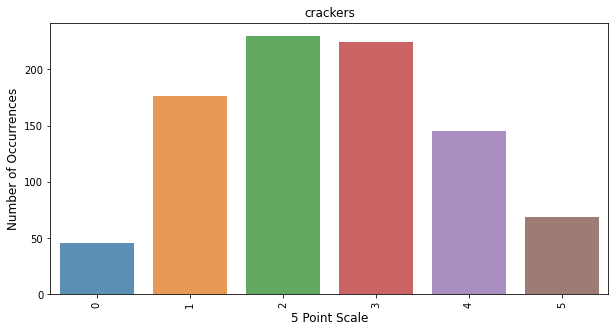

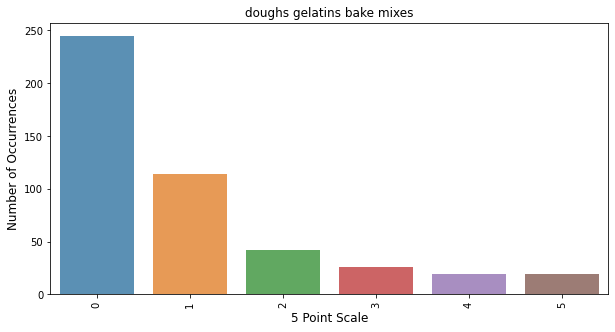

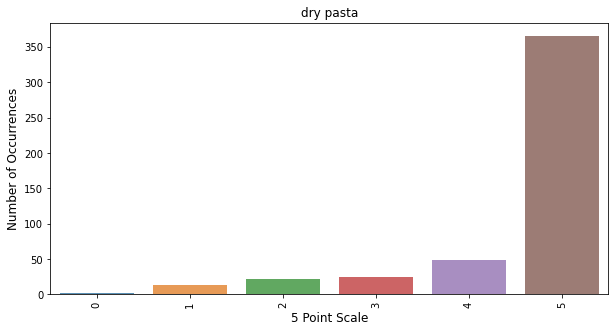

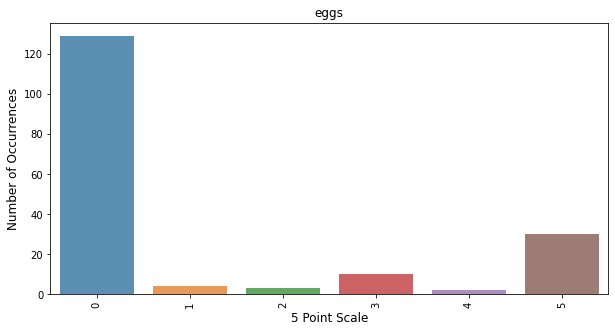

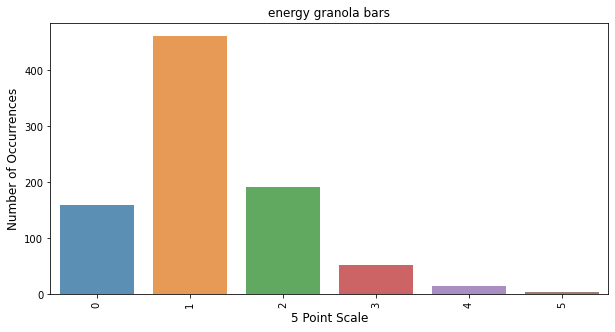

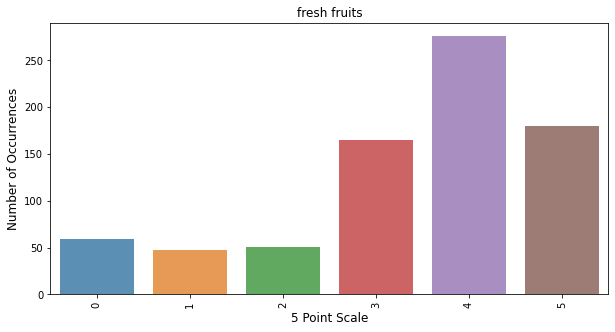

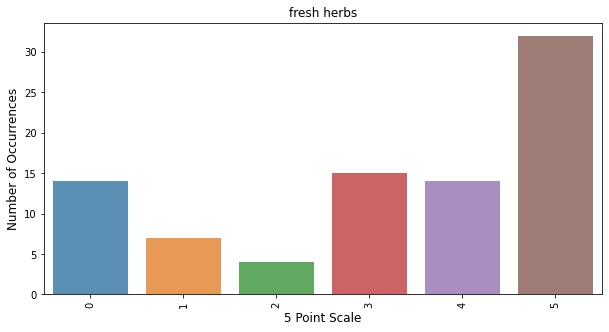

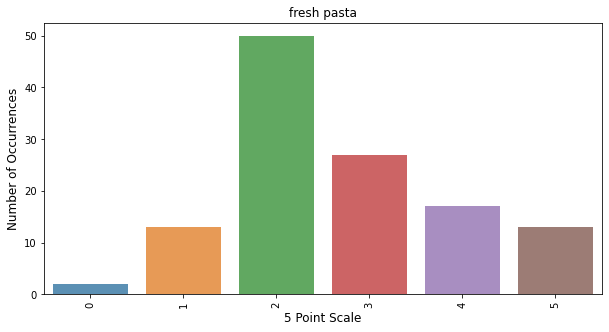

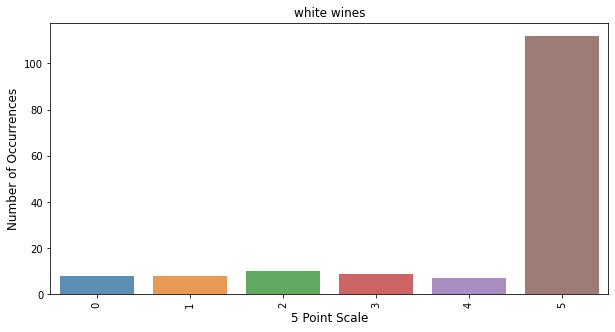

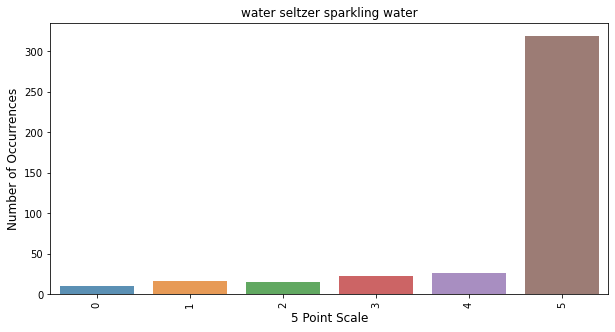

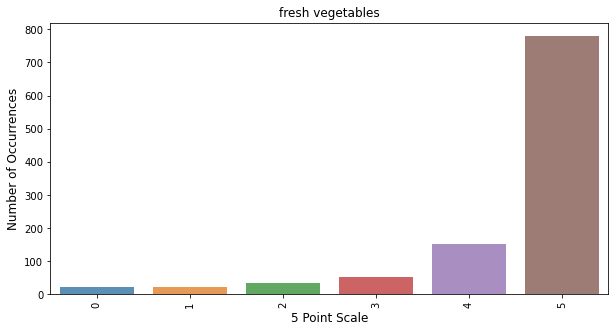

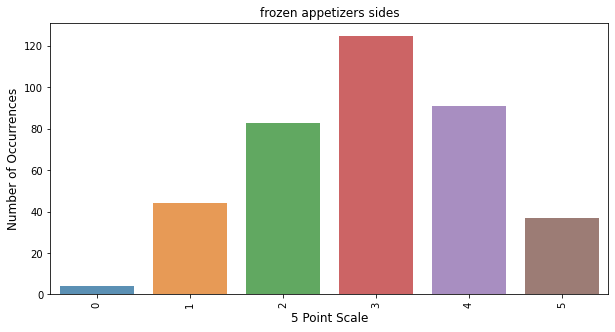

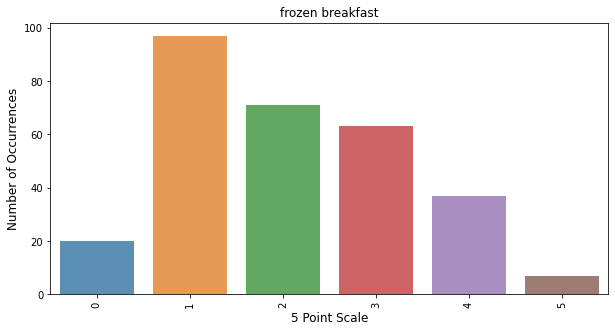

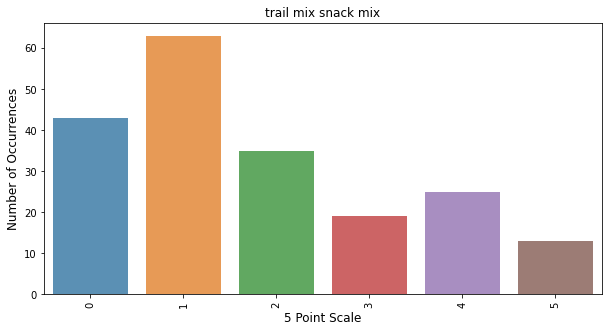

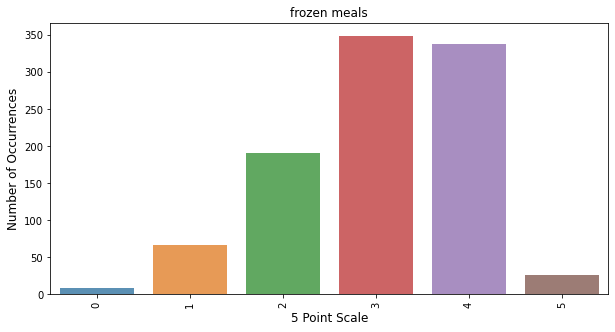

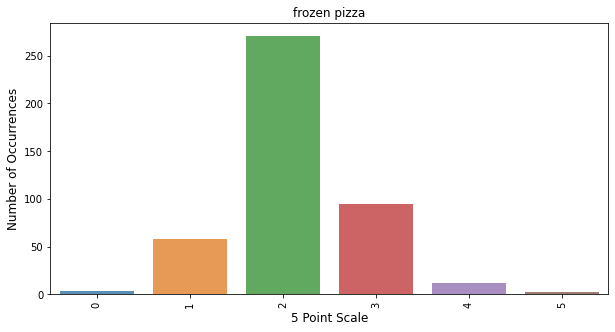

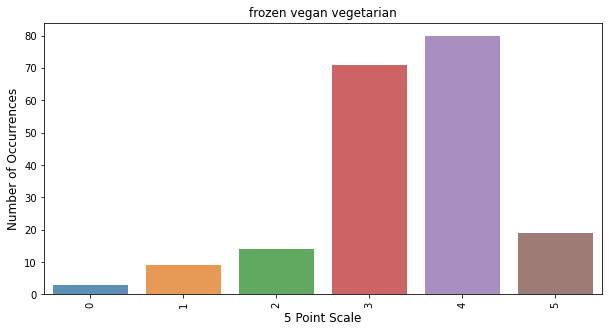

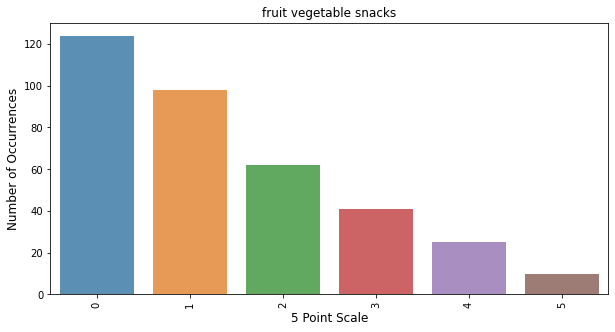

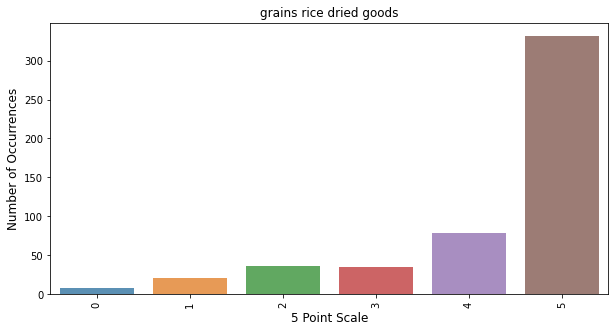

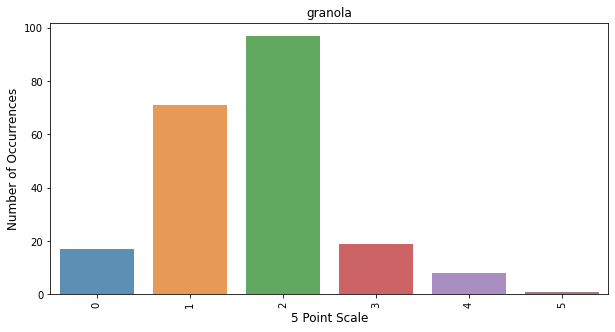

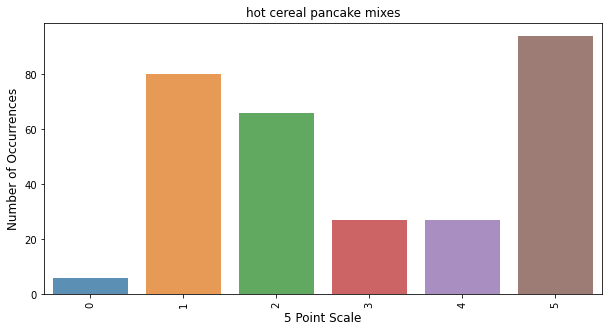

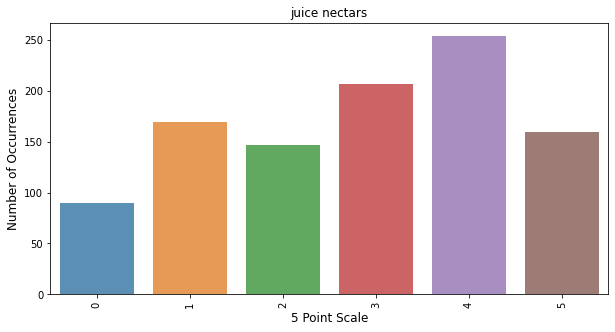

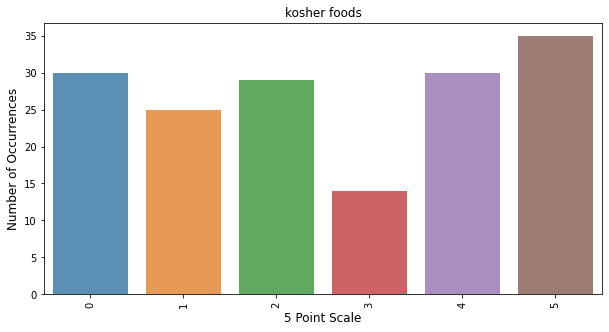

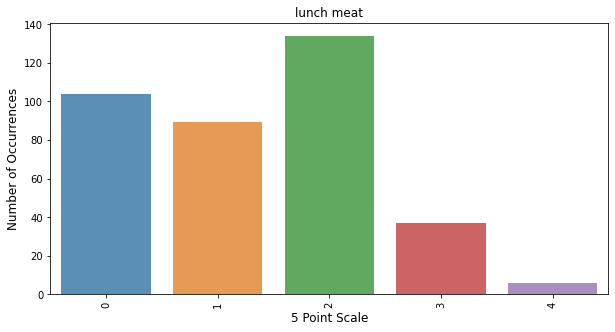

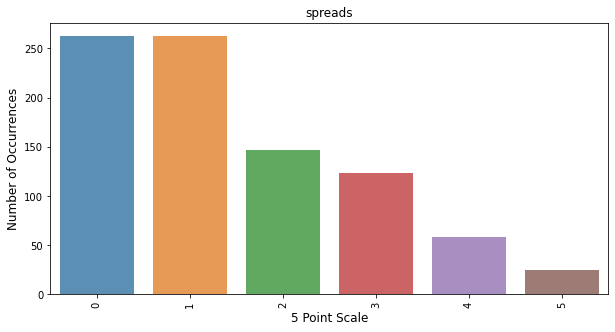

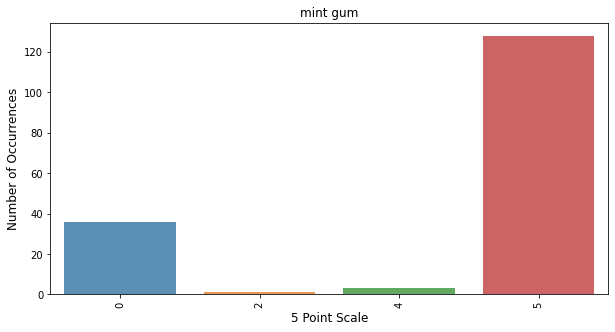

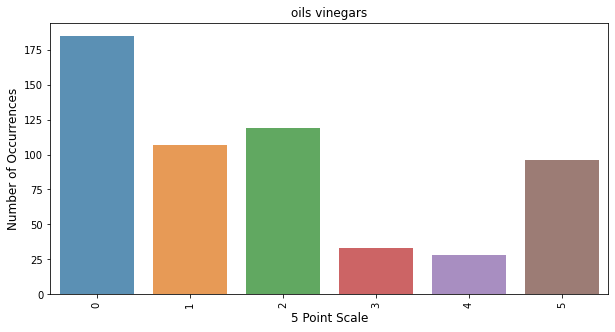

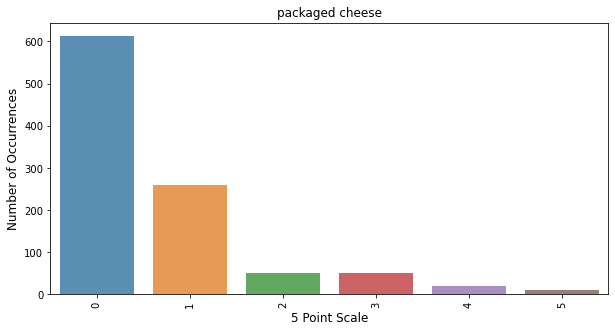

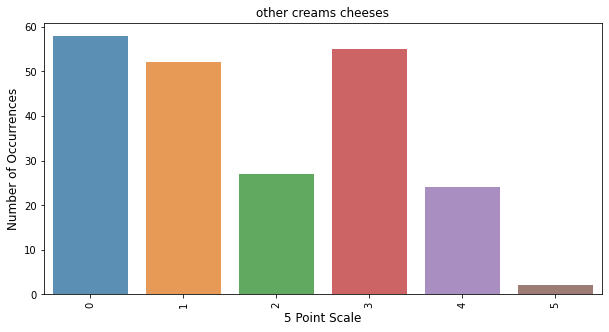

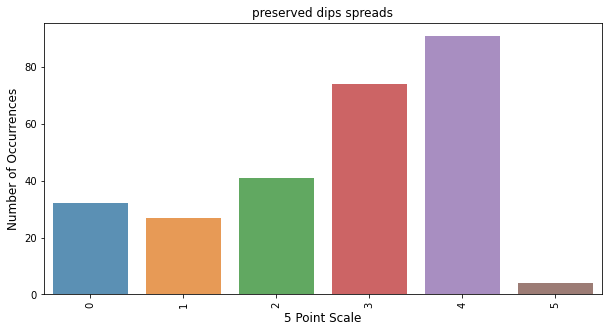

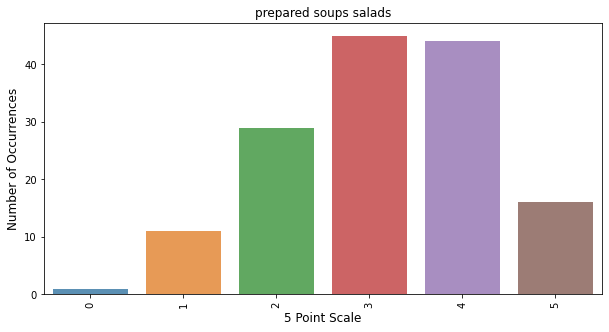

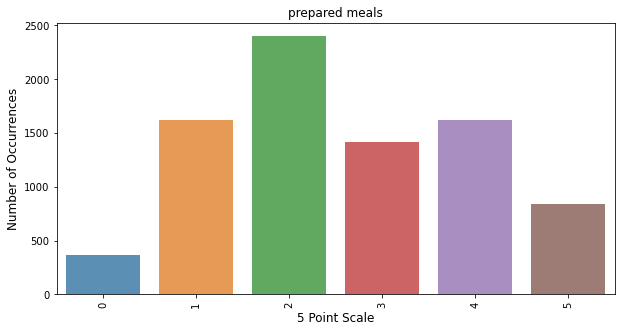

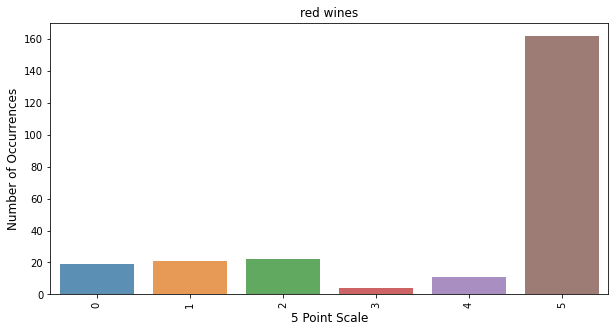

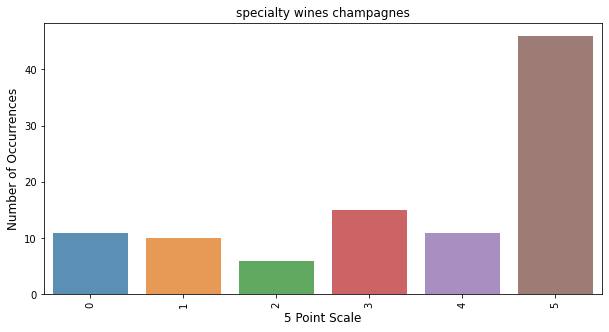

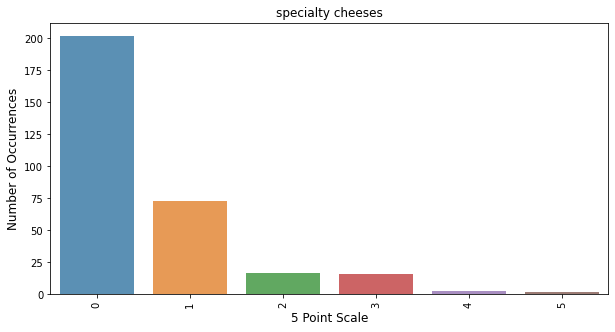

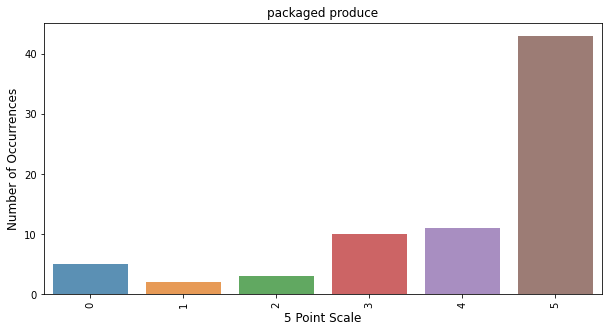

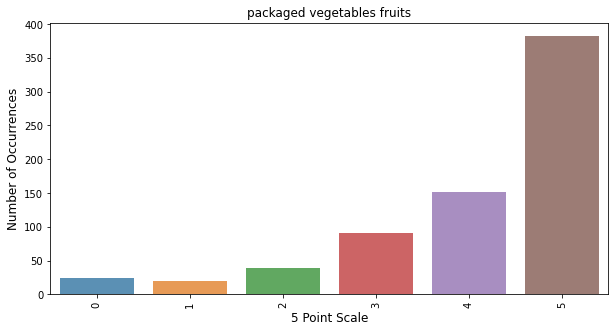

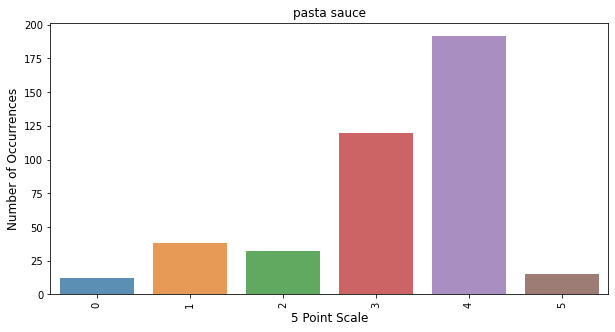

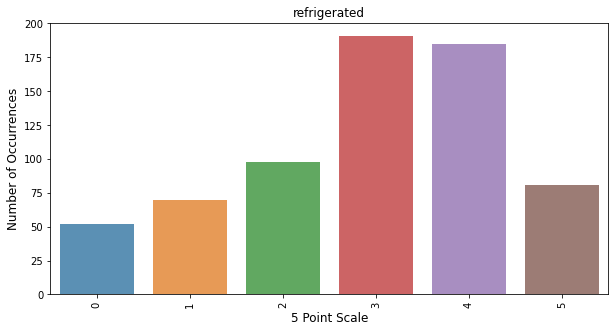

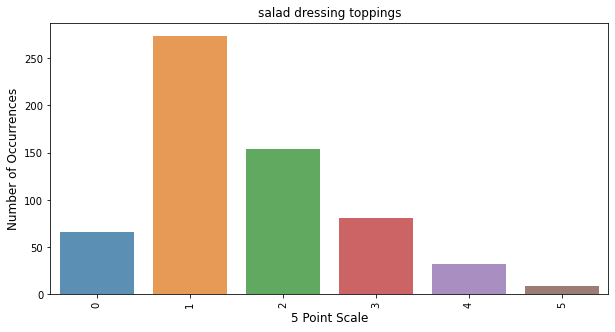

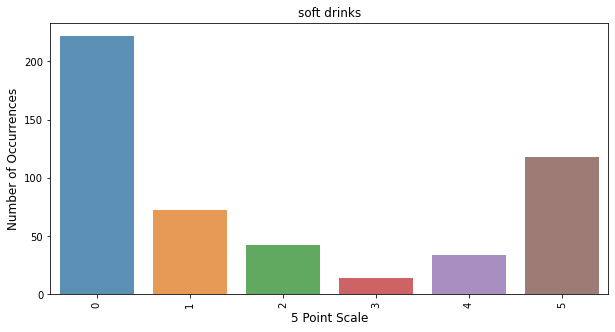

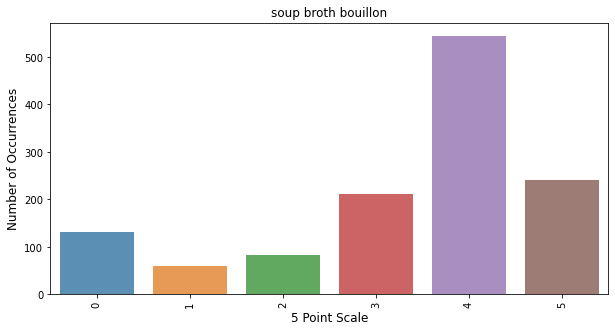

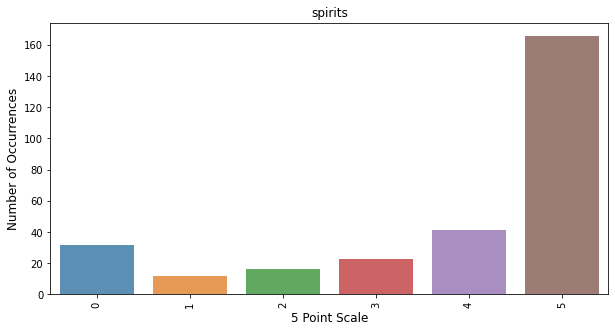

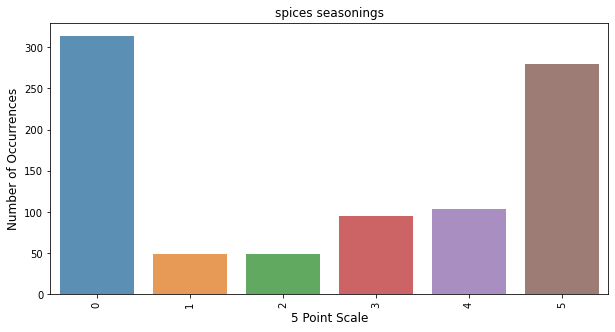

In [38]:

for aisle_name in data['aisle'].unique():
    plot_barplot(data, aisle_name, 'LIM points', '5 Point Scale')

### Combine SAIN LIM score

In [36]:
data['SAIN-LIM Point'] = data['SAIN points'] + data['LIM points']

### SAIN-LIM point distribution of each aisle 

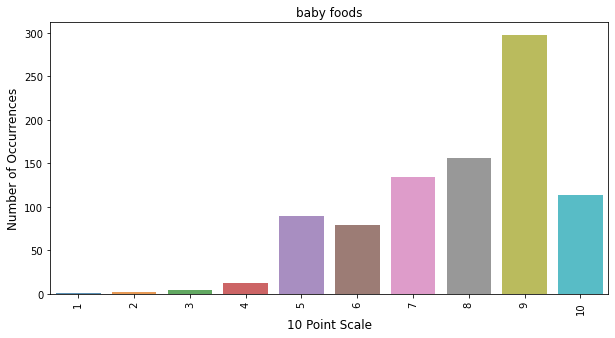

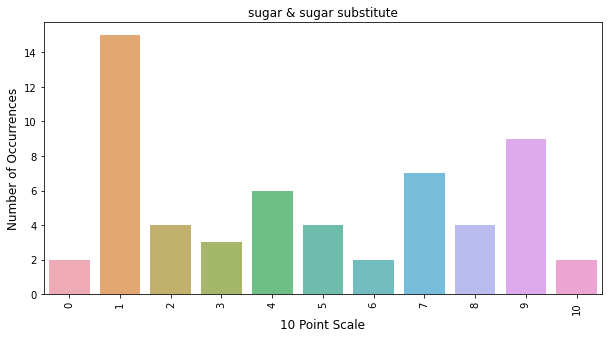

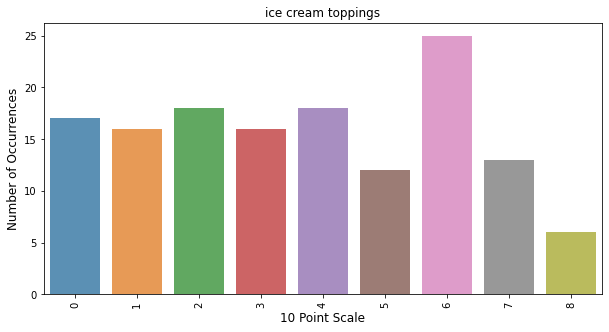

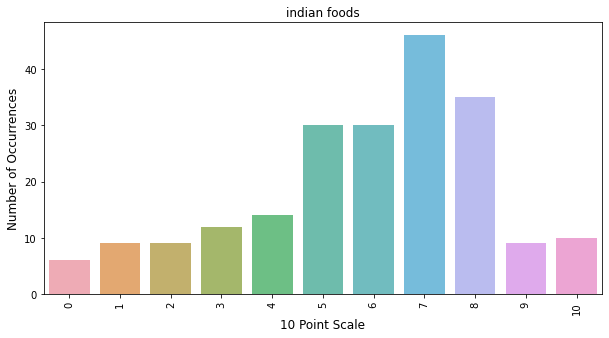

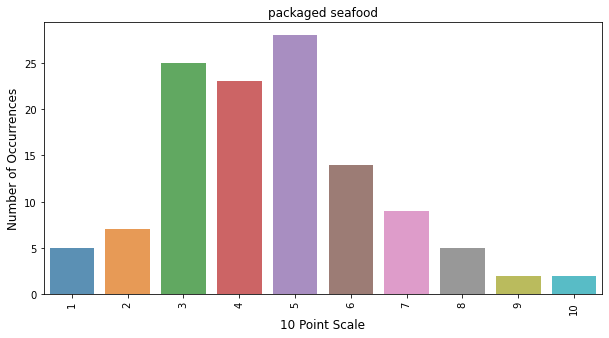

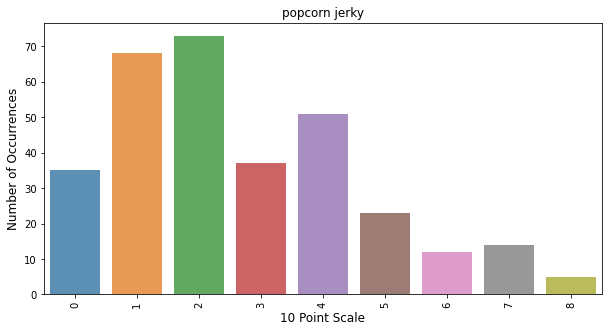

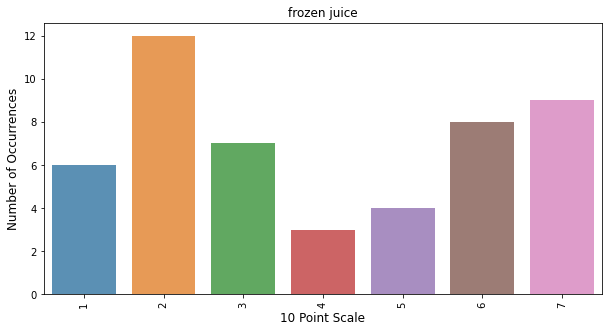

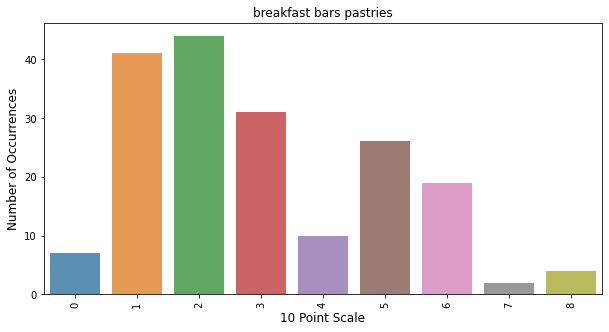

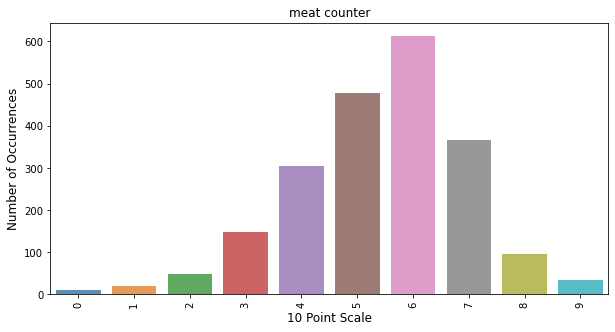

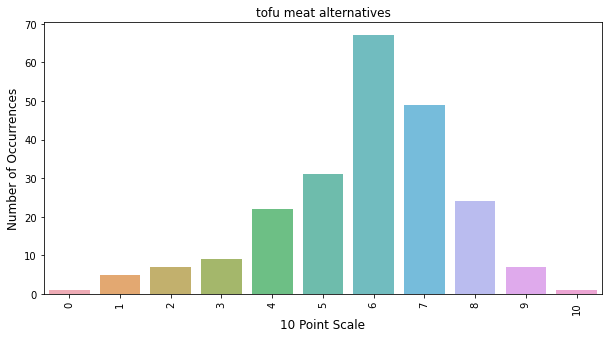

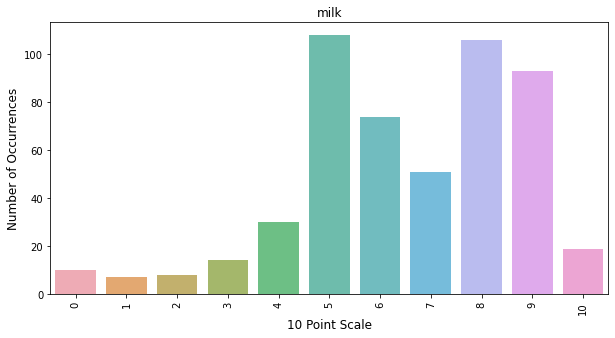

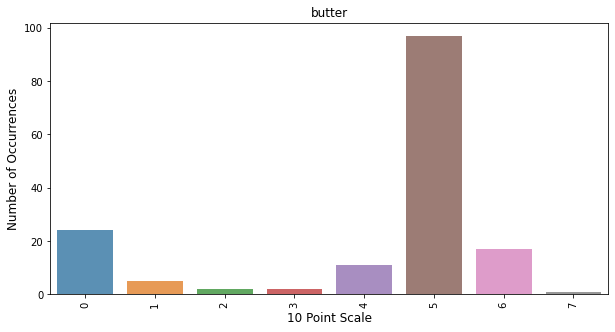

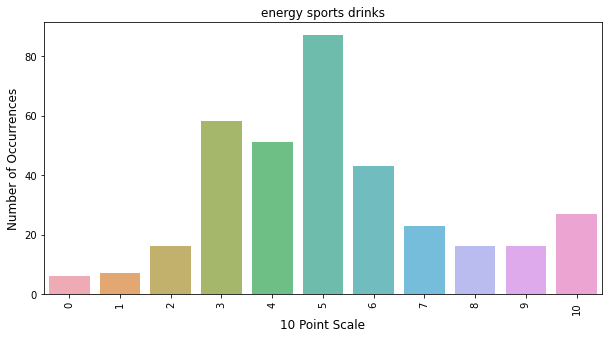

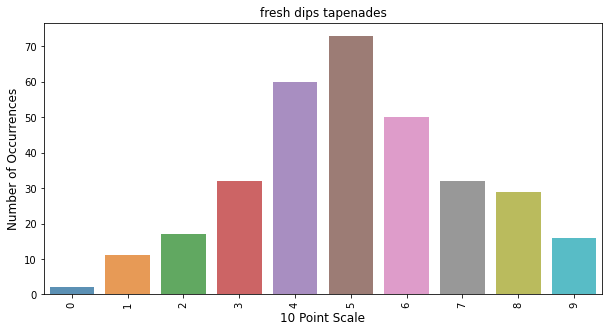

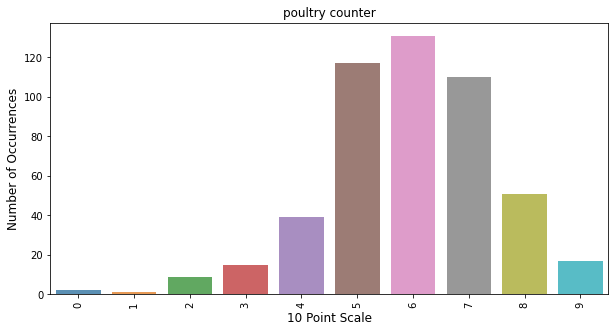

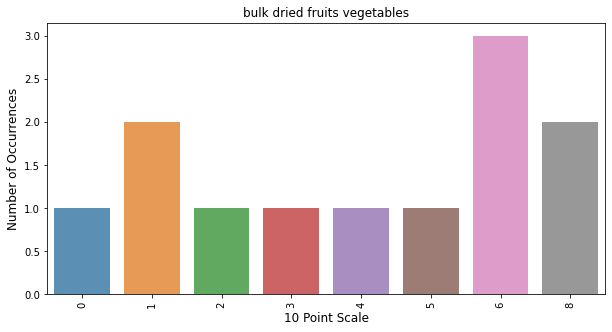

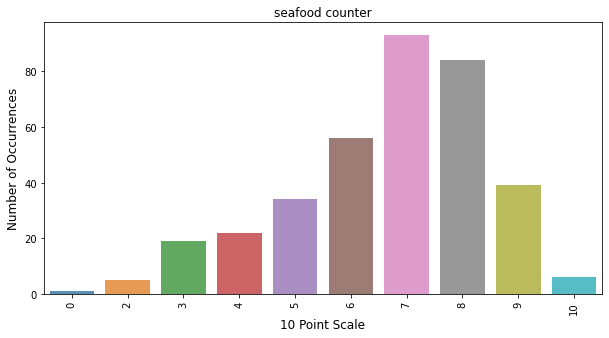

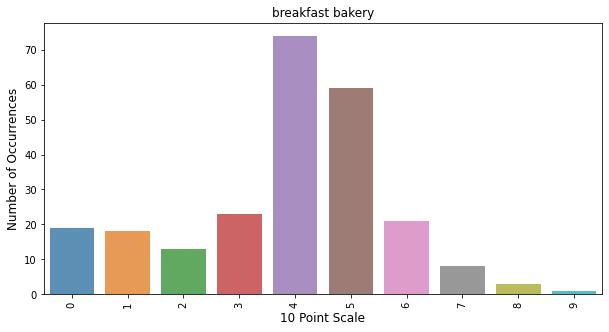

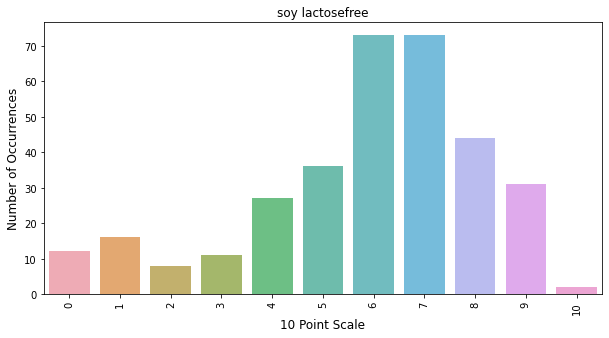

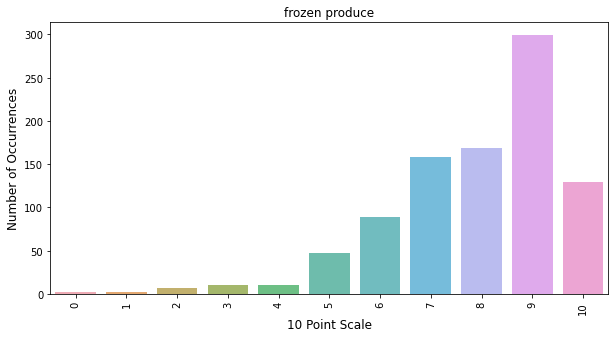

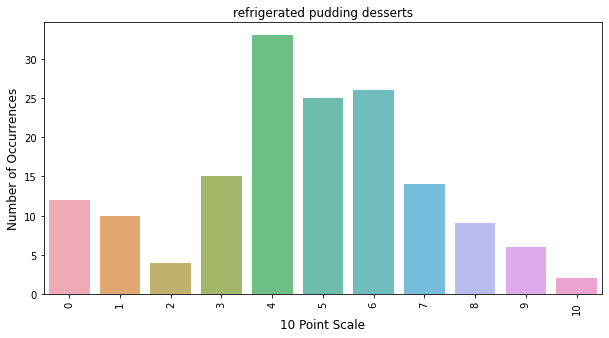

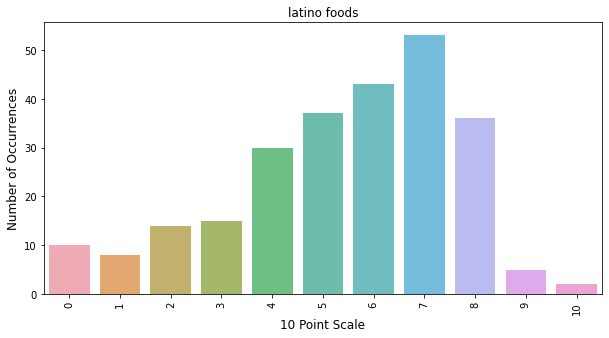

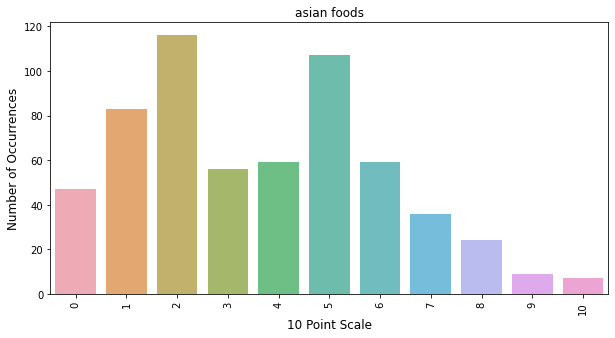

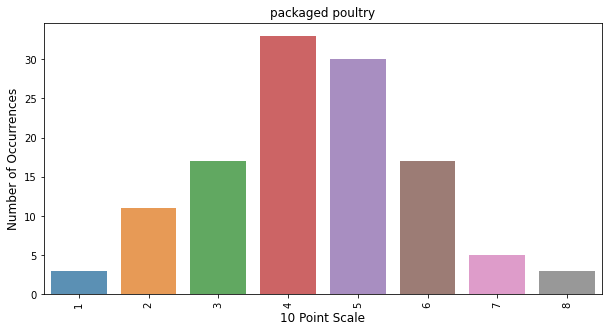

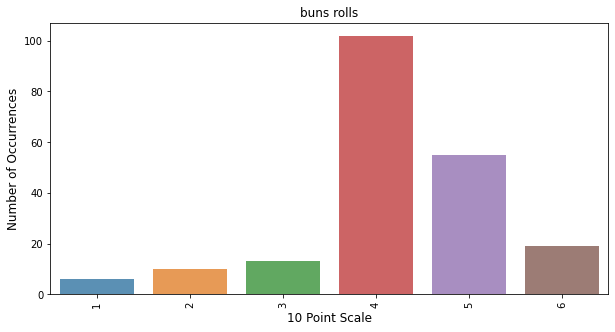

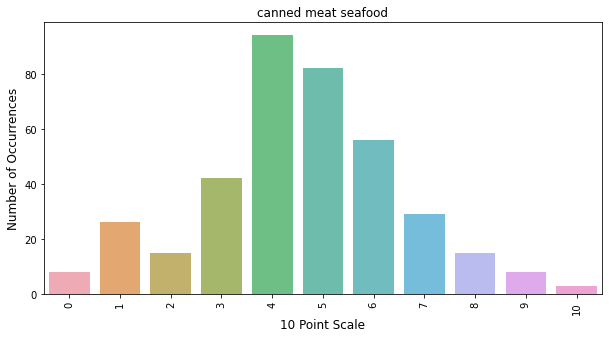

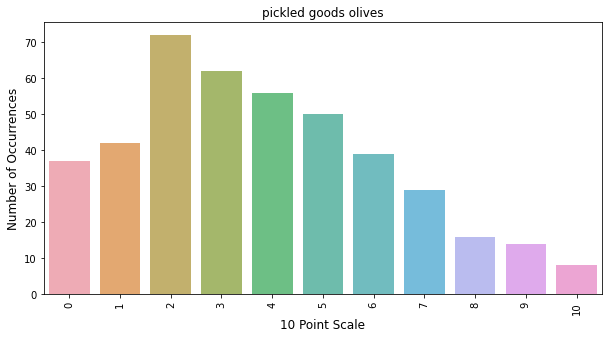

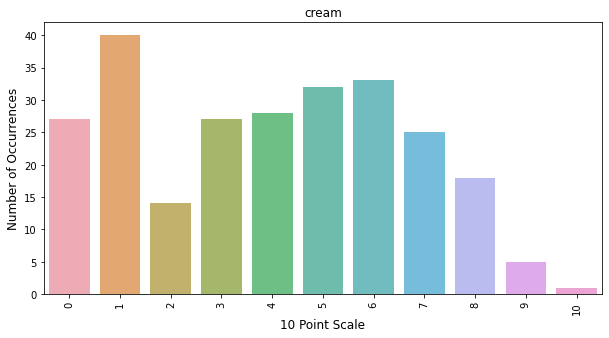

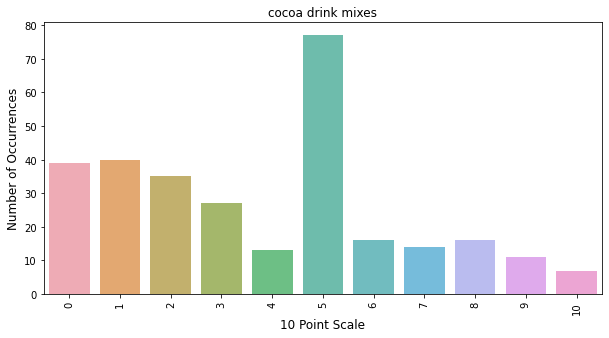

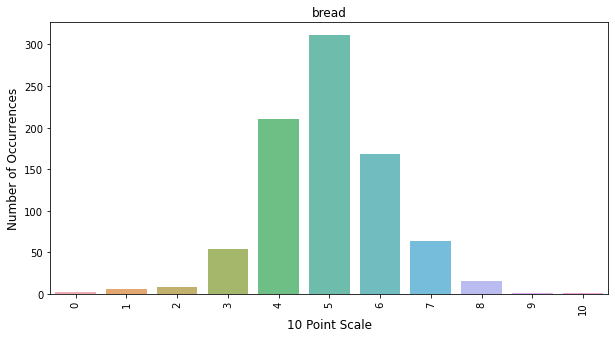

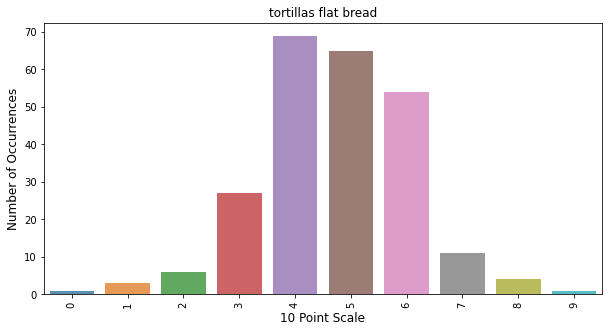

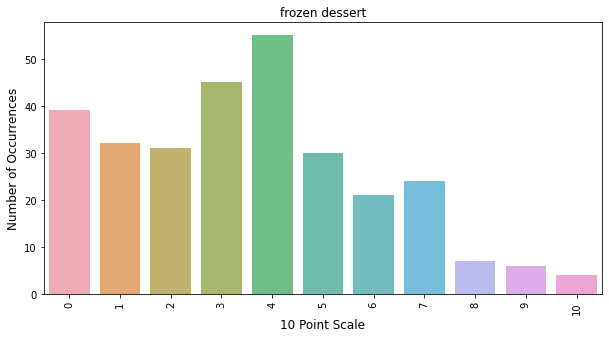

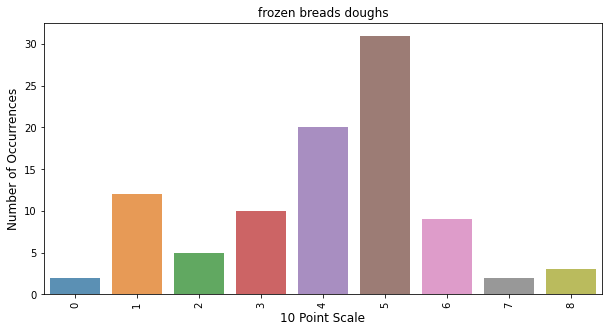

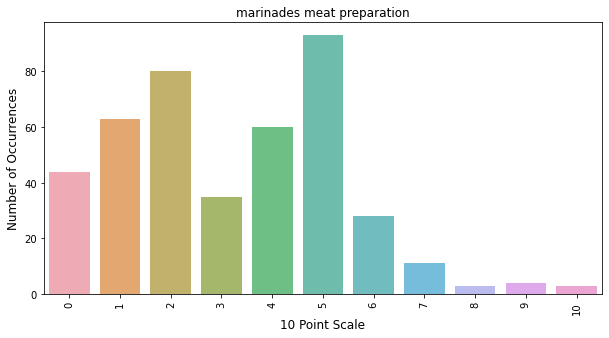

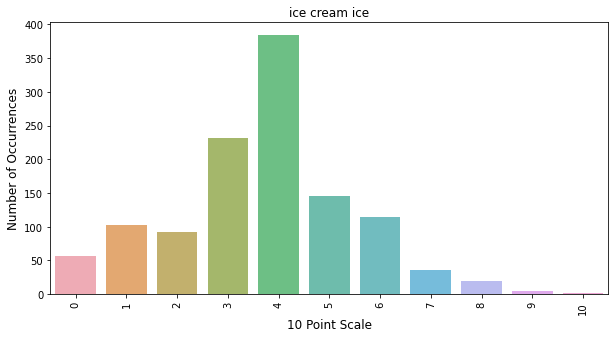

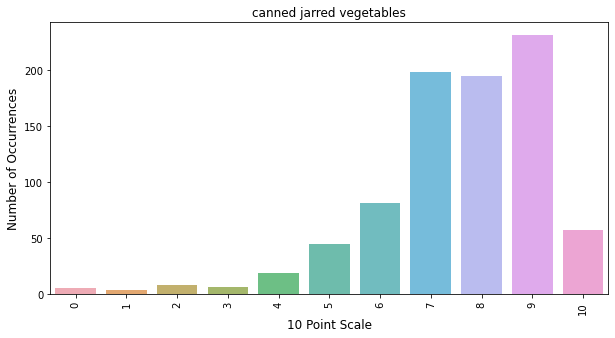

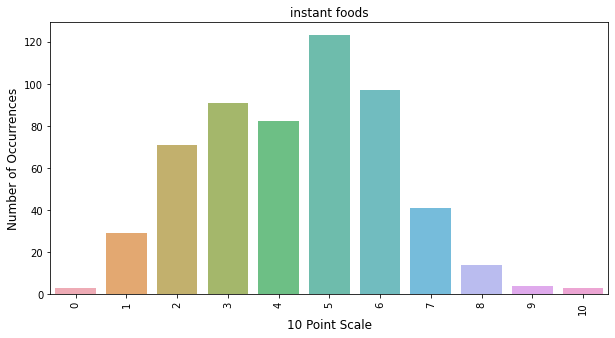

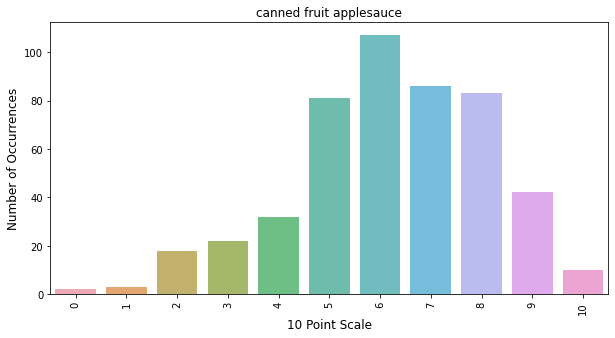

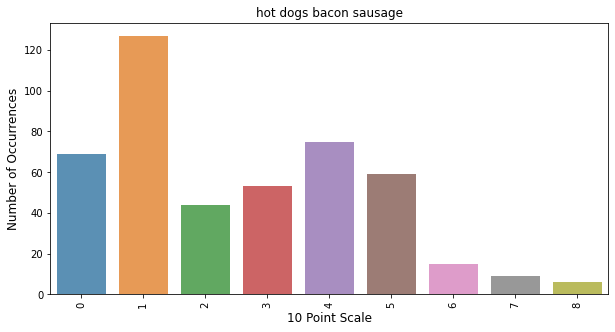

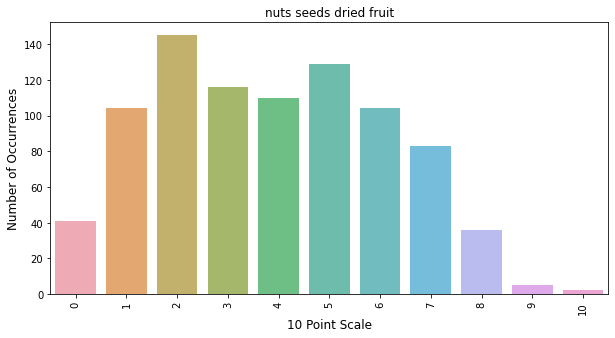

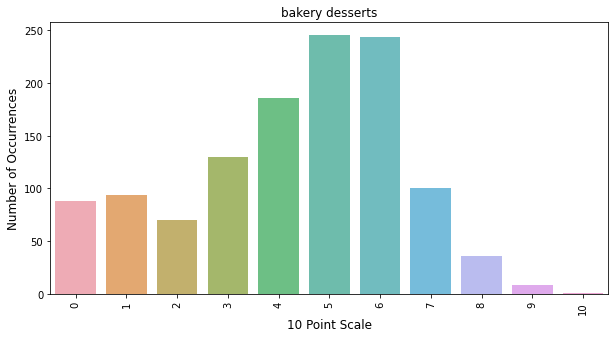

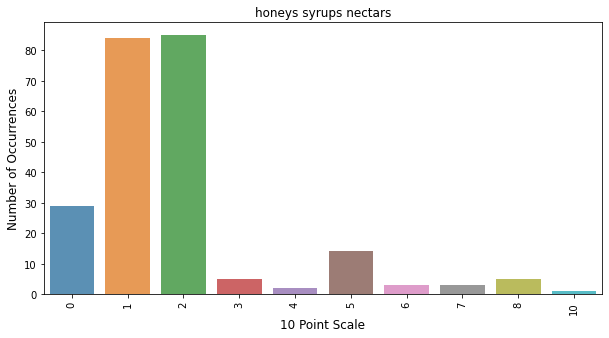

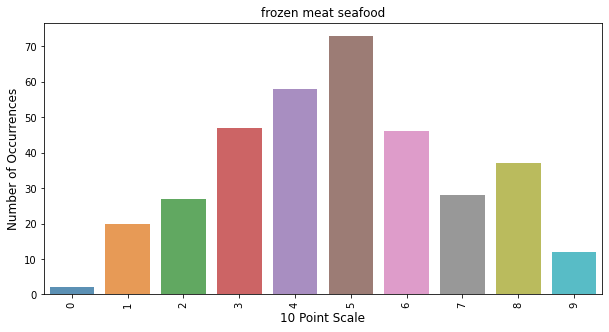

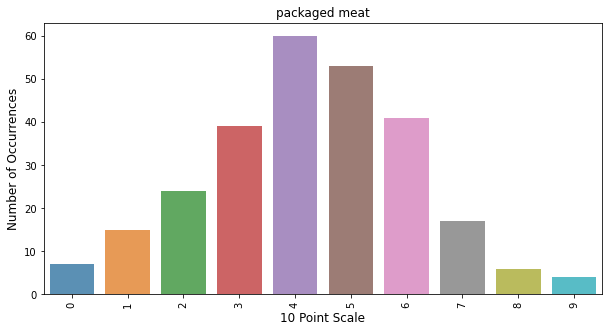

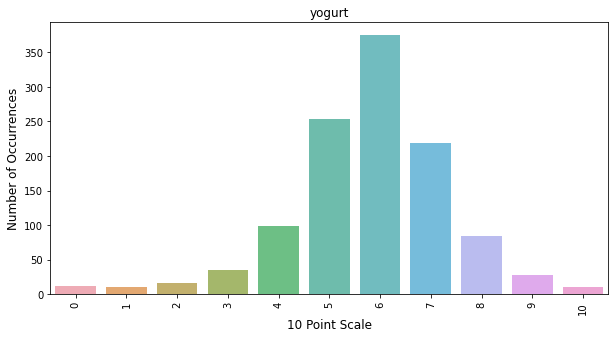

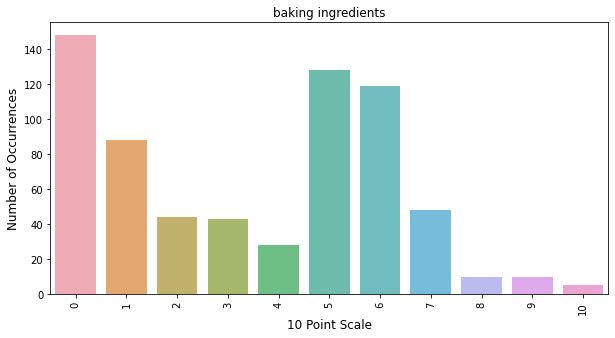

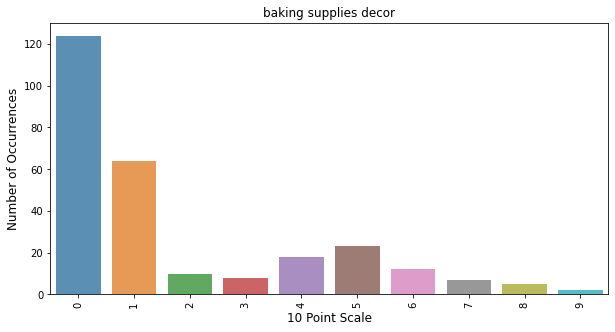

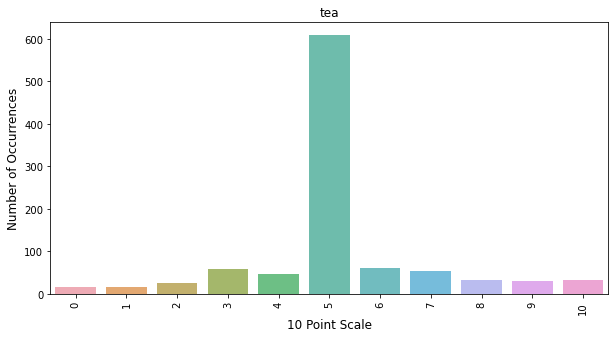

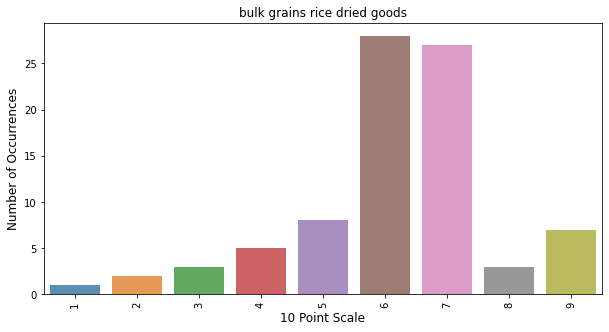

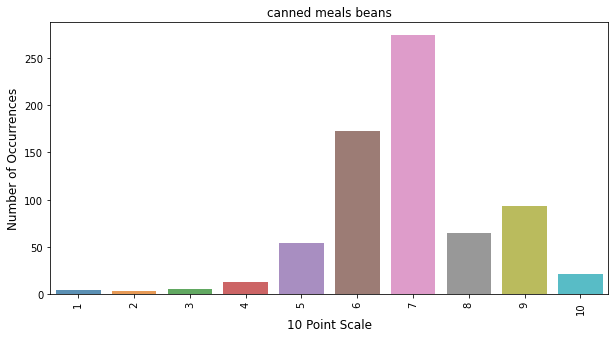

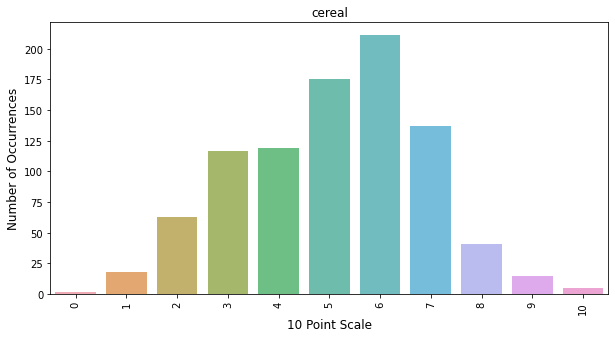

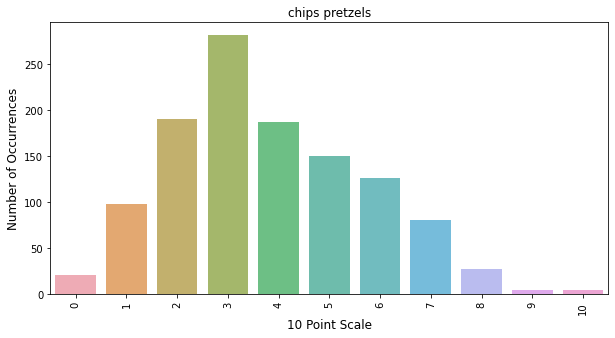

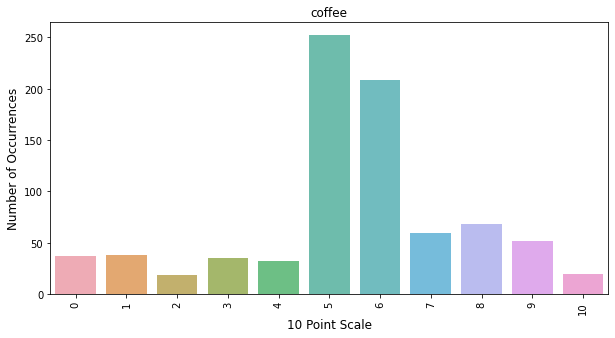

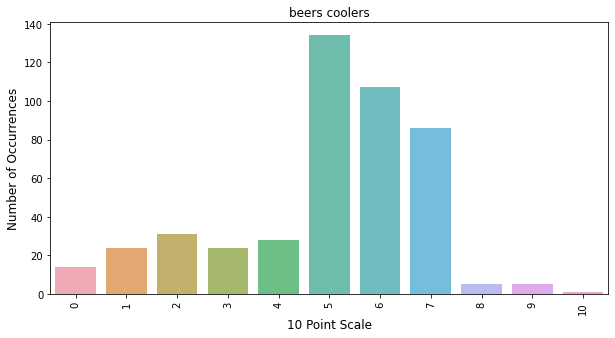

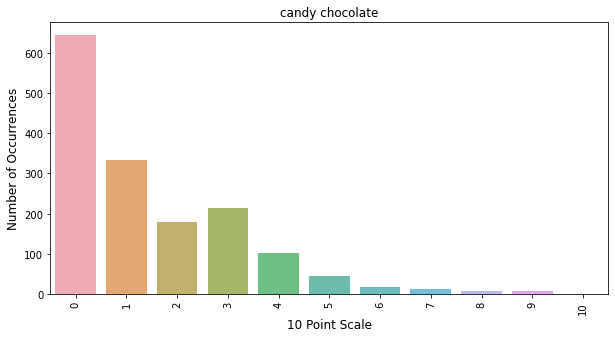

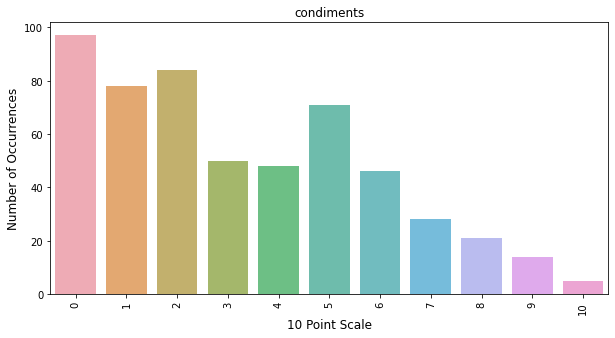

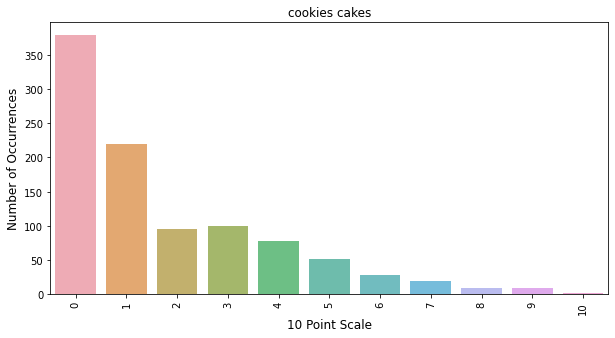

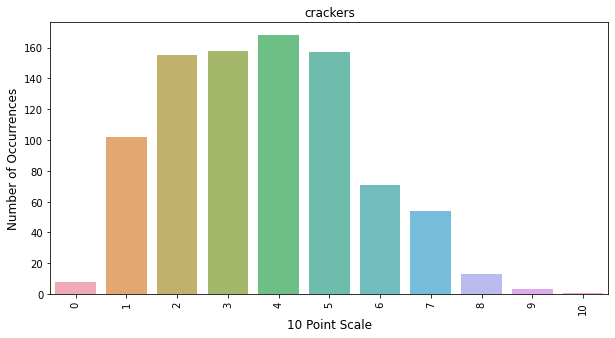

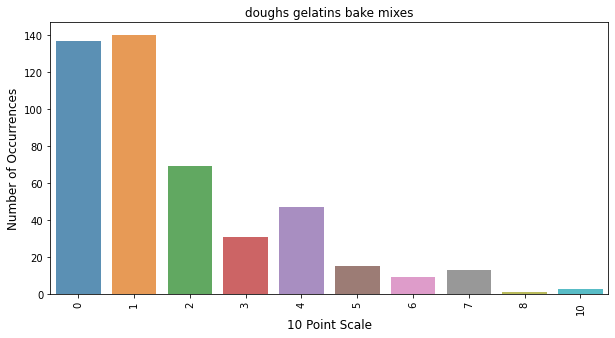

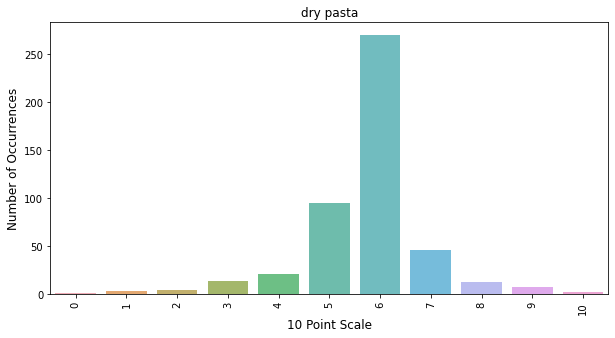

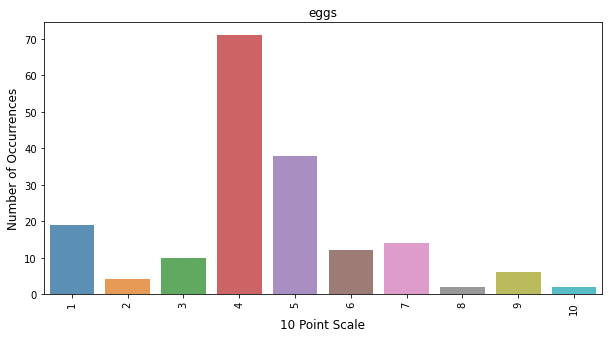

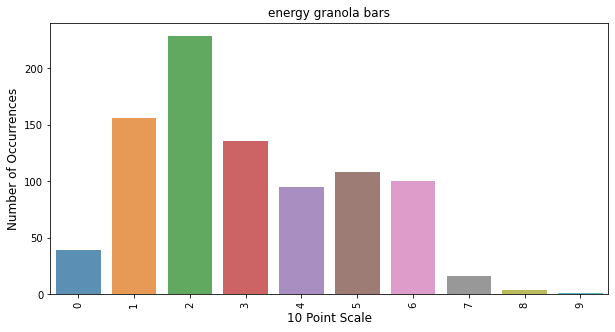

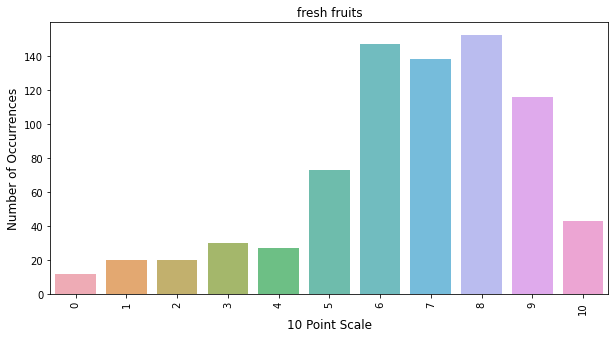

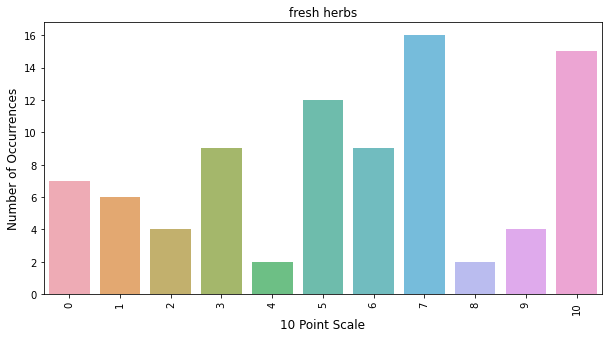

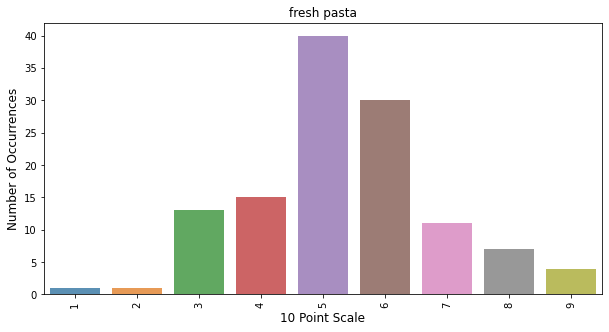

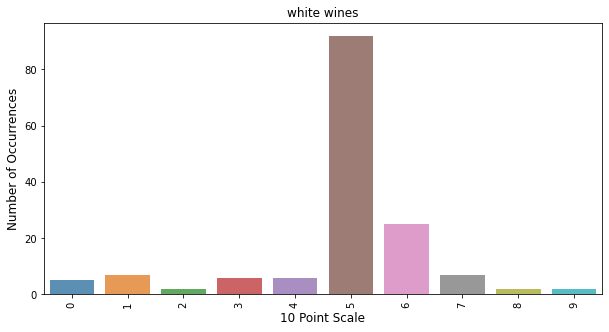

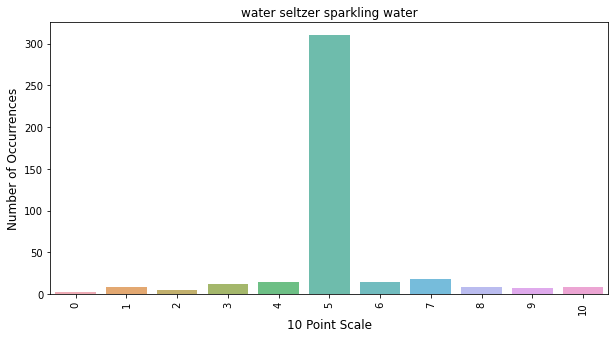

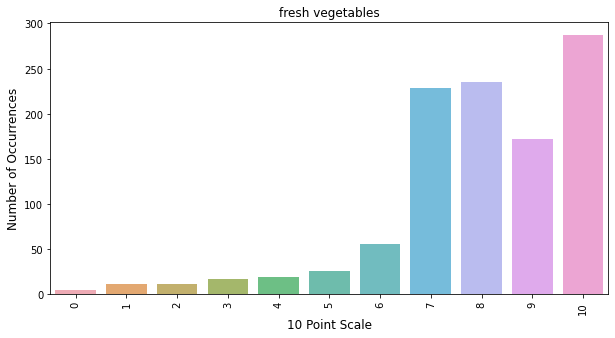

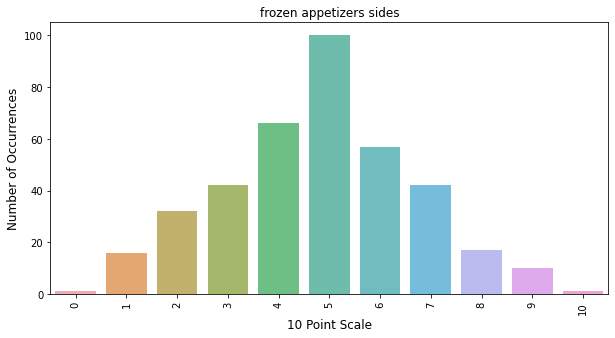

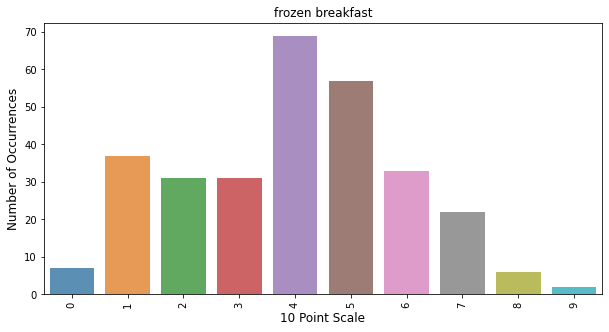

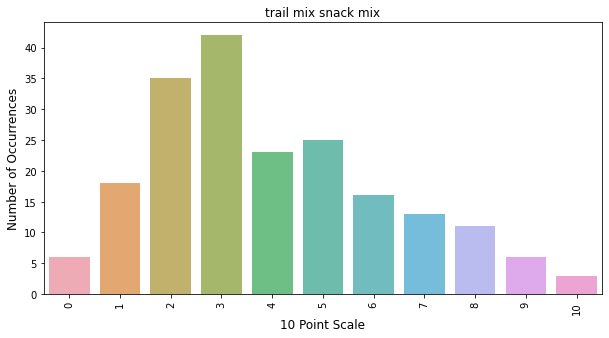

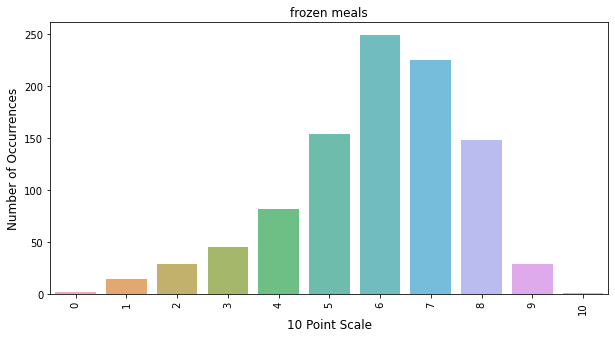

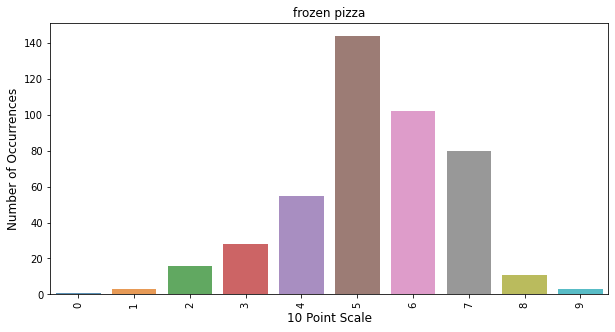

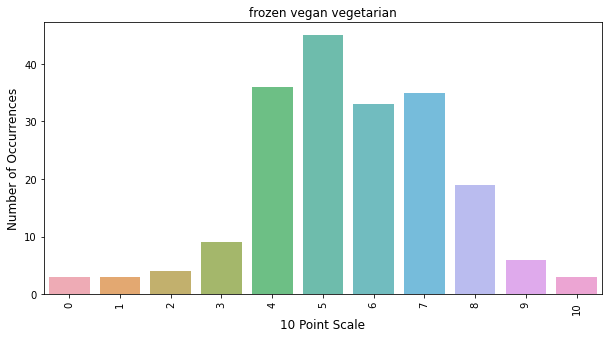

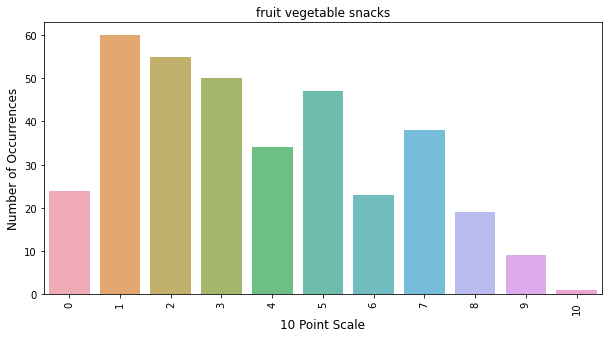

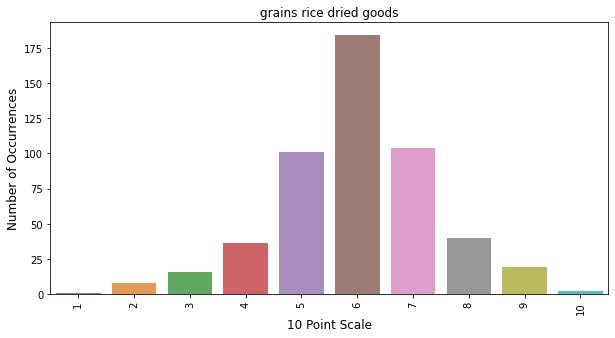

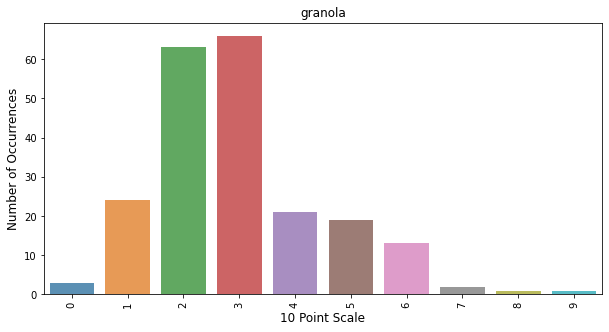

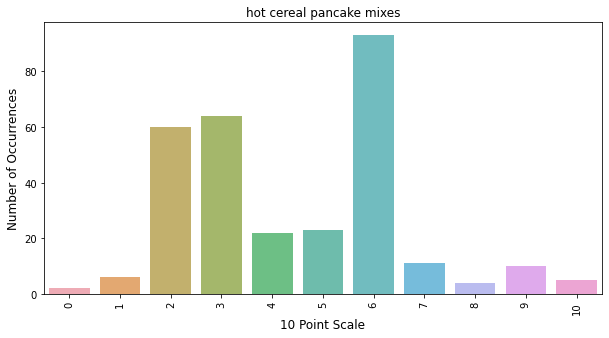

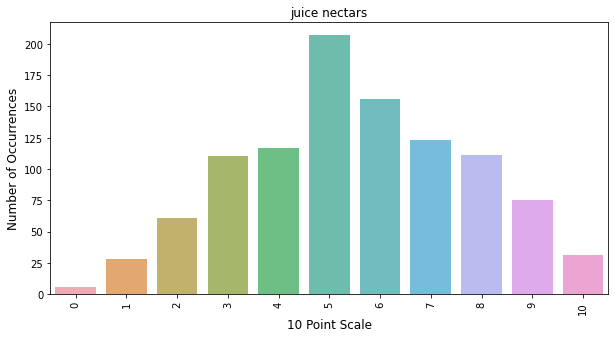

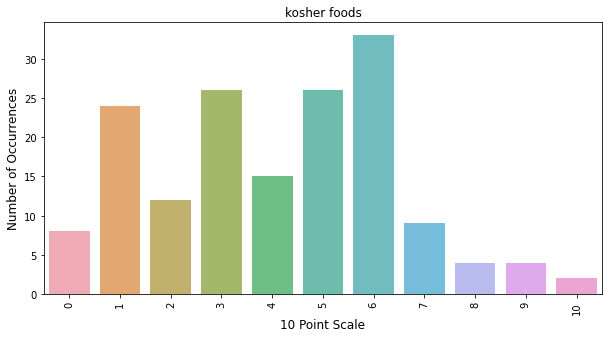

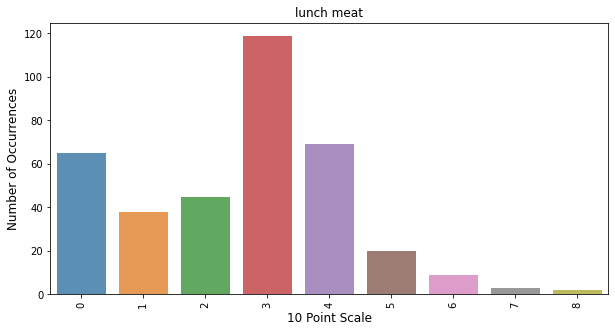

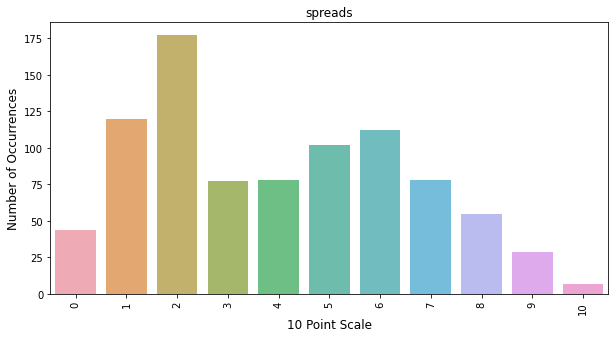

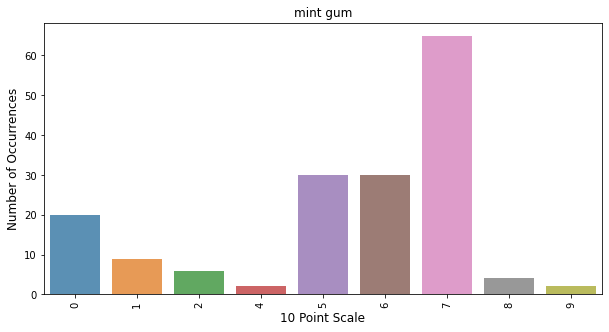

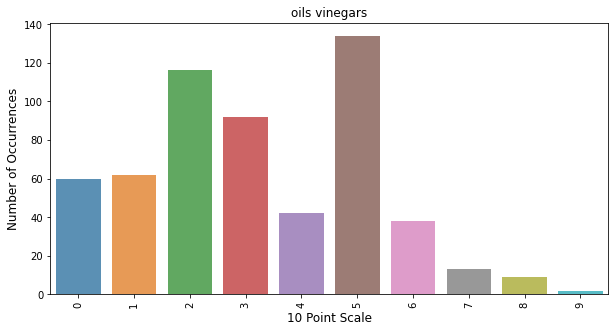

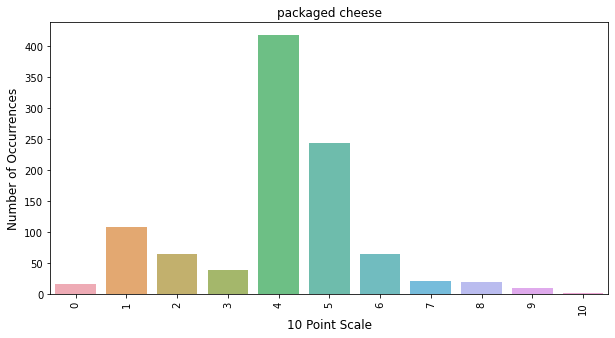

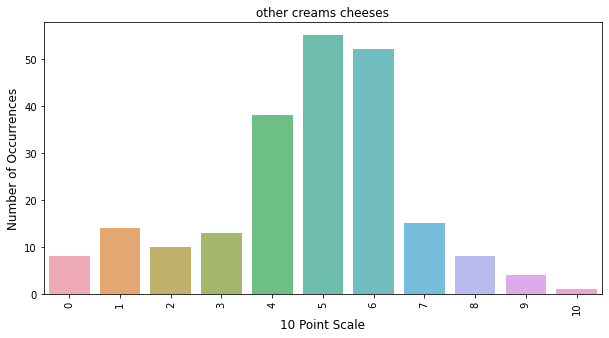

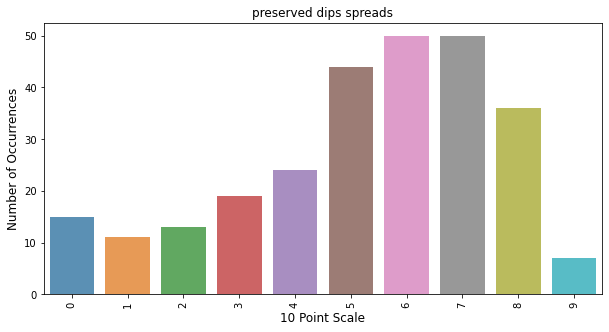

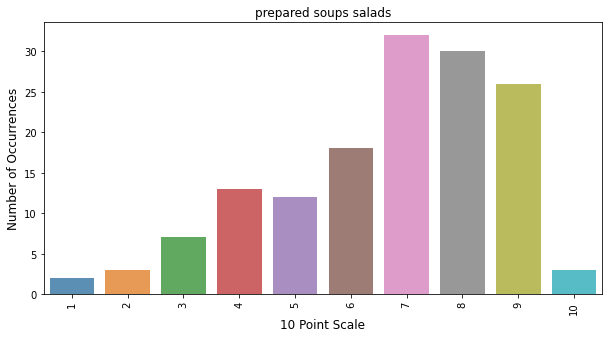

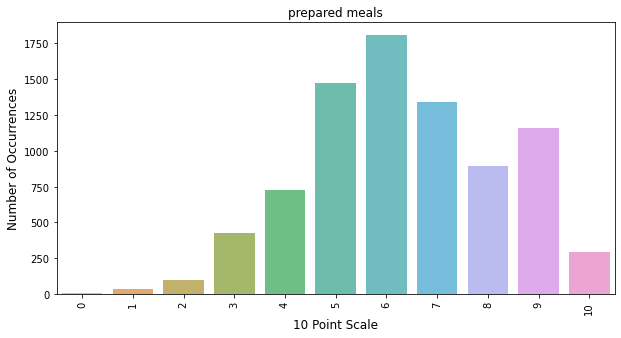

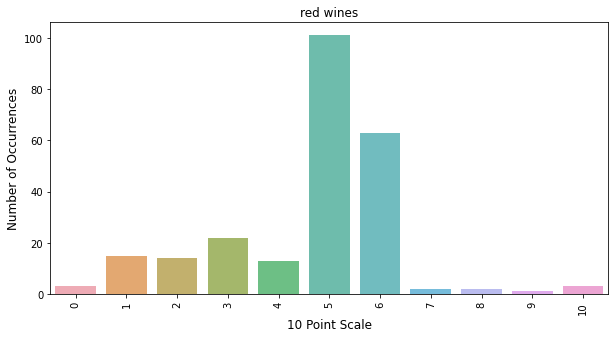

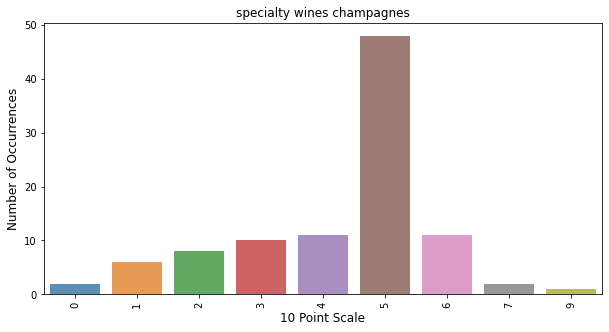

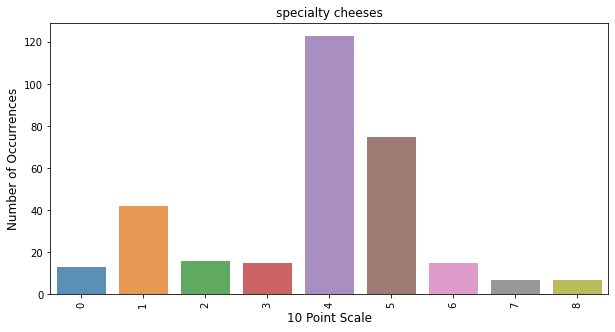

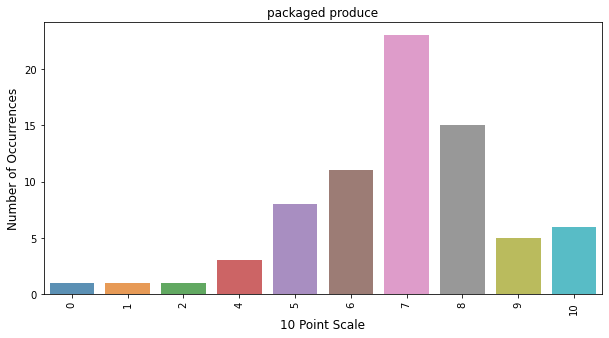

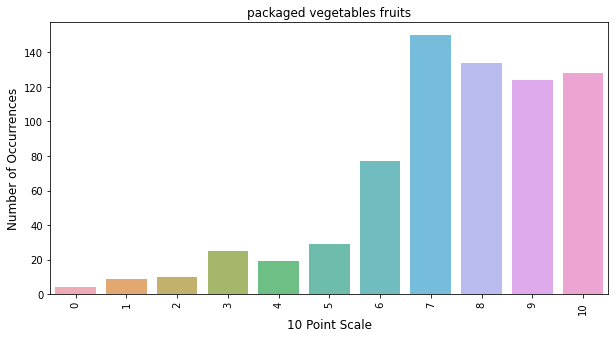

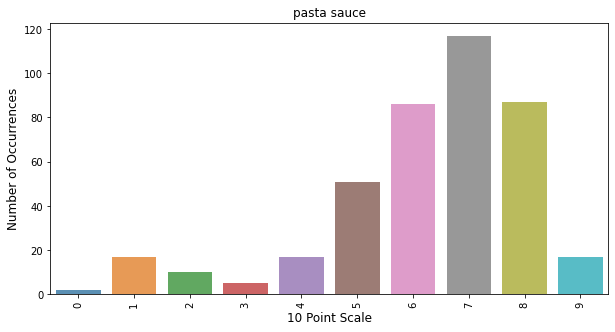

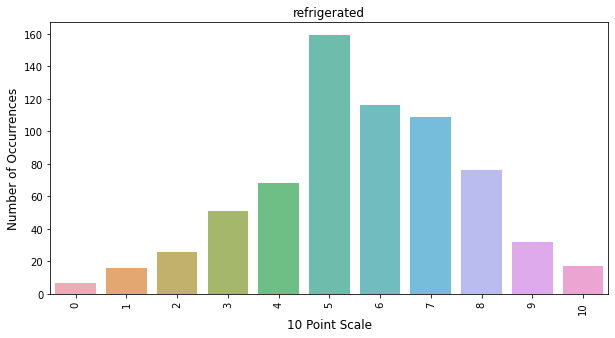

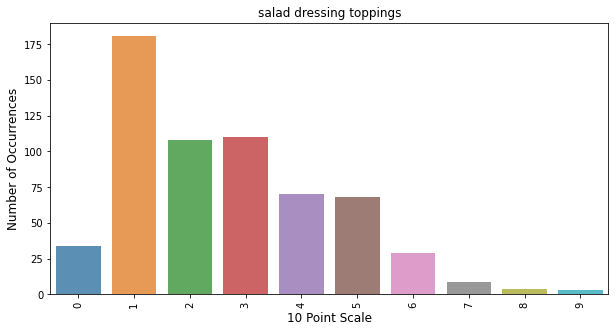

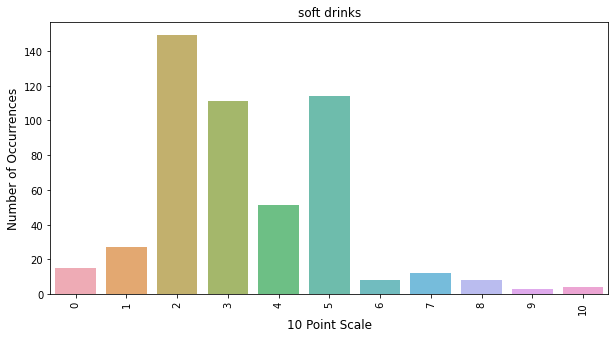

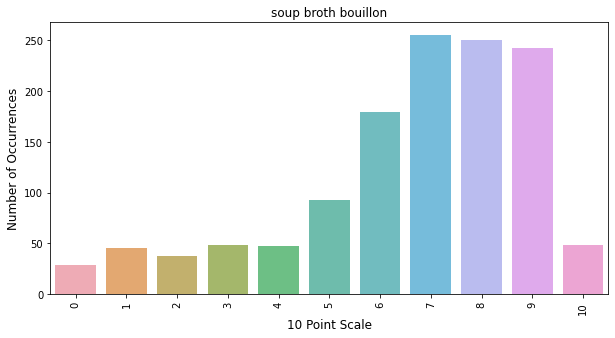

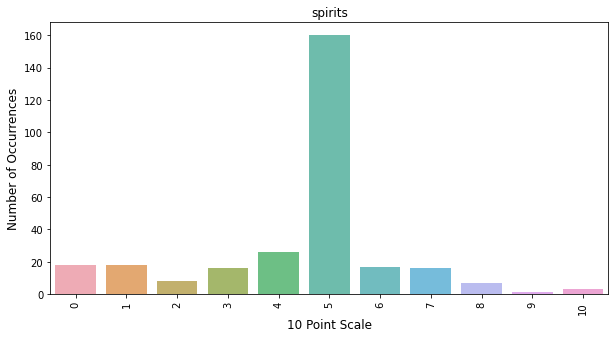

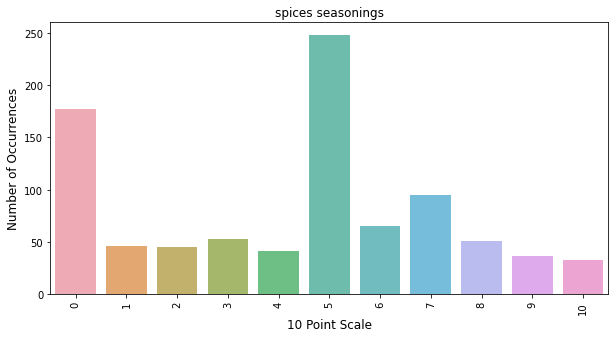

In [40]:
for aisle_name in data['aisle'].unique():
    plot_barplot(data, aisle_name, 'SAIN-LIM Point', '10 Point Scale')

In [54]:
savePath = 'Capstone/NutritionScores/'
data.to_csv(savePath+'SAINLIM_score.csv', index=False)